In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')

In [2]:
from statsmodels.stats.multitest import multipletests

In [3]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=3,2
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =1
plt.rcParams['lines.linewidth'] =1
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=1) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [4]:
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:51:59) 
[Clang 14.0.6 ]


In [5]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e 'seaborn' -e 'jupyterlab' -e "statsmodels"

jupyterlab                    3.6.3
jupyterlab-code-snippets      2.1.0
jupyterlab-pygments           0.1.2
jupyterlab_server             2.22.1
jupyterlab-widgets            1.0.2
matplotlib                    3.4.3
matplotlib-inline             0.1.3
matplotlib-venn               0.11.6
numpy                         1.20.3
pandas                        1.3.4
scipy                         1.7.2
seaborn                       0.11.2
statsmodels                   0.13.1
Note: you may need to restart the kernel to use updated packages.


# Broad

## data integration

In [6]:
df=pd.read_csv('../processed_data/CCLE_broad.txt',sep='\t',index_col=0)

In [7]:
gdsc1=pd.read_csv('../processed_data/GDSC1_AUC.txt',sep='\t',index_col=0)
gdsc2=pd.read_csv('../processed_data/GDSC2_AUC.txt',sep='\t',index_col=0)
ctrp1=pd.read_csv('../processed_data/CTRP1_AUC.txt',sep='\t',index_col=0)
ctrp2=pd.read_csv('../processed_data/CTRP2_AUC.txt',sep='\t',index_col=0)
prism=pd.read_csv('../processed_data/PRISM_AUC.txt',sep='\t',index_col=0)
gcsi=pd.read_csv('../processed_data/gCSI_AOC.txt',sep='\t',index_col=0)

In [8]:
df=df.merge(prism,left_index=True,right_index=True,how='left')
df['COSMICID']=df['COSMICID'].fillna(-1).astype(int)
df=df.merge(gdsc1,left_on='COSMICID',right_index=True,how='left')
df=df.merge(gdsc2,left_on='COSMICID',right_index=True,how='left')
df=df.merge(ctrp1,left_on='stripped_cell_line_name',right_index=True,how='left')
df=df.merge(ctrp2,left_on='stripped_cell_line_name',right_index=True,how='left')
df=df.merge(gcsi,left_on='stripped_cell_line_name',right_index=True,how='left')

In [9]:
df['HRD_score_broad']=df['HRD_score']

In [10]:
brca1_met=[]
for idx in df.index:
    if df.loc[idx,'BRCA1_methylation_broad']==1:
        brca1_met.append(1)
    elif df.loc[idx,'BRCA1_methylation_cosmic_likely']==1:
        brca1_met.append(1)
    elif df.loc[idx,'BRCA1_methylation_broad']==0:
        brca1_met.append(0)
    elif df.loc[idx,'BRCA1_methylation_cosmic_likely']==0:
        brca1_met.append(0)
    else:
        brca1_met.append(np.nan)
df['BRCA1_methylation']=brca1_met

In [11]:
brca_status=[]
for idx in df.index:
    if df.loc[idx,'BRCA1']=='LOH':
        brca_status.append('BRCA1_LOH')
    elif df.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df.loc[idx,'BRCA1_methylation']==1:
        brca_status.append('BRCA1_methylation')
    elif df.loc[idx,'otherHRR_LOH']==1:
        brca_status.append('HRR_LOH')
    elif df.loc[idx,'BRCA1']=='unknown':
        brca_status.append('BRCA1_unknown')
    elif df.loc[idx,'otherHRR_unknown']==1:
        brca_status.append('HRR_unknown')
    elif df.loc[idx,'BRCA1']=='nonLOH':
        brca_status.append('BRCA1_nonLOH')
    elif df.loc[idx,'BRCA2']=='nonLOH':
        brca_status.append('BRCA2_nonLOH')
    elif df.loc[idx,'otherHRR_nonLOH']==1:
        brca_status.append('HRR_nonLOH')
    elif (df.loc[idx,'BRCA1']=='wt')&(df.loc[idx,'BRCA2']=='wt')&(df.loc[idx,'BRCA1_methylation']==0):
        brca_status.append('wt')
    else:
        brca_status.append(np.nan)
df['BRCA_status']=brca_status

In [12]:
Counter(df['BRCA_status']).most_common()

[('wt', 904),
 (nan, 559),
 ('HRR_nonLOH', 180),
 ('HRR_LOH', 60),
 ('HRR_unknown', 48),
 ('BRCA2_nonLOH', 47),
 ('BRCA1_nonLOH', 12),
 ('BRCA1_LOH', 10),
 ('BRCA2_LOH', 9),
 ('BRCA1_methylation', 8),
 ('BRCA1_unknown', 2)]

In [13]:
df=df[(df['BRCA_status'].isna()==False)]
#df=df[~df['BRCA_status'].isin(['HRR_unknown','BRCA1_unknown'])]
df.shape

(1280, 1034)

In [14]:
df['BRCA_alteration']=((df['BRCA1_LOH']==1)|(df['BRCA1_methylation']==1)|(df['BRCA2_LOH']==1)).astype(int)
df['BRCA_alteration'].sum()

27

In [15]:
(~df['HRD_score_broad'].isna()).sum()

914

In [16]:
(~df['SigMA_broad'].isna()).sum()

1280

In [17]:
df0=df.copy()

In [18]:
df0['HRD_score_broad'].describe()

count    914.000000
mean      28.978118
std       19.119660
min        0.000000
25%       14.000000
50%       27.000000
75%       41.000000
max       92.000000
Name: HRD_score_broad, dtype: float64

In [19]:
df0['SigMA_broad'].describe()

count    1280.000000
mean        0.572302
std         0.121891
min         0.153970
25%         0.503122
50%         0.577521
75%         0.653675
max         0.860463
Name: SigMA_broad, dtype: float64

In [20]:
drug_gdsc1=set(df.columns[df.columns.str.startswith('GDSC1')])
drug_gdsc2=set(df.columns[df.columns.str.contains('GDSC2')])
drug_ctrp1=set(df.columns[df.columns.str.contains('CTRP1')])
drug_ctrp2=set(df.columns[df.columns.str.contains('CTRP2')])
drug_prism=set(df.columns[df.columns.str.startswith("PRISM")])
drug_gcsi=set(df.columns[df.columns.str.contains('gCSI')])
drug_total=drug_gdsc1|drug_gdsc2|drug_ctrp1|drug_ctrp2|drug_prism|drug_gcsi
len(drug_total)

882

In [21]:
drug_anno=pd.read_csv('../processed_data/Drug_annotaion_integrated.txt'
                      ,sep='\t',index_col=0)
drug_anno['cid']=drug_anno['cid'].astype(int)

In [22]:
## assays with fewer than 10 samples with HR-related gene alterations were excluded fo analysis
drug_all=[]
drug_exc=[]
for drug in drug_total:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    n=len(a)
    if n >=10:
        drug_all.append(drug)
    else:
        drug_exc.append(drug)

In [23]:
len(drug_all)

800

In [24]:
df_drug=df[~df[drug_all].isna().all(axis=1)]
df_drug=df_drug.loc[:,~df_drug.columns.isin(drug_exc)]
df_drug.shape

(1182, 953)

In [25]:
platinums=set(df_drug.columns[(df_drug.columns.str.contains('platin'))])
platinums

{'CTRP2_carboplatin_26979',
 'CTRP2_oxaliplatin_375582',
 'GDSC1_Cisplatin_1005',
 'GDSC2_Cisplatin_1005',
 'GDSC2_Oxaliplatin_1089',
 'GDSC2_Oxaliplatin_1806',
 'PRISM_carboplatin_BRD-K90947825-001-02-7',
 'PRISM_cisplatin_BRD-K69172251-001-08-9',
 'PRISM_oxaliplatin_BRD-K78960041-001-05-7',
 'gCSI_Cisplatin_CID24191118'}

In [26]:
parpis=set(df_drug.columns[(df_drug.columns.str.contains('parib'))])
parpis

{'CTRP2_olaparib_411867',
 'CTRP2_veliparib_606034',
 'GDSC1_Olaparib_1017',
 'GDSC1_Olaparib_1495',
 'GDSC1_Rucaparib_1175',
 'GDSC1_Talazoparib_1259',
 'GDSC1_Veliparib_1018',
 'GDSC2_Niraparib_1177',
 'GDSC2_Olaparib_1017',
 'GDSC2_Talazoparib_1259',
 'PRISM_niraparib_BRD-K54955827-001-02-2',
 'PRISM_olaparib_BRD-K02113016-001-15-4',
 'PRISM_olaparib_BRD-K02113016-001-19-6',
 'PRISM_talazoparib_BRD-K95142244-001-01-5'}

## BRCA status vs Drug sensitivity

### BRCA12 altaration

In [27]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum()

25

In [28]:
df_drug[df_drug['BRCA_status'].isin(['wt'])].shape

(872, 953)

In [29]:
df=df_drug.copy()

In [30]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [31]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps
df_cor=df_cor.dropna()

In [32]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [33]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
CTRP2_oxaliplatin_375582,40,0.163000,0.464937,0.245012,0.610813,0,Platinum,DNA alkylator; organoplatinum reagent,24197464
CTRP2_etoposide_48589,40,0.366000,0.851668,0.134455,0.871423,0,DNA inhibitor,inhibitor of topoisomerase II,36462
CTRP1_navitoclax_362342,40,0.112800,0.442333,0.772296,0.112216,0,Apoptosis regulation,"inhibitor of BCL2, BCL-xL and BCL-W",24978538
GDSC2_Alisertib_1051,40,0.029001,0.048353,0.017965,1.745577,1,Others,Mitosis,24771867
GDSC1_Afatinib_1032,40,-0.022091,-0.024512,0.009918,2.003569,1,EGFR signaling,EGFR signaling,10184653
...,...,...,...,...,...,...,...,...,...
CTRP1_vorinostat_56554,40,0.946200,0.681966,0.373446,0.427772,0,Chromatin-related,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, HDAC8",5311
GDSC1_Bleomycin (50 uM)_1378,40,0.100587,0.095369,0.100153,0.999338,0,DNA inhibitor,DNA replication,5460769
GDSC2_LCL161_1557,40,-0.003812,0.001130,0.551129,0.258746,0,Apoptosis regulation,Apoptosis regulation,24737642
PRISM_regorafenib_BRD-K16730910-001-07-3,40,0.073978,0.032046,0.446724,0.349961,0,Others,"FGFR inhibitor, KIT inhibitor, PDGFR tyrosine ...",11167602


In [34]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
GDSC2_Foretinib_2040,40,0.088439,0.106701,0.000118,3.926293,1,RTK signaling,RTK signaling,42642645
GDSC1_Vorinostat_1012,40,0.095145,0.095242,0.000427,3.369581,1,Chromatin-related,Chromatin histone acetylation,5311
GDSC2_Luminespib_1559,40,0.148574,0.110782,0.002511,2.600183,1,Protein stability and degradation,Protein stability and degradation,10096043
CTRP2_MGCD-265_628622,40,0.477500,0.947430,0.003304,2.480915,1,Others,inhibitor of c-MET and VEGFRs,24901704
CTRP2_barasertib_601923,40,0.781500,2.112513,0.003751,2.425845,1,Others,inhibitor of aurora kinase B,11497983
...,...,...,...,...,...,...,...,...,...
gCSI_Palbociclib_CID5330286,40,-0.075778,-0.083308,0.008206,2.085858,1,Cell cycle,None,5330286
GDSC1_Afatinib_1377,40,-0.049040,-0.048723,0.003309,2.480291,1,EGFR signaling,EGFR signaling,10184653
GDSC1_IOX2_1230,40,-0.006299,-0.001379,0.002341,2.630586,1,Others,Other,54685215
gCSI_JQ1 compound_CID71300862,40,-0.055889,-0.074094,0.001909,2.719162,1,Others,None,71300862


In [35]:
NP=len(df_cor_p)
NN=len(df_cor_n)

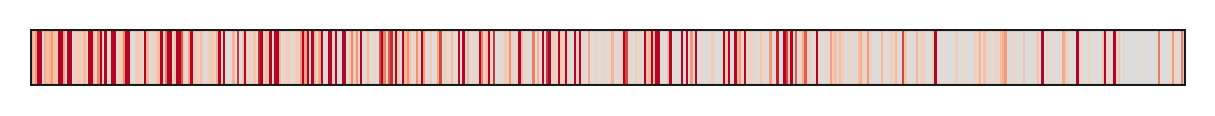

In [36]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

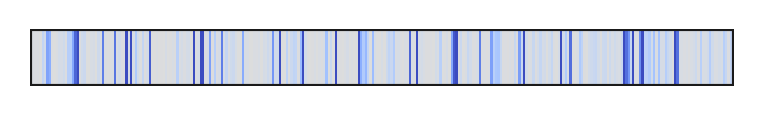

In [37]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

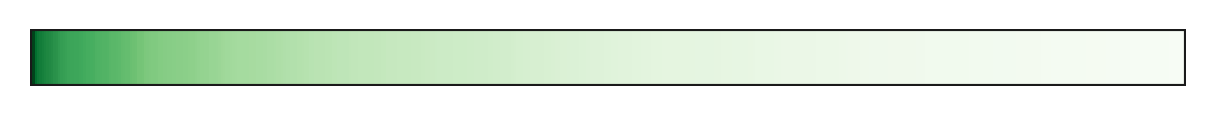

In [38]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

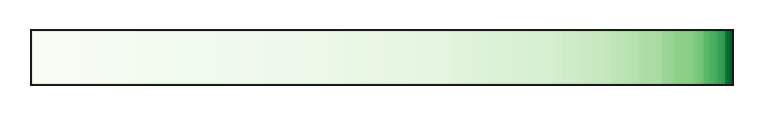

In [39]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

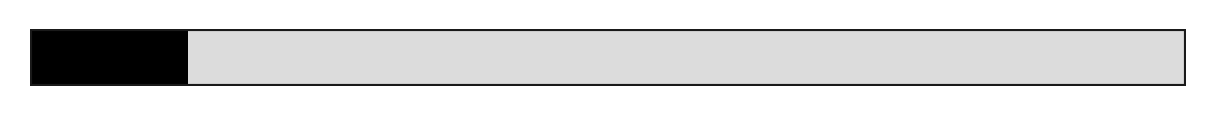

In [40]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

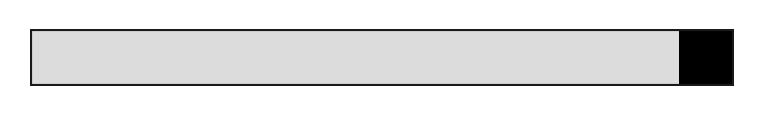

In [41]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [42]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [43]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'DNA inhibitor',
 'ERK MAPK signaling',
 'Antimetabolite',
 'Cell cycle',
 'Antimicrotubule',
 'EGFR signaling',
 'Apoptosis regulation',
 'Hormone-related',
 'Protein stability and degradation',
 'DNA alkylator',
 'PARP inhibitor',
 'Topoisomerase inhibitor',
 'Genome integrity',
 'WNT signaling',
 'Platinum',
 'Metabolism',
 'IGF1R signaling',
 'Cytoskeleton',
 'p53 pathway',
 'JNK and p38 signaling']

In [44]:
drug_order=[ 'Platinum',  'PARP inhibitor',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'DNA inhibitor',
 'Antimetabolite',
 'EGFR signaling',
 'Antimicrotubule',
 'Cell cycle',
 'Apoptosis regulation',
 'Hormone-related',
 'Protein stability and degradation',
 'DNA alkylator',
 'Topoisomerase inhibitor',
 'WNT signaling',
 'Metabolism',
 'Genome integrity',
 'p53 pathway',
 'IGF1R signaling',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [45]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

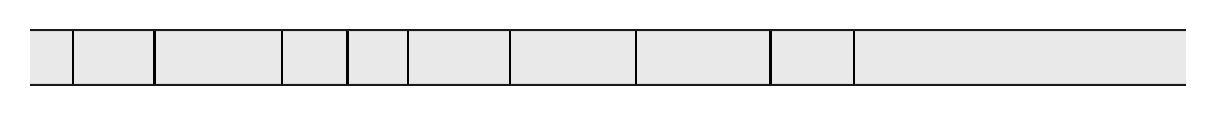

In [46]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [47]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

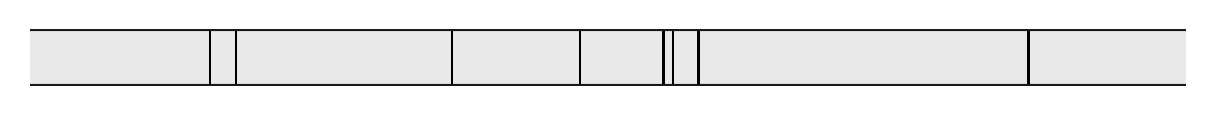

In [48]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


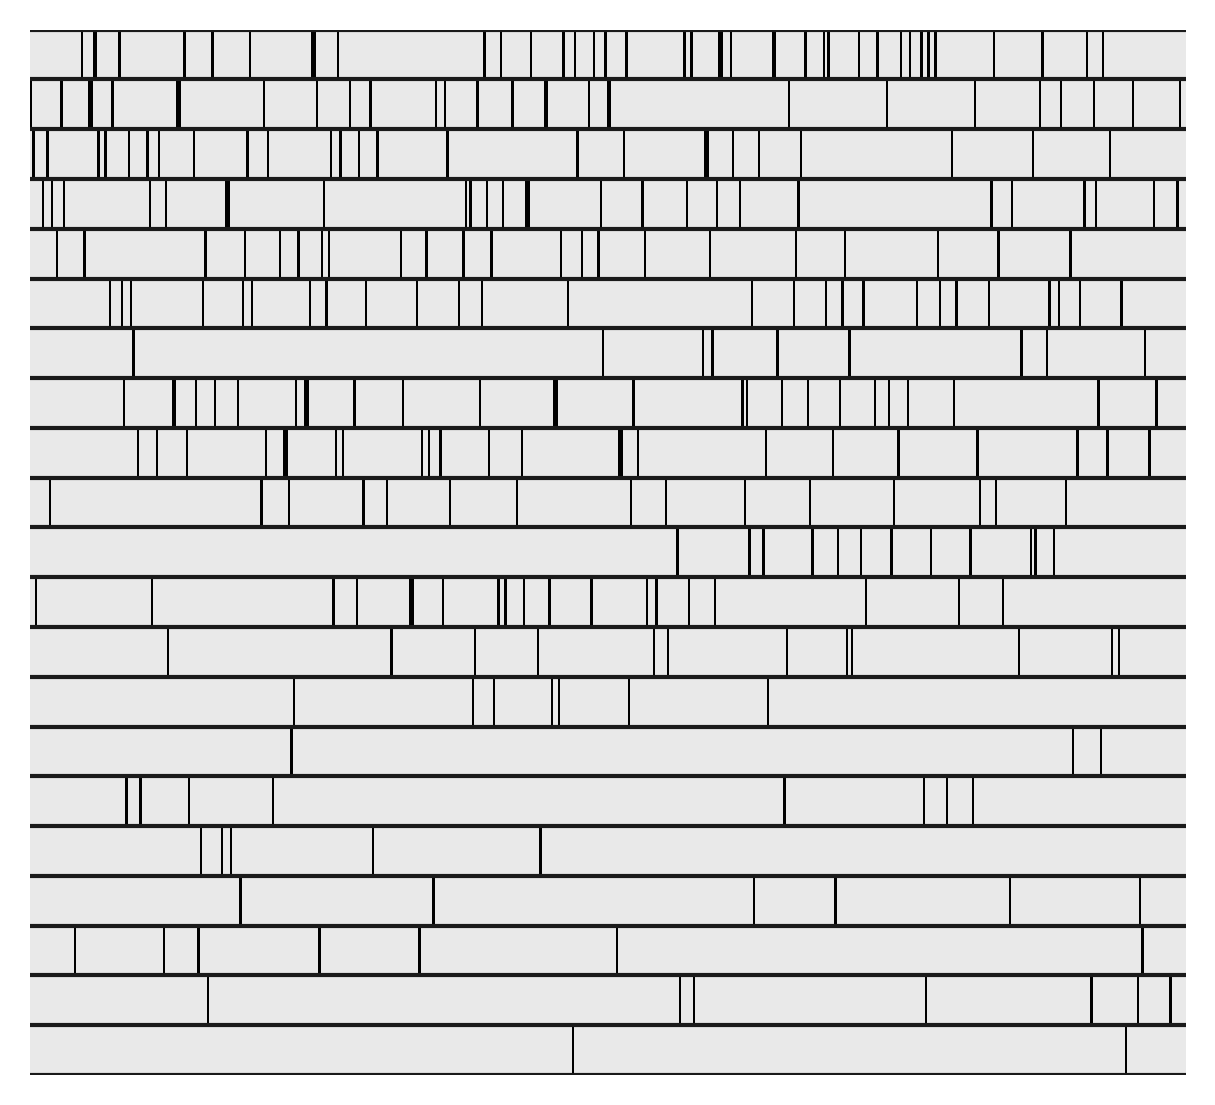

In [49]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [50]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

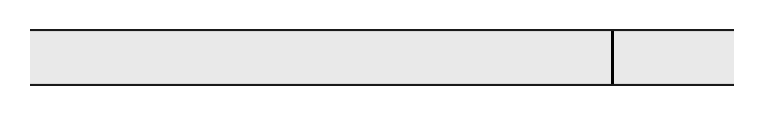

In [51]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

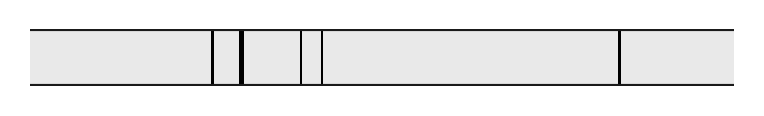

In [52]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')

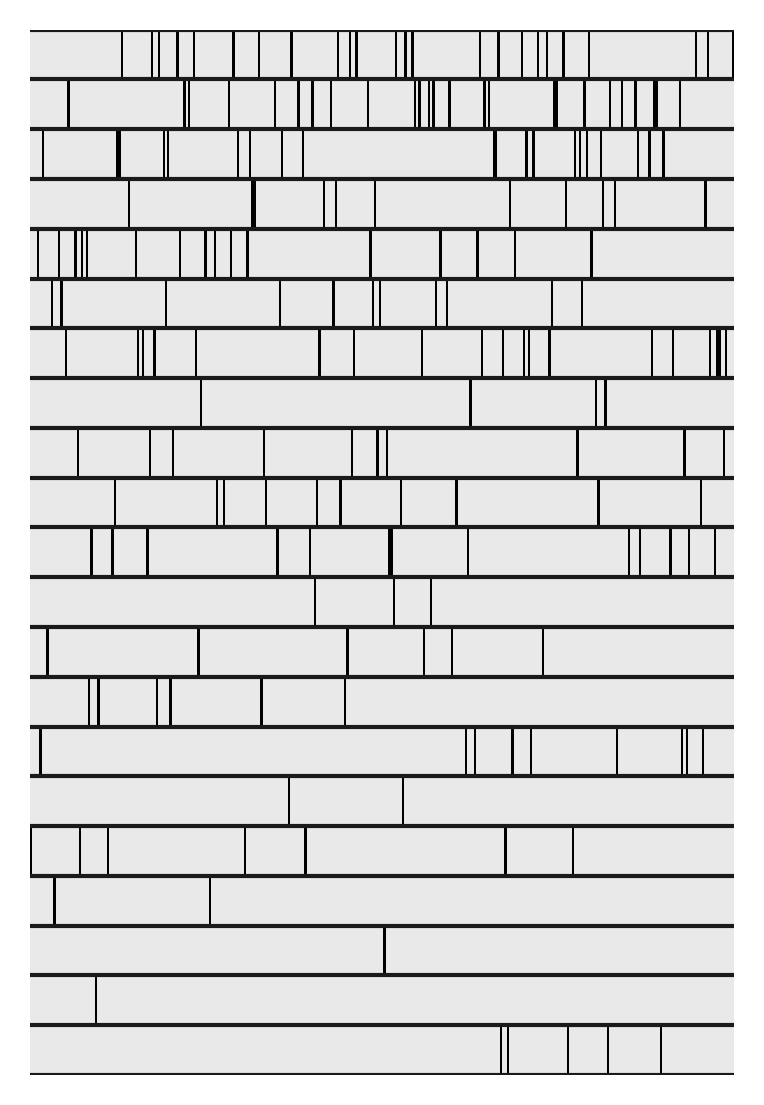

In [53]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

In [54]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,adjusted_P
GDSC2_Oxaliplatin_1089,40,0.017722,0.043411,0.011562,1.936967,1,Platinum,DNA replication,5310940,0.109786
GDSC2_Cisplatin_1005,40,0.031376,0.039406,0.039501,1.403389,1,Platinum,DNA replication,84691,0.304221
GDSC2_Oxaliplatin_1806,40,0.009080,0.028683,0.101070,0.995380,0,Platinum,DNA replication,5310940,0.573608
GDSC1_Cisplatin_1005,40,0.009872,0.028787,0.146806,0.833255,0,Platinum,DNA replication,84691,0.670192
CTRP2_carboplatin_26979,40,0.166000,0.256969,0.177170,0.751610,0,Platinum,inducer of DNA damage,38904,0.670192
CTRP2_oxaliplatin_375582,40,0.163000,0.464937,0.245012,0.610813,0,Platinum,DNA alkylator; organoplatinum reagent,24197464,0.675092
gCSI_Cisplatin_CID24191118,40,0.052556,0.020534,0.384477,0.415130,0,Platinum,None,24191118,0.766797
PRISM_carboplatin_BRD-K90947825-001-02-7,40,0.148143,0.076457,0.514545,0.288576,0,Platinum,"DNA alkylating agent, DNA inhibitor",426756,0.766797
PRISM_oxaliplatin_BRD-K78960041-001-05-7,40,0.018087,0.012186,0.642571,0.192079,0,Platinum,DNA inhibitor,24197464,0.766797
PRISM_cisplatin_BRD-K69172251-001-08-9,40,-0.013422,-0.091784,0.146546,0.834026,0,Platinum,"DNA alkylating agent, DNA synthesis inhibitor",24191118,0.670192


In [55]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,adjusted_P
PRISM_olaparib_BRD-K02113016-001-19-6,40,0.059524,0.043416,0.062463,1.204377,0,PARP inhibitor,PARP inhibitor,23725625,0.594643
GDSC2_Niraparib_1177,40,0.005434,0.028097,0.080489,1.094266,0,PARP inhibitor,Genome integrity,24958200,0.664075
PRISM_talazoparib_BRD-K95142244-001-01-5,40,0.095889,0.043518,0.209066,0.679716,0,PARP inhibitor,PARP inhibitor,135565082,0.924222
CTRP2_olaparib_411867,40,0.339500,0.242052,0.323061,0.490716,0,PARP inhibitor,inhibitor of poly (ADP-ribose) polymerase 1 and 2,23725625,0.979793
PRISM_niraparib_BRD-K54955827-001-02-2,40,0.013989,0.027824,0.410650,0.386528,0,PARP inhibitor,PARP inhibitor,24958200,0.991423
GDSC2_Talazoparib_1259,40,0.001030,0.065922,0.413839,0.383168,0,PARP inhibitor,Genome integrity,44819241,0.991423
GDSC1_Rucaparib_1175,40,0.001260,0.000517,0.424401,0.372224,0,PARP inhibitor,Genome integrity,9931953,0.991423
GDSC1_Talazoparib_1259,40,0.004271,0.040311,0.814607,0.089052,0,PARP inhibitor,Genome integrity,44819241,0.994838
GDSC2_Olaparib_1017,40,-0.002356,0.003897,0.728996,0.137275,0,PARP inhibitor,Genome integrity,23725625,0.994838
GDSC1_Veliparib_1018,40,-0.001277,0.001672,0.702937,0.153084,0,PARP inhibitor,Genome integrity,11960529,0.994838


### HR including BRCA1/2 alteration

In [56]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

82

In [57]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])].shape

(1100, 953)

In [58]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [59]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [60]:
df_cor=df_cor.dropna()

In [61]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [62]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
CTRP2_oxaliplatin_375582,40,0.266000,0.434020,0.034474,1.462503,1,Platinum,DNA alkylator; organoplatinum reagent,24197464
CTRP2_etoposide_48589,40,0.474000,0.743129,0.013058,1.884112,1,DNA inhibitor,inhibitor of topoisomerase II,36462
CTRP1_navitoclax_362342,40,0.144800,0.150449,0.928229,0.032345,0,Apoptosis regulation,"inhibitor of BCL2, BCL-xL and BCL-W",24978538
GDSC2_Alisertib_1051,40,0.006078,0.006369,0.372160,0.429270,0,Others,Mitosis,24771867
GDSC1_Afatinib_1032,40,-0.011322,-0.003318,0.024742,1.606572,1,EGFR signaling,EGFR signaling,10184653
...,...,...,...,...,...,...,...,...,...
CTRP1_vorinostat_56554,40,0.058800,0.329766,0.481004,0.317851,0,Chromatin-related,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, HDAC8",5311
GDSC1_Bleomycin (50 uM)_1378,40,0.028591,0.011347,0.728413,0.137622,0,DNA inhibitor,DNA replication,5460769
GDSC2_LCL161_1557,40,-0.000159,-0.001892,0.758385,0.120110,0,Apoptosis regulation,Apoptosis regulation,24737642
PRISM_regorafenib_BRD-K16730910-001-07-3,40,-0.006640,-0.040974,0.336245,0.473345,0,Others,"FGFR inhibitor, KIT inhibitor, PDGFR tyrosine ...",11167602


In [63]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
GDSC2_Buparlisib_1873,40,0.032389,0.030116,0.000450,3.346926,1,PI3K/MTOR signaling,PI3K/MTOR signaling,16654980
GDSC1_Vorinostat_1012,40,0.050680,0.056461,0.000873,3.059176,1,Chromatin-related,Chromatin histone acetylation,5311
GDSC2_BMS-536924_1091,40,0.030580,0.048086,0.000883,3.053816,1,IGF1R signaling,IGF1R signaling,10390396
CTRP2_COL-3_665914,40,0.683000,0.670939,0.001235,2.908296,1,Others,analog of tetracycline,54678924
GDSC2_MG-132_1862,40,0.037413,0.047152,0.001311,2.882503,1,Protein stability and degradation,Protein stability and degradation,462382
...,...,...,...,...,...,...,...,...,...
GDSC1_Cetuximab_1114,40,-0.008850,-0.002537,0.018021,1.744215,1,EGFR signaling,EGFR signaling,85668777
GDSC1_CGP-082996_54,40,-0.042919,-0.029612,0.016716,1.776858,1,Cell cycle,Cell cycle,24825971
GDSC1_Sorafenib_30,40,-0.050612,-0.025775,0.012357,1.908071,1,RTK signaling,RTK signaling,216239
GDSC1_Doramapimod_1042,40,-0.010748,-0.005039,0.004896,2.310169,1,JNK and p38 signaling,JNK and p38 signaling,156422


In [64]:
NP=len(df_cor_p)
NN=len(df_cor_n)

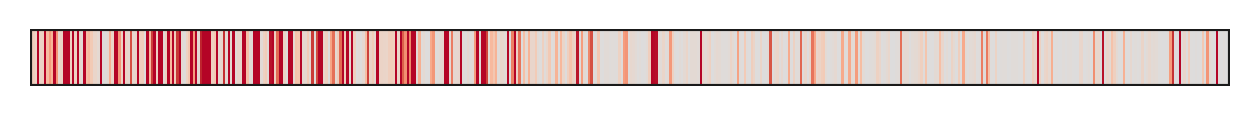

In [65]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

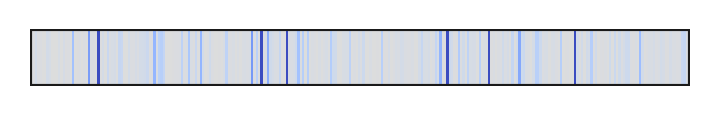

In [66]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

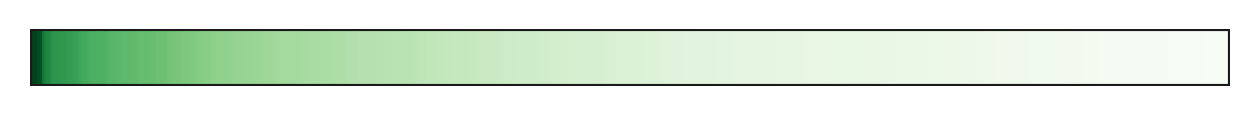

In [67]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

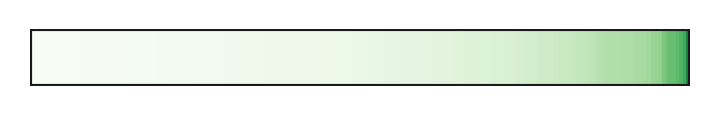

In [68]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

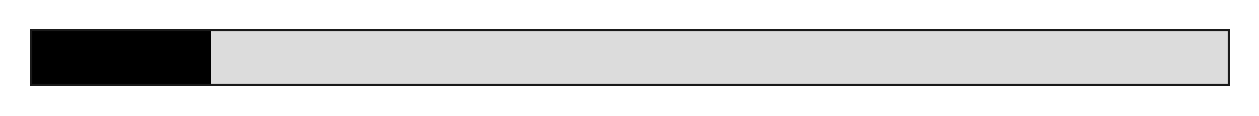

In [69]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

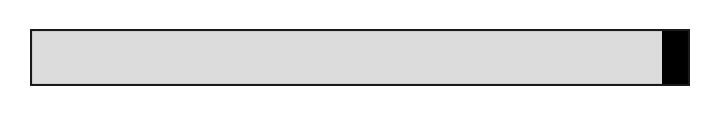

In [70]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [71]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [72]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

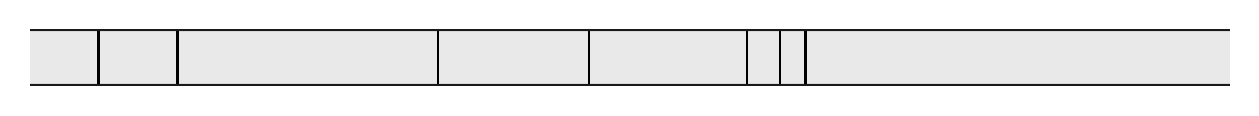

In [73]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

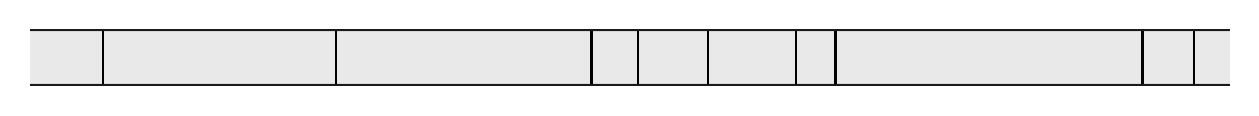

In [74]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


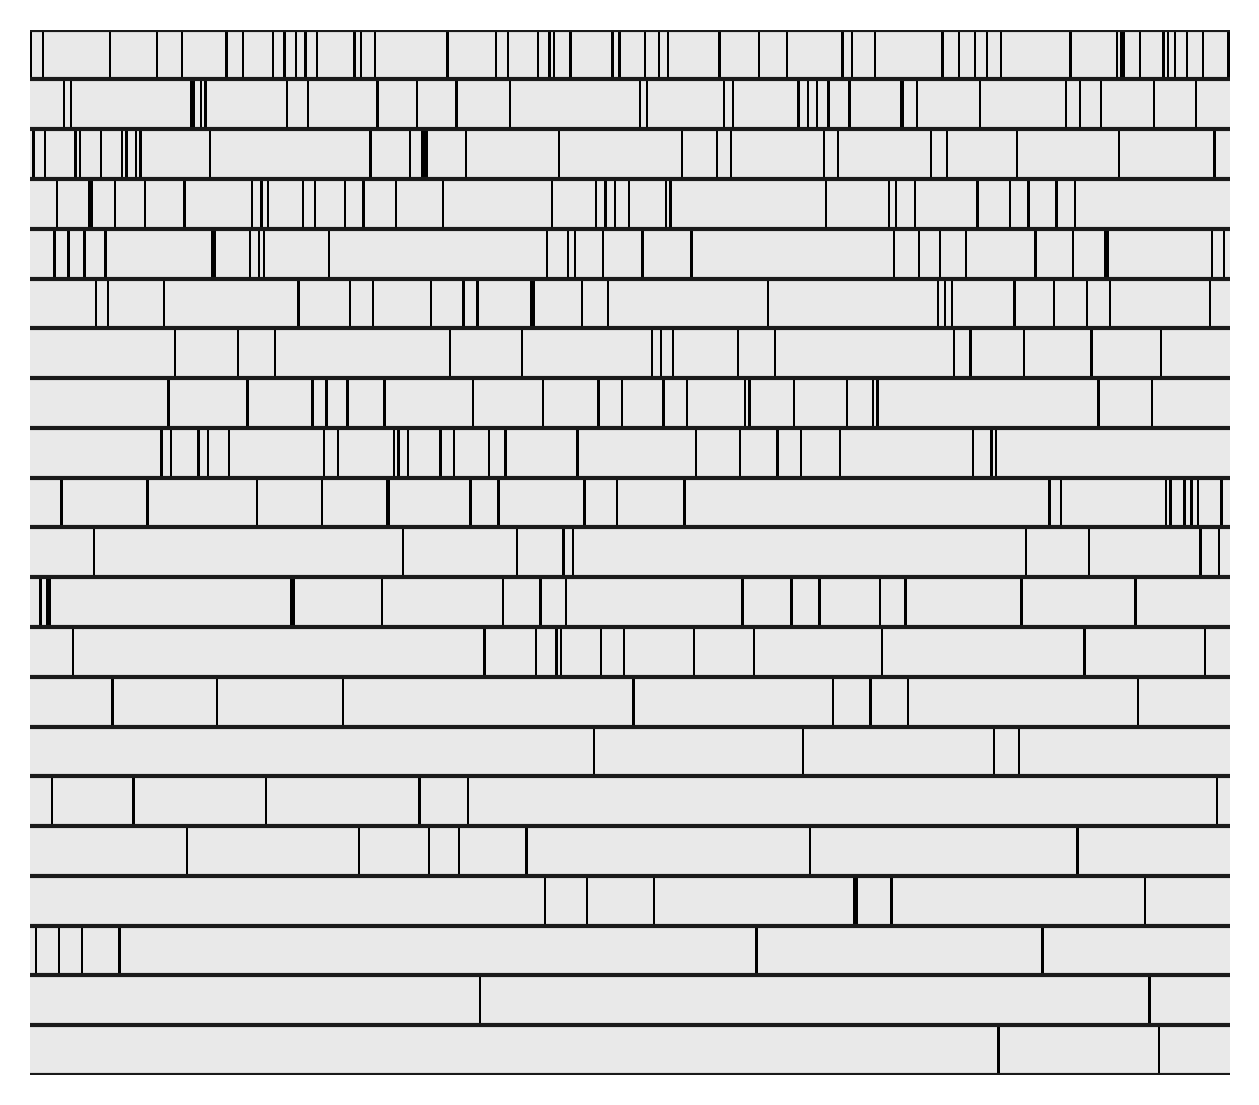

In [75]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [76]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

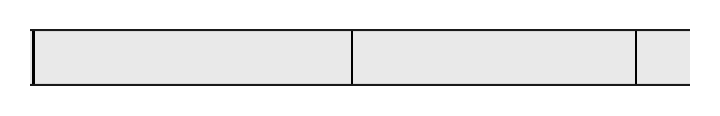

In [77]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

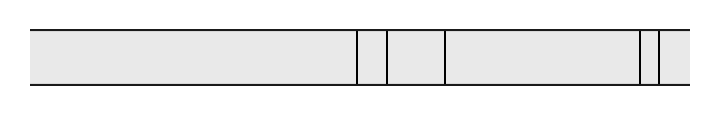

In [78]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

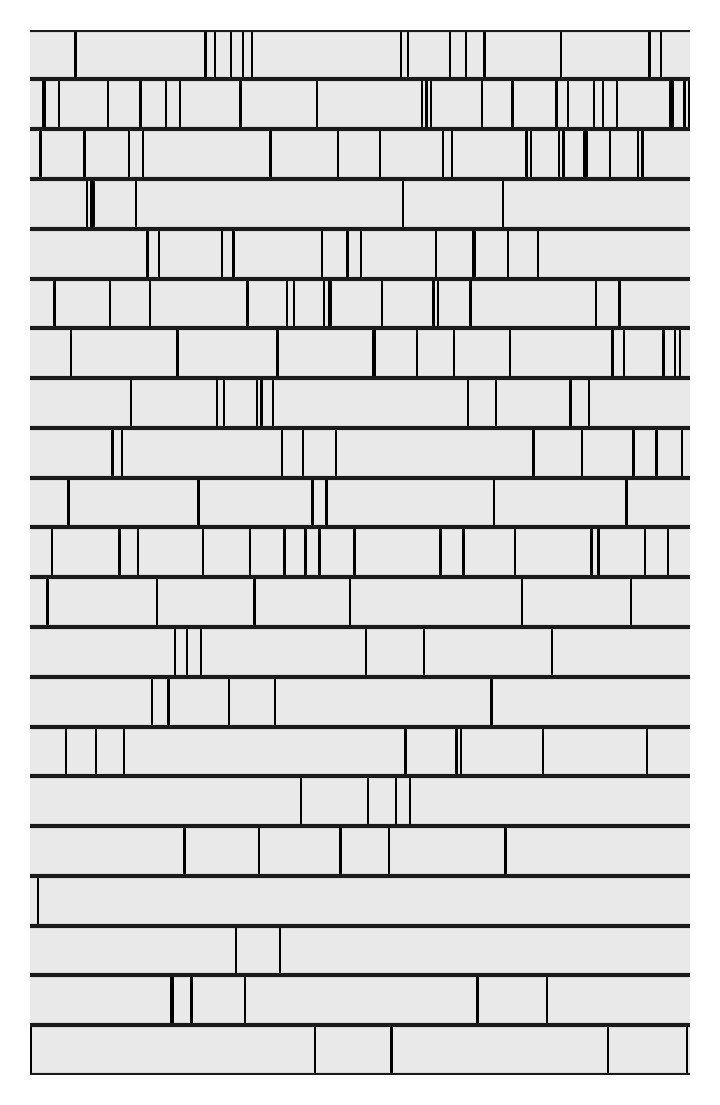

In [79]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [80]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,platinum_color,adjusted_P
GDSC2_Cisplatin_1005,40,0.018483,0.026100,0.016176,1.791137,1,Platinum,DNA replication,84691,1,0.150476
CTRP2_oxaliplatin_375582,40,0.266000,0.434020,0.034474,1.462503,1,Platinum,DNA alkylator; organoplatinum reagent,24197464,2,0.270754
GDSC2_Oxaliplatin_1089,40,0.006920,0.019415,0.157080,0.803879,0,Platinum,DNA replication,5310940,2,0.697654
PRISM_carboplatin_BRD-K90947825-001-02-7,40,0.176583,0.047341,0.274666,0.561196,0,Platinum,"DNA alkylating agent, DNA inhibitor",426756,3,0.854377
CTRP2_carboplatin_26979,40,0.007000,0.113893,0.422557,0.374115,0,Platinum,inducer of DNA damage,38904,3,0.935798
GDSC1_Cisplatin_1005,40,0.005509,0.010835,0.451014,0.345810,0,Platinum,DNA replication,84691,1,0.935798
gCSI_Cisplatin_CID24191118,40,0.032722,0.015302,0.472460,0.325635,0,Platinum,None,24191118,1,0.935798
PRISM_oxaliplatin_BRD-K78960041-001-05-7,40,-0.005493,-0.005011,0.996620,0.001470,0,Platinum,DNA inhibitor,24197464,2,0.996620
GDSC2_Oxaliplatin_1806,40,-0.000440,0.012289,0.566322,0.246937,0,Platinum,DNA replication,5310940,2,0.935798
PRISM_cisplatin_BRD-K69172251-001-08-9,40,-0.011916,-0.019781,0.090395,1.043854,0,Platinum,"DNA alkylating agent, DNA synthesis inhibitor",24191118,1,0.531379


In [81]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,platinum_color,adjusted_P
GDSC2_Niraparib_1177,40,0.006844,0.019611,0.016287,1.788167,1,PARP inhibitor,Genome integrity,24958200,0,0.205380
GDSC2_Talazoparib_1259,40,0.014545,0.046702,0.096331,1.016234,0,PARP inhibitor,Genome integrity,44819241,0,0.671827
CTRP2_olaparib_411867,40,0.243000,0.076579,0.276868,0.557727,0,PARP inhibitor,inhibitor of poly (ADP-ribose) polymerase 1 and 2,23725625,0,0.960900
GDSC2_Olaparib_1017,40,0.003092,0.008316,0.326239,0.486464,0,PARP inhibitor,Genome integrity,23725625,0,0.971388
PRISM_olaparib_BRD-K02113016-001-19-6,40,0.028760,0.004135,0.396206,0.402079,0,PARP inhibitor,PARP inhibitor,23725625,0,0.980283
CTRP2_veliparib_606034,40,0.009000,0.145919,0.462486,0.334901,0,PARP inhibitor,inhibitor of poly (ADP-ribose) polymerase 1 (P...,11960529,0,0.980283
PRISM_niraparib_BRD-K54955827-001-02-2,40,0.020144,0.000672,0.492405,0.307677,0,PARP inhibitor,PARP inhibitor,24958200,0,0.980283
PRISM_talazoparib_BRD-K95142244-001-01-5,40,0.034146,-0.011490,0.897895,0.046774,0,PARP inhibitor,PARP inhibitor,135565082,0,0.989575
GDSC1_Olaparib_1017,40,0.000315,0.004148,0.948613,0.022911,0,PARP inhibitor,Genome integrity,23725625,0,0.989575
GDSC1_Veliparib_1018,40,-0.001262,0.001761,0.560090,0.251742,0,PARP inhibitor,Genome integrity,11960529,0,0.980283


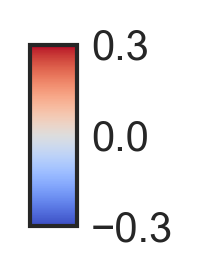

In [82]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("coolwarm")
vmin=-0.3
vmax=0.3
bounds=[-0.3,0,0.3]
fontsize=10
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label,)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

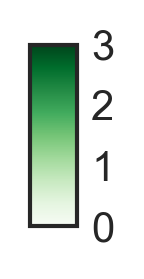

In [83]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("Greens")
vmin=0
vmax=3
bounds=[0,1,2,3]
fontsize=10
label=''
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

### HR excluding BRCA1/2 alteration

In [84]:
df_drug['BRCA_status'].isin(['HRR_LOH']).sum()

57

In [85]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])].shape

(1100, 953)

In [86]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=7
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['HRR_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
#        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [87]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [88]:
df_cor=df_cor.dropna()

In [89]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [90]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
CTRP2_oxaliplatin_375582,37.0,0.344000,0.418979,0.068731,1.162844,0,Platinum,DNA alkylator; organoplatinum reagent,24197464
CTRP2_etoposide_48589,38.0,0.519000,0.691716,0.040698,1.390424,1,DNA inhibitor,inhibitor of topoisomerase II,36462
CTRP1_navitoclax_362342,9.0,0.144800,-0.044141,0.905825,0.042956,0,Apoptosis regulation,"inhibitor of BCL2, BCL-xL and BCL-W",24978538
GDSC2_Alisertib_1051,39.0,-0.006133,-0.011931,0.656538,0.182740,0,Others,Mitosis,24771867
GDSC1_Afatinib_1032,44.0,-0.007022,0.006316,0.299892,0.523035,0,EGFR signaling,EGFR signaling,10184653
...,...,...,...,...,...,...,...,...,...
CTRP1_vorinostat_56554,9.0,0.058800,0.094966,0.850957,0.070093,0,Chromatin-related,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, HDAC8",5311
GDSC1_Bleomycin (50 uM)_1378,43.0,-0.054495,-0.029687,0.483650,0.315469,0,DNA inhibitor,DNA replication,5460769
GDSC2_LCL161_1557,38.0,0.000555,-0.003085,0.999156,0.000367,0,Apoptosis regulation,Apoptosis regulation,24737642
PRISM_regorafenib_BRD-K16730910-001-07-3,29.0,-0.016226,-0.066153,0.117222,0.930990,0,Others,"FGFR inhibitor, KIT inhibitor, PDGFR tyrosine ...",11167602


In [91]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
PRISM_cyproterone-acetate_BRD-K41141507-001-16-2,16.0,0.047824,0.089087,0.001850,2.732837,1,Hormone-related,androgen receptor antagonist,9880
GDSC2_MG-132_1862,40.0,0.041928,0.051853,0.002425,2.615271,1,Protein stability and degradation,Protein stability and degradation,462382
CTRP2_fluvastatin_660322,39.0,0.768500,0.716861,0.003550,2.449764,1,Others,inhibitor of HMG-CoA reductase,446155
CTRP2_COL-3_665914,32.0,0.586000,0.672790,0.007451,2.127763,1,Others,analog of tetracycline,54678924
GDSC2_Buparlisib_1873,40.0,0.032389,0.025823,0.007538,2.122761,1,PI3K/MTOR signaling,PI3K/MTOR signaling,16654980
...,...,...,...,...,...,...,...,...,...
GDSC1_Imatinib_34,17.0,-0.005521,0.008420,0.038457,1.415030,1,Others,"Other, kinases",5291
GDSC1_BMS-509744_63,15.0,-0.047187,-0.030973,0.029298,1.533163,1,Others,"Other, kinases",20635522
GDSC1_Doramapimod_1042,44.0,-0.010120,-0.003792,0.021385,1.669900,1,JNK and p38 signaling,JNK and p38 signaling,156422
GDSC1_CGP-082996_54,15.0,-0.044231,-0.040099,0.014051,1.852302,1,Cell cycle,Cell cycle,24825971


In [92]:
NP=len(df_cor_p)
NN=len(df_cor_n)

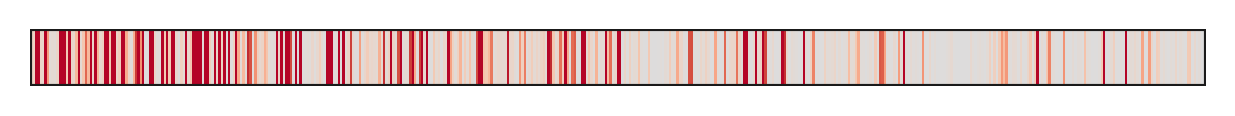

In [93]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

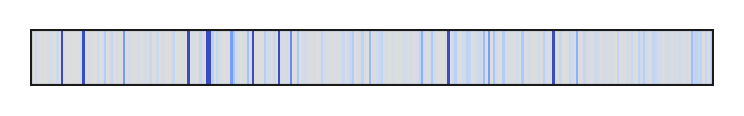

In [94]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

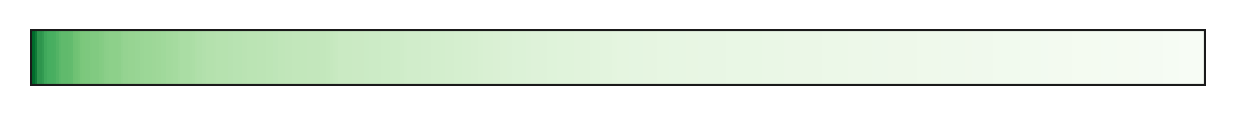

In [95]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

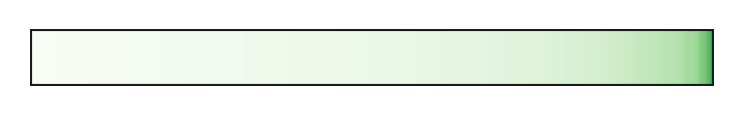

In [96]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

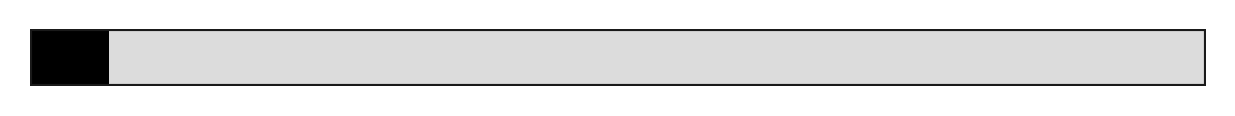

In [97]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

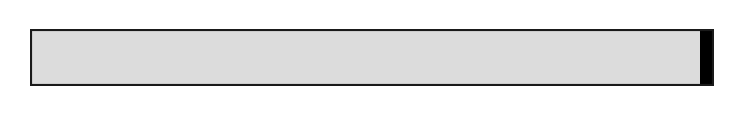

In [98]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [99]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [100]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

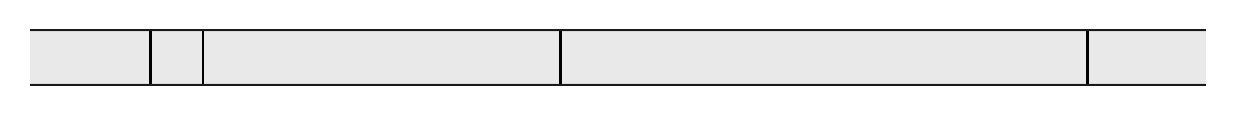

In [101]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

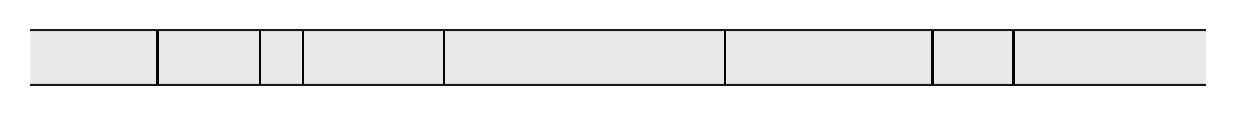

In [102]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


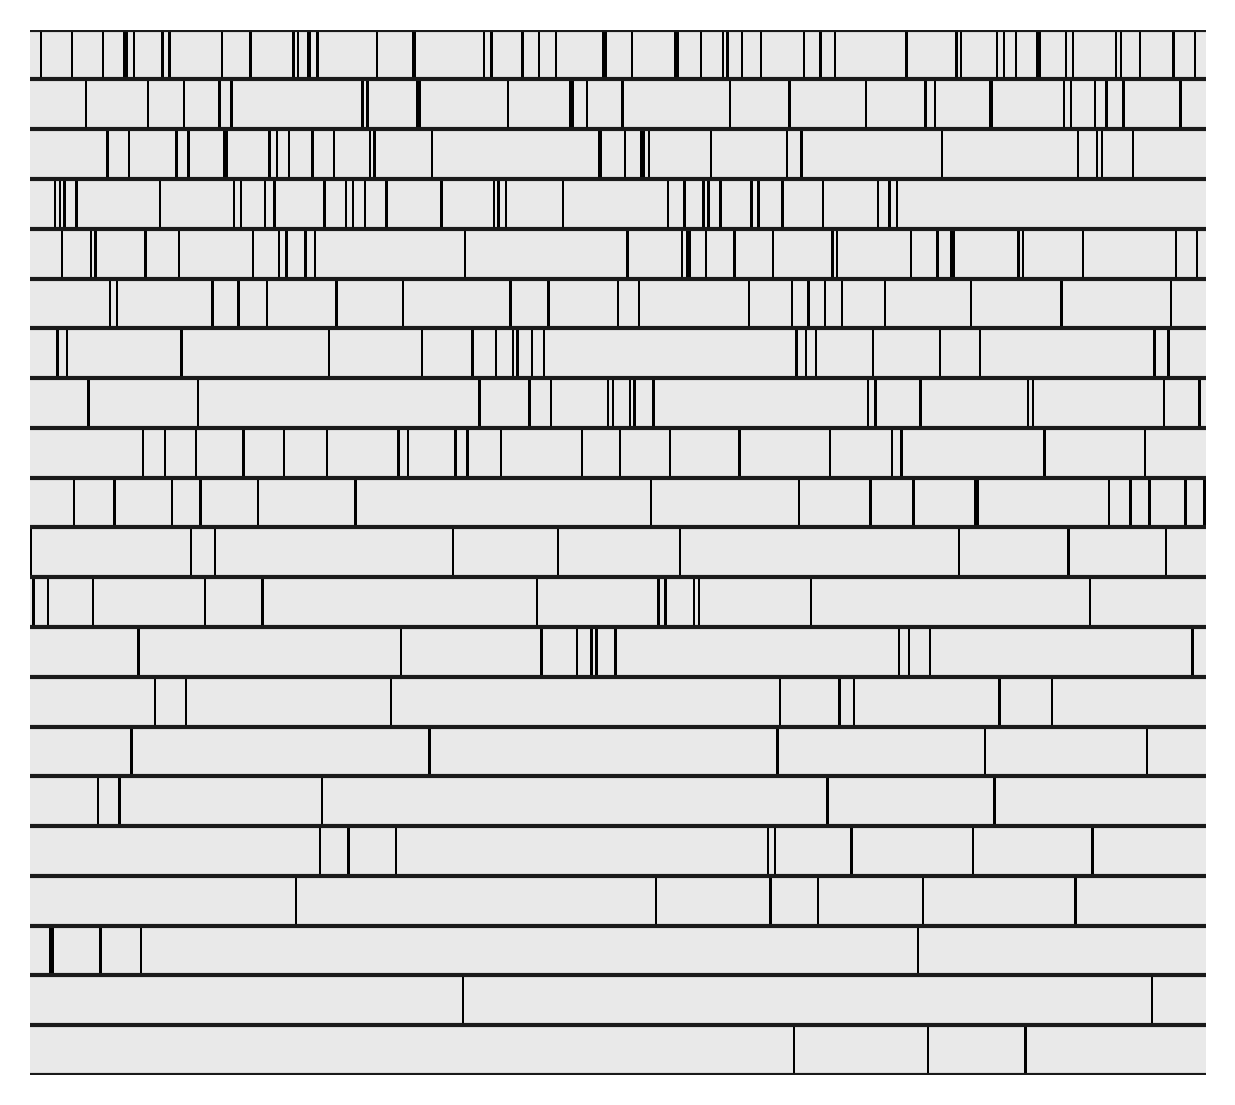

In [103]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [104]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

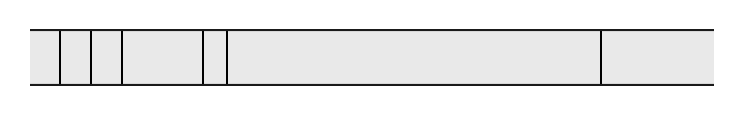

In [105]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

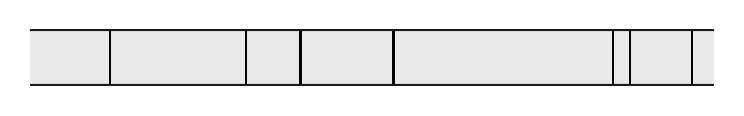

In [106]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

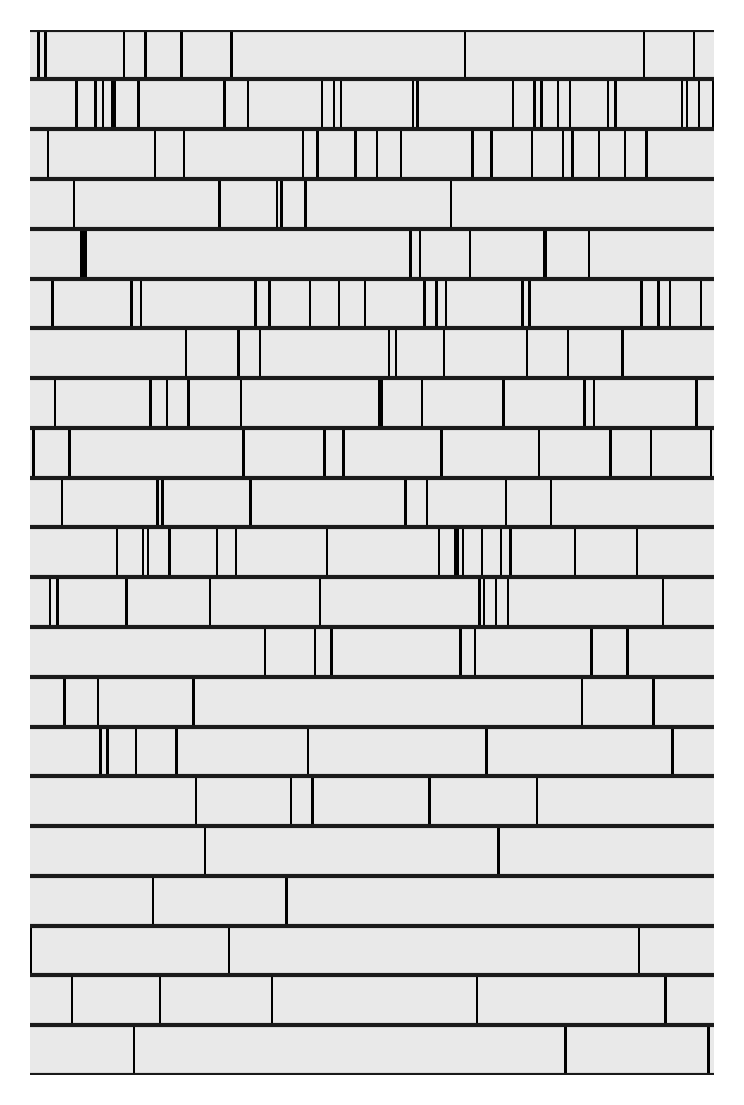

In [107]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [108]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,platinum_color,adjusted_P
CTRP2_oxaliplatin_375582,37.0,0.344000,0.418979,0.068731,1.162844,0,Platinum,DNA alkylator; organoplatinum reagent,24197464,2,0.509375
GDSC2_Cisplatin_1005,40.0,0.010614,0.020444,0.110190,0.957858,0,Platinum,DNA replication,84691,1,0.650316
PRISM_carboplatin_BRD-K90947825-001-02-7,28.0,0.199293,0.036943,0.362113,0.441156,0,Platinum,"DNA alkylating agent, DNA inhibitor",426756,3,0.957026
gCSI_Cisplatin_CID24191118,12.0,0.013389,0.010943,0.839106,0.076183,0,Platinum,None,24191118,1,0.999743
GDSC1_Cisplatin_1005,44.0,-0.007529,0.002674,0.968402,0.013944,0,Platinum,DNA replication,84691,1,0.999743
CTRP2_carboplatin_26979,41.0,-0.005000,0.051080,0.920476,0.035987,0,Platinum,inducer of DNA damage,38904,3,0.999743
GDSC2_Oxaliplatin_1089,42.0,-0.001522,0.010274,0.873202,0.058885,0,Platinum,DNA replication,5310940,2,0.999743
PRISM_oxaliplatin_BRD-K78960041-001-05-7,28.0,-0.021166,-0.011768,0.772154,0.112296,0,Platinum,DNA inhibitor,24197464,2,0.999743
GDSC2_Oxaliplatin_1806,38.0,-0.004783,0.005817,0.747788,0.126221,0,Platinum,DNA replication,5310940,2,0.999743
PRISM_cisplatin_BRD-K69172251-001-08-9,29.0,-0.004555,0.007531,0.250168,0.601768,0,Platinum,"DNA alkylating agent, DNA synthesis inhibitor",24191118,1,0.900067


In [109]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_44026/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid,platinum_color,adjusted_P
GDSC2_Niraparib_1177,38.0,0.007965,0.016261,0.071864,1.143490,0,PARP inhibitor,Genome integrity,24958200,0,0.647983
GDSC2_Talazoparib_1259,39.0,0.022047,0.038816,0.136330,0.865407,0,PARP inhibitor,Genome integrity,44819241,0,0.827745
GDSC2_Olaparib_1017,40.0,0.003659,0.010193,0.158226,0.800722,0,PARP inhibitor,Genome integrity,23725625,0,0.849634
CTRP2_veliparib_606034,41.0,0.031000,0.161229,0.251768,0.598999,0,PARP inhibitor,inhibitor of poly (ADP-ribose) polymerase 1 (P...,11960529,0,0.901760
CTRP2_olaparib_411867,41.0,0.216000,0.003932,0.495252,0.305174,0,PARP inhibitor,inhibitor of poly (ADP-ribose) polymerase 1 and 2,23725625,0,0.991653
GDSC1_Olaparib_1017,44.0,0.001140,0.004812,0.658631,0.181358,0,PARP inhibitor,Genome integrity,23725625,0,0.994436
PRISM_niraparib_BRD-K54955827-001-02-2,28.0,0.020144,-0.010964,0.759212,0.119637,0,PARP inhibitor,PARP inhibitor,24958200,0,0.994436
PRISM_olaparib_BRD-K02113016-001-19-6,27.0,-0.022758,-0.011869,0.892377,0.049452,0,PARP inhibitor,PARP inhibitor,23725625,0,0.994436
GDSC1_Rucaparib_1175,43.0,-0.003122,-0.003022,0.713810,0.146417,0,PARP inhibitor,Genome integrity,9931953,0,0.994436
GDSC1_Veliparib_1018,44.0,-0.001262,0.001801,0.645936,0.189811,0,PARP inhibitor,Genome integrity,11960529,0,0.994436


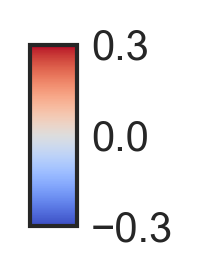

In [110]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("coolwarm")
vmin=-0.3
vmax=0.3
bounds=[-0.3,0,0.3]
fontsize=10
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label,)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

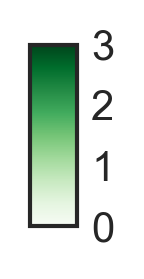

In [111]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("Greens")
vmin=0
vmax=3
bounds=[0,1,2,3]
fontsize=10
label=''
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

### BRCA1 methlation vs BRCA1 mutation

In [112]:
add=[]
for idx in df_drug.index:
    if df_drug.loc[idx,'BRCA_status']=='BRCA1_methylation':
        add.append('BRCA1_methylation')
    elif df_drug.loc[idx,'BRCA_status'] in ['BRCA1_LOH','BRCA2_LOH']:
        add.append('BRCA1/2_mutations')
    else:
        add.append(df_drug.loc[idx,'BRCA_status'])
df_drug['BRCA_status2']=add

In [113]:
Counter(df_drug['BRCA_status2'])

Counter({'wt': 872,
         'HRR_LOH': 57,
         'HRR_nonLOH': 167,
         'BRCA1_methylation': 6,
         'HRR_unknown': 6,
         'BRCA1/2_mutations': 19,
         'BRCA2_nonLOH': 44,
         'BRCA1_nonLOH': 11})

CTRP2_carboplatin_26979; P = 0.673,
CTRP2_oxaliplatin_375582; P = 1.0,
GDSC1_Cisplatin_1005; P = 0.866,
GDSC2_Cisplatin_1005; P = 0.879,
GDSC2_Oxaliplatin_1089; P = 0.743,
GDSC2_Oxaliplatin_1806; P = 0.768,
PRISM_carboplatin_BRD-K90947825-001-02-7; P = 0.383,
PRISM_cisplatin_BRD-K69172251-001-08-9; P = 0.23,
PRISM_oxaliplatin_BRD-K78960041-001-05-7; P = 0.648,
gCSI_Cisplatin_CID24191118; P = 0.667,


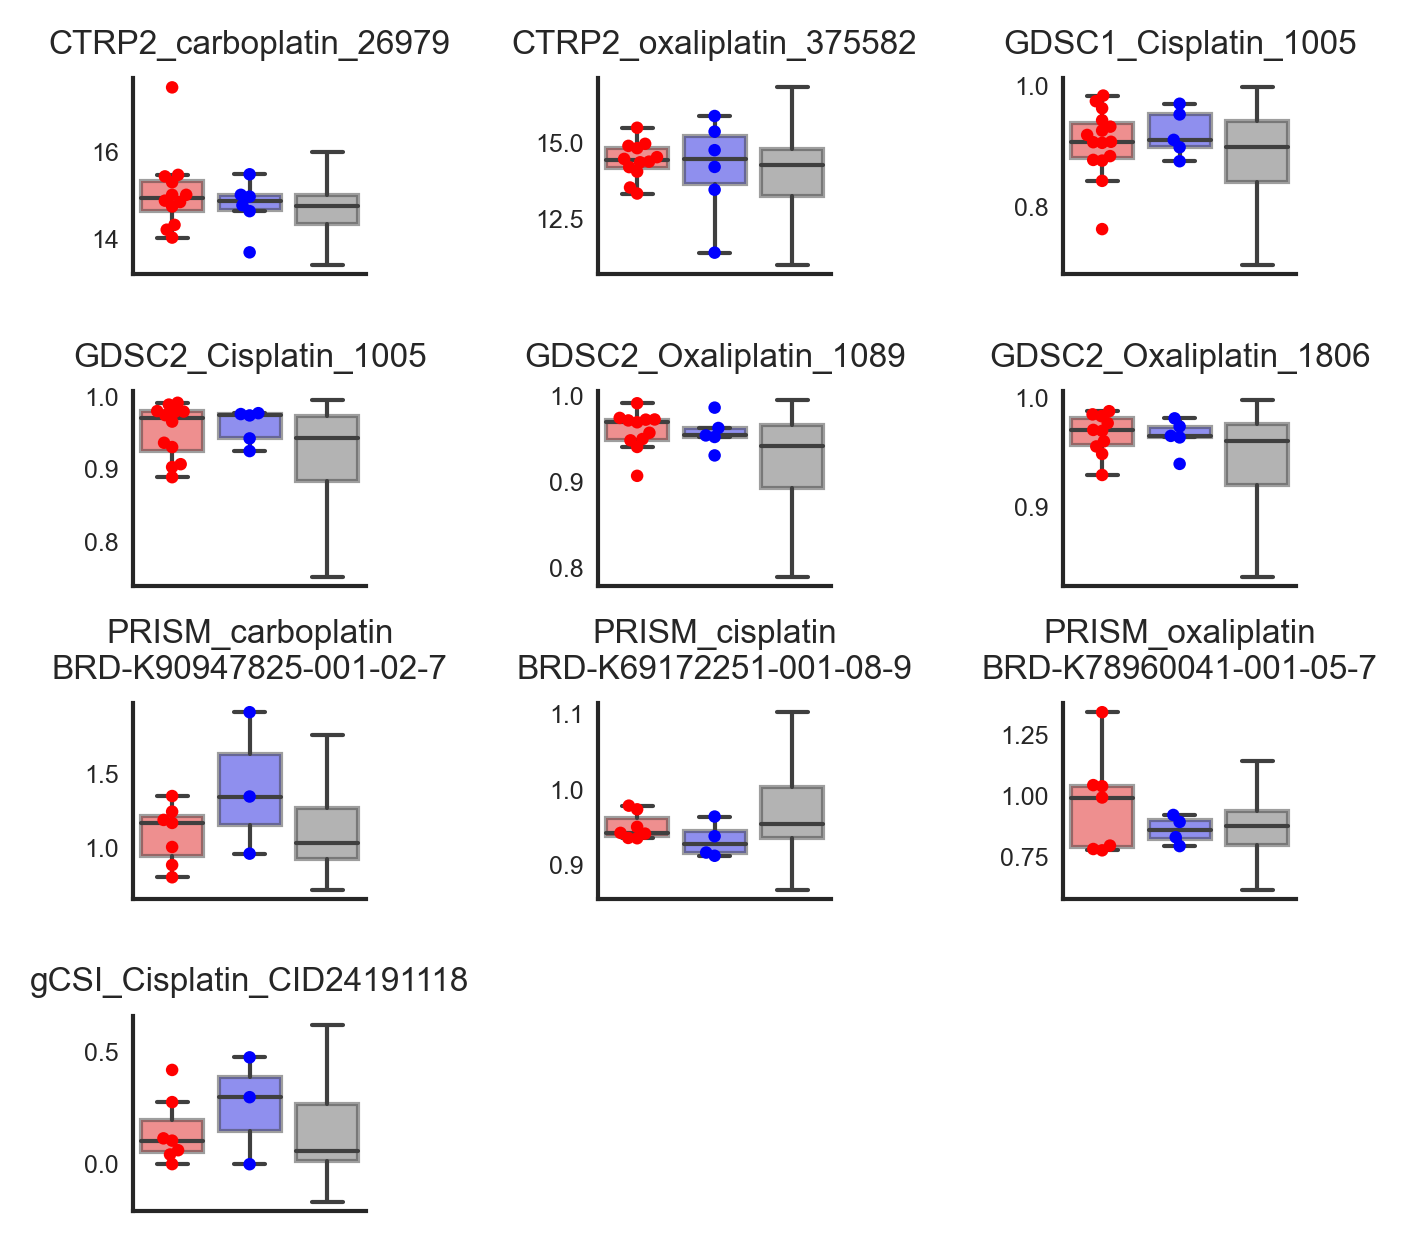

In [114]:
fig=plt.figure(figsize=(5,5))
for i,platinum in enumerate(sorted(platinums)):
    plt_df=df_drug
    cat='BRCA_status2'
    val=platinum
    order=['BRCA1/2_mutations','BRCA1_methylation','wt']
    #hue=
    palette=['red','blue','dimgray']
    ax=fig.add_subplot(4,3,1+i)
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order[:-1]+[None],palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(val,fontsize=8)
    if "PRISM" in val:
        ax.set_title(val.split('_')[0]+'_'+val.split('_')[1]+'\n'+val.split('_')[2])
    
    ax.tick_params(labelsize=6)
    ax.set_xticklabels([])
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    
    a=plt_df[plt_df[cat]==order[0]][val].dropna().values
    b=plt_df[plt_df[cat]==order[1]][val].dropna().values
    c=plt_df[plt_df[cat]==order[2]][val].dropna().values
    _,p1=stats.mannwhitneyu(a,b)
    _,p2=stats.mannwhitneyu(list(a)+list(b),c)
    print(val+'; P = '+str(np.round(p1,3))+','
        #np.round(p2,3)
         )
    
plt.subplots_adjust(hspace=0.6,wspace=1)

CTRP2_olaparib_411867; P = 0.075,
CTRP2_veliparib_606034; P = 0.75,
GDSC1_Olaparib_1017; P = 0.266,
GDSC1_Olaparib_1495; P = 0.622,
GDSC1_Rucaparib_1175; P = 0.306,
GDSC1_Talazoparib_1259; P = 0.168,
GDSC1_Veliparib_1018; P = 0.445,
GDSC2_Niraparib_1177; P = 0.859,
GDSC2_Olaparib_1017; P = 0.574,
GDSC2_Talazoparib_1259; P = 0.661,
PRISM_niraparib_BRD-K54955827-001-02-2; P = 0.932,
PRISM_olaparib_BRD-K02113016-001-15-4; P = 0.57,
PRISM_olaparib_BRD-K02113016-001-19-6; P = 0.748,
PRISM_talazoparib_BRD-K95142244-001-01-5; P = 0.925,


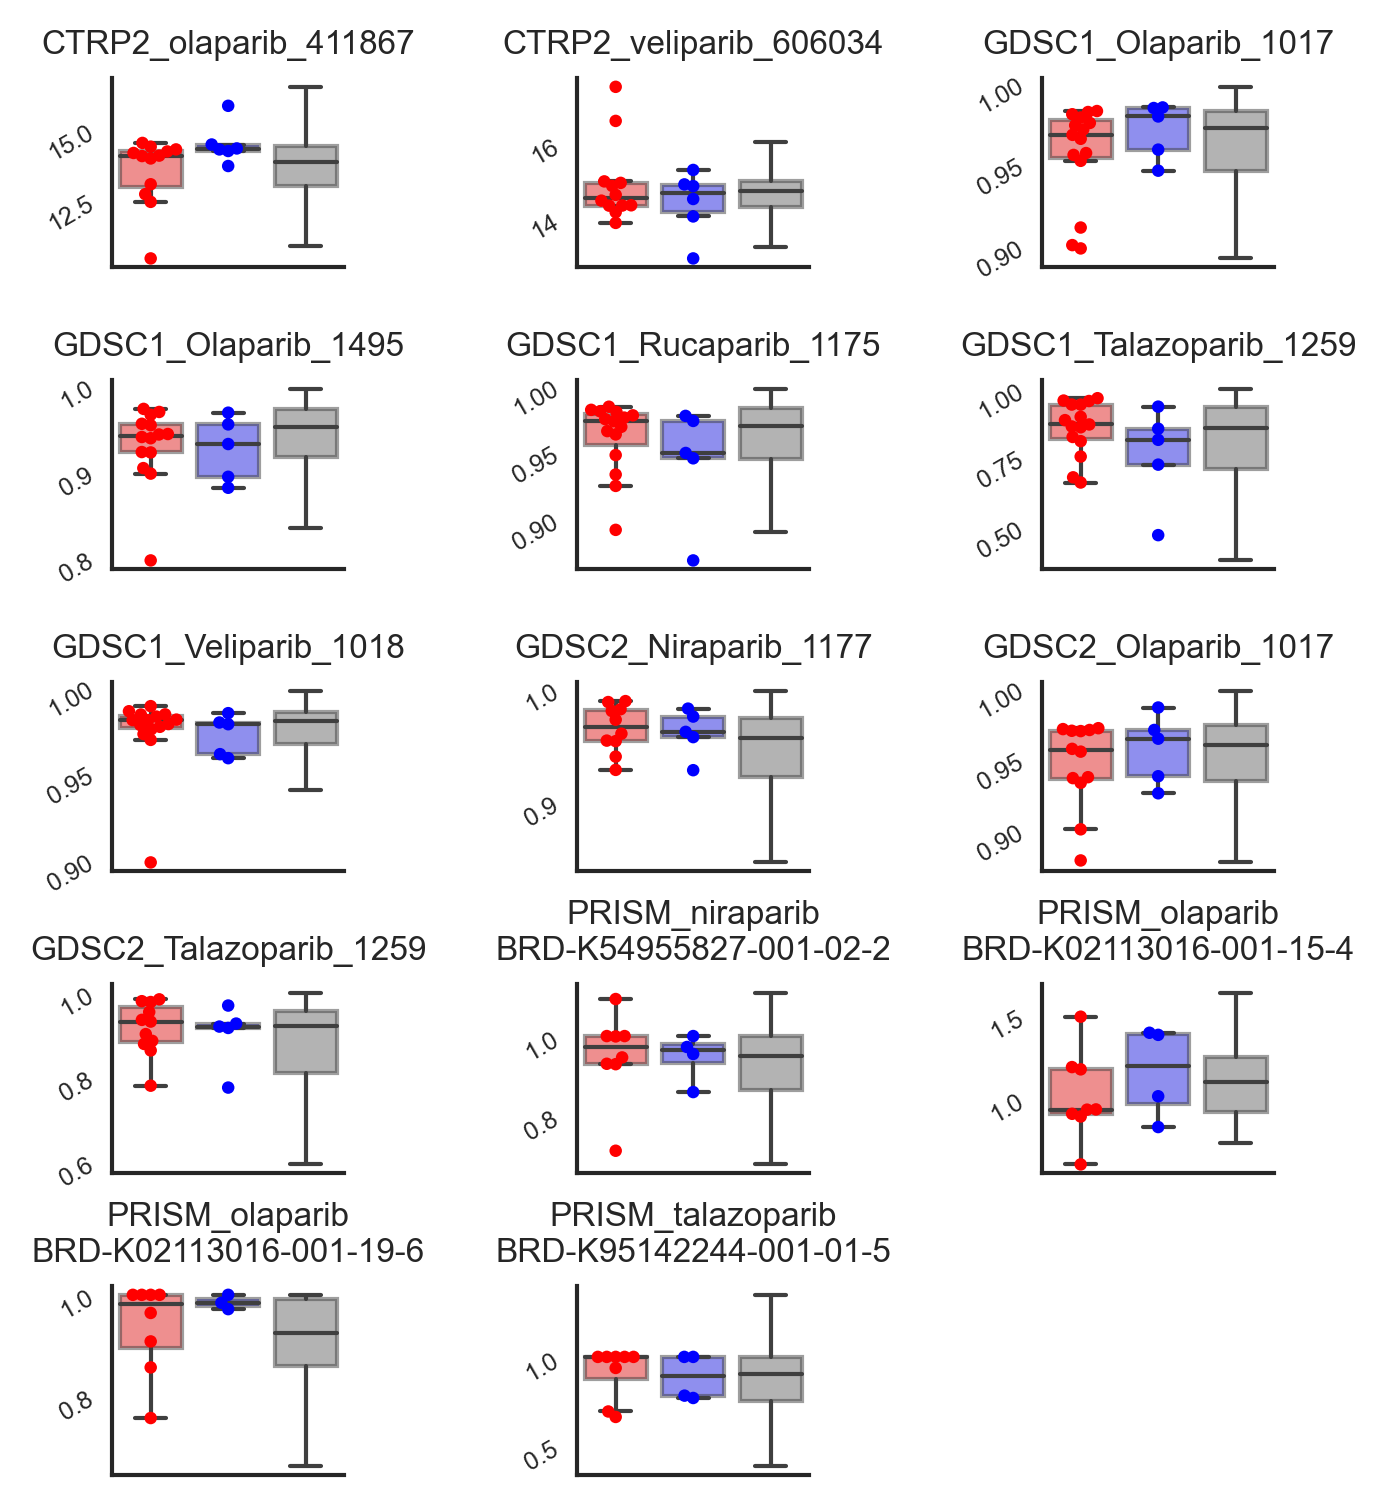

In [115]:
fig=plt.figure(figsize=(5,7.5))
for i,platinum in enumerate(sorted(parpis)):
    plt_df=df_drug
    cat='BRCA_status2'
    val=platinum
    order=['BRCA1/2_mutations','BRCA1_methylation','wt']
    #hue=
    palette=['red','blue','dimgray']
    
    ax=fig.add_subplot(6,3,1+i)
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order[:-1]+[None],palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(val)
    if "PRISM" in val:
        ax.set_title(val.split('_')[0]+'_'+val.split('_')[1]+'\n'+val.split('_')[2])
    
    ax.tick_params(labelsize=6,rotation=30)
    ax.set_xticklabels([])
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)

    a=plt_df[plt_df[cat]==order[0]][val].dropna().values
    b=plt_df[plt_df[cat]==order[1]][val].dropna().values
    c=plt_df[plt_df[cat]==order[2]][val].dropna().values
    if (len(b)>=1):
        _,p1=stats.mannwhitneyu(a,b)
        _,p2=stats.mannwhitneyu(list(a)+list(b),c)
        print(val+'; P = '+str(np.round(p1,3))+','
        #np.round(p2,3)
         )
        
plt.subplots_adjust(hspace=0.6,wspace=1)

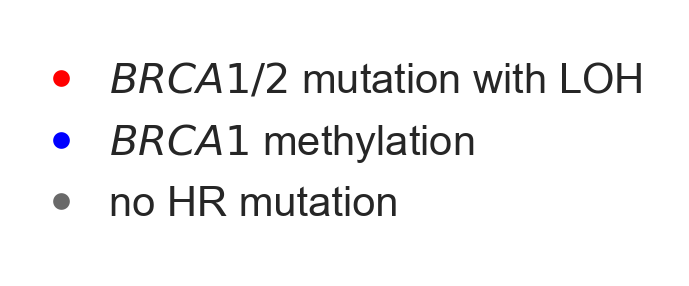

In [123]:
# custom_legend independently
lg_colors=['red','blue','dimgrey']
lg_labels=["$BRCA1/2$ mutation with LOH","$BRCA1$ methylation","no HR mutation"]
lg_number=3

# Marker
from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor=lg_colors[i],markersize=5,# markeredgecolor="k",
                        label=lg_labels[i],
                        color="w"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=0.5) 
plt.gca().set_axis_off()

## Correlations with HRD score and Signature 3

In [124]:
df=df0.copy()

(914, 2)
r = 0.475, p = 1.25e-52


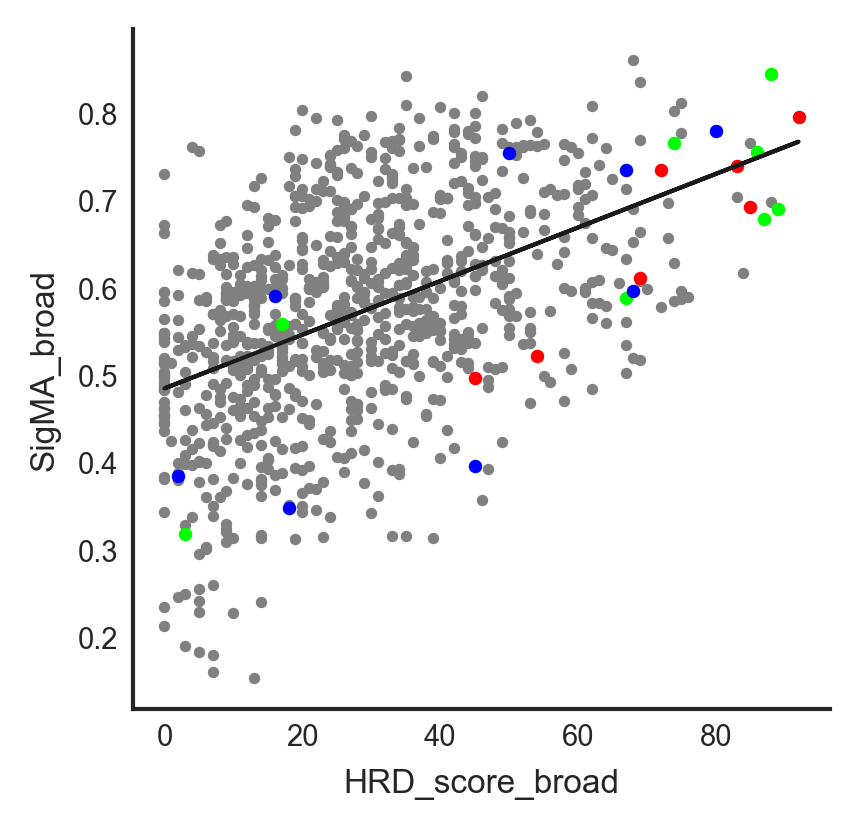

In [125]:
in_df=df.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','SigMA_broad','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

HRR vs Othres 4.680684665526417e-07 15.0
HRR vs wt 4.827793511116703e-06 14.0
BRCA vs wt 1.711964511134235e-06 41.0


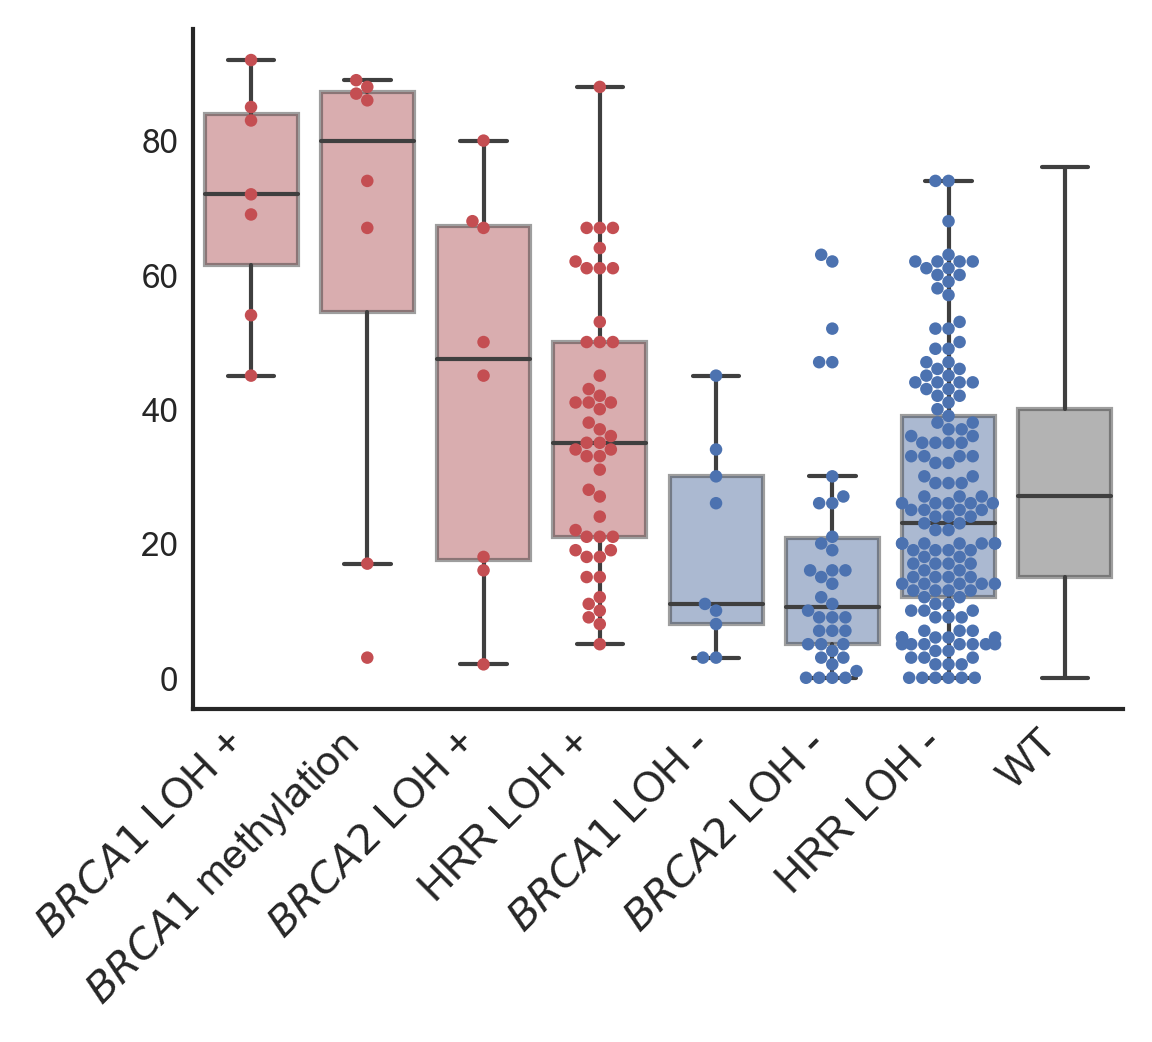

In [130]:
plt_df=df
cat='BRCA_status'
val='HRD_score_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [131]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=59.88053495702631, pvalue=1.5947763165136377e-10)

HRR vs Othres 0.036709259146891535 0.026941492957007984
HRR vs wt 0.10926902551711216 0.022087243589992478
BRCA vs wt 0.023514564126088027 0.06800429042129452


/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


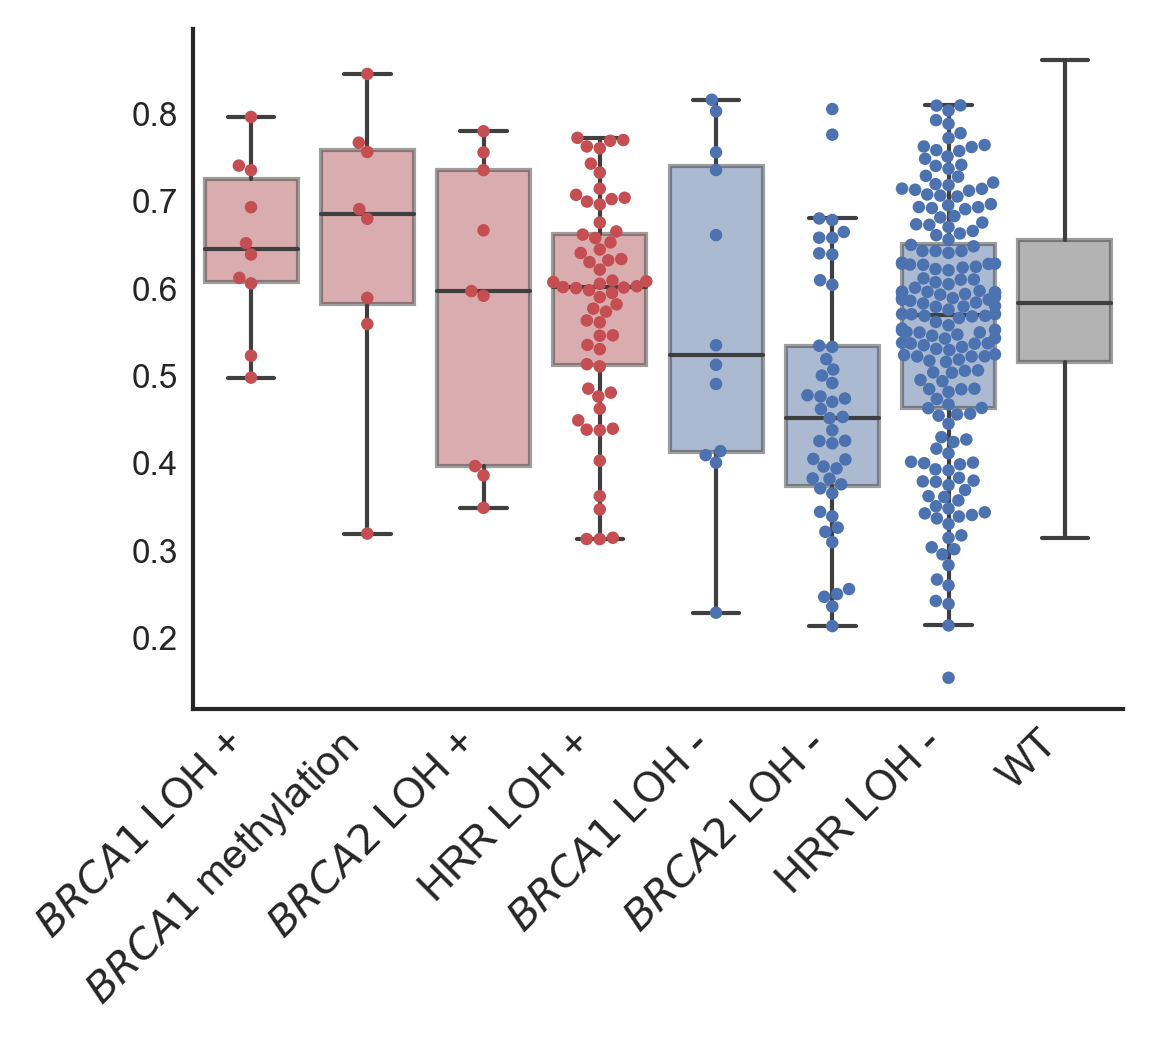

In [132]:
plt_df=df
cat='BRCA_status'
val='SigMA_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [129]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=43.771487527042154, pvalue=2.366206359653691e-07)

## Genomic scar and Drug sensitivity

In [133]:
df=df0.copy()

In [134]:
len(drug_all)

800

### HRD score

In [135]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['HRD_score_broad',drug]].dropna()
    a=plt_df['HRD_score_broad'].values
    b=plt_df[drug].values
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [136]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [90]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [91]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(800, 7)

In [92]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
GDSC2_Cytarabine_1006,36,2.013454e-20,0.390824,19.696058,1,Antimetabolite,6253
GDSC2_Oxaliplatin_1089,36,3.934597e-17,0.349203,16.405100,1,Platinum,5310940
GDSC2_Gemcitabine_1190,36,2.529287e-15,0.336328,14.597002,1,Antimetabolite,60750
GDSC2_Palbociclib_1054,36,8.500994e-15,0.327569,14.070530,1,Cell cycle,5330286
GDSC1_Lestaurtinib_1024,36,1.343798e-14,0.304755,13.871666,1,Others,126565
...,...,...,...,...,...,...,...
gCSI_Gemcitabine_CID356653,36,3.259199e-05,-0.251802,4.486889,1,Antimetabolite,356653
GDSC2_AZD3759_1915,36,2.225128e-05,-0.183950,4.652645,1,EGFR signaling,78209992
GDSC2_Gefitinib_1010,36,6.620194e-06,-0.196131,5.179129,1,EGFR signaling,123631
GDSC2_GDC0810_1925,36,4.165356e-06,-0.200286,5.380348,1,Hormone-related,56941241


In [93]:
NP=len(df_cor_p)
NN=len(df_cor_n)

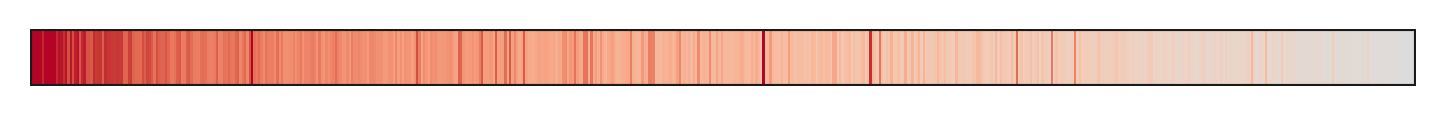

In [94]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

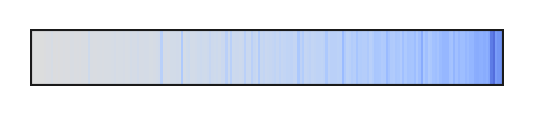

In [95]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

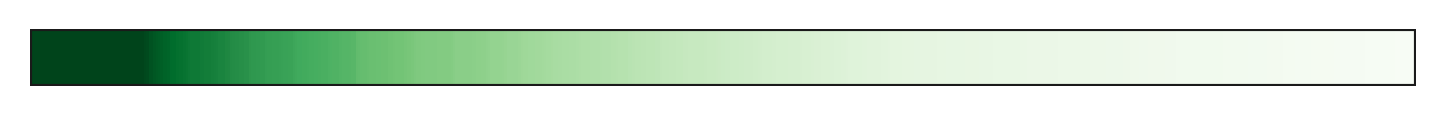

In [96]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

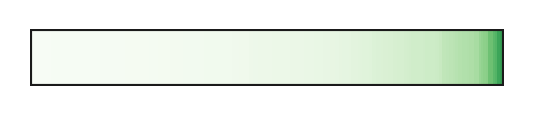

In [97]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

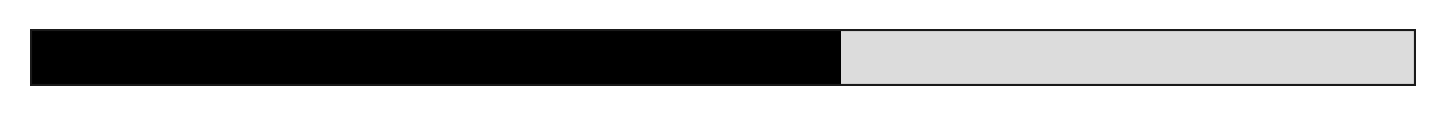

In [98]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

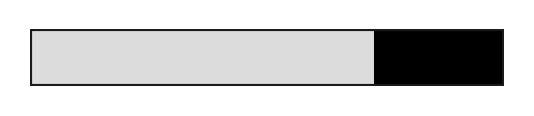

In [99]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [100]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

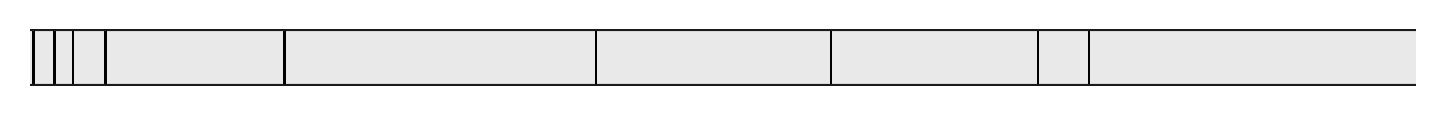

In [101]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

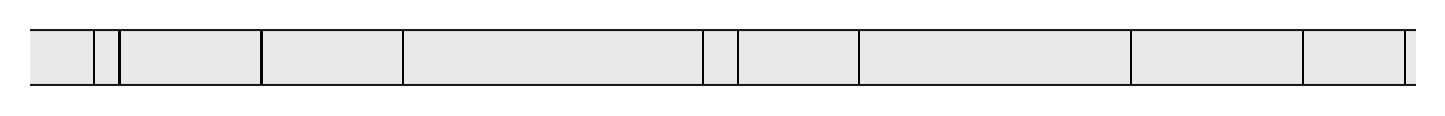

In [102]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


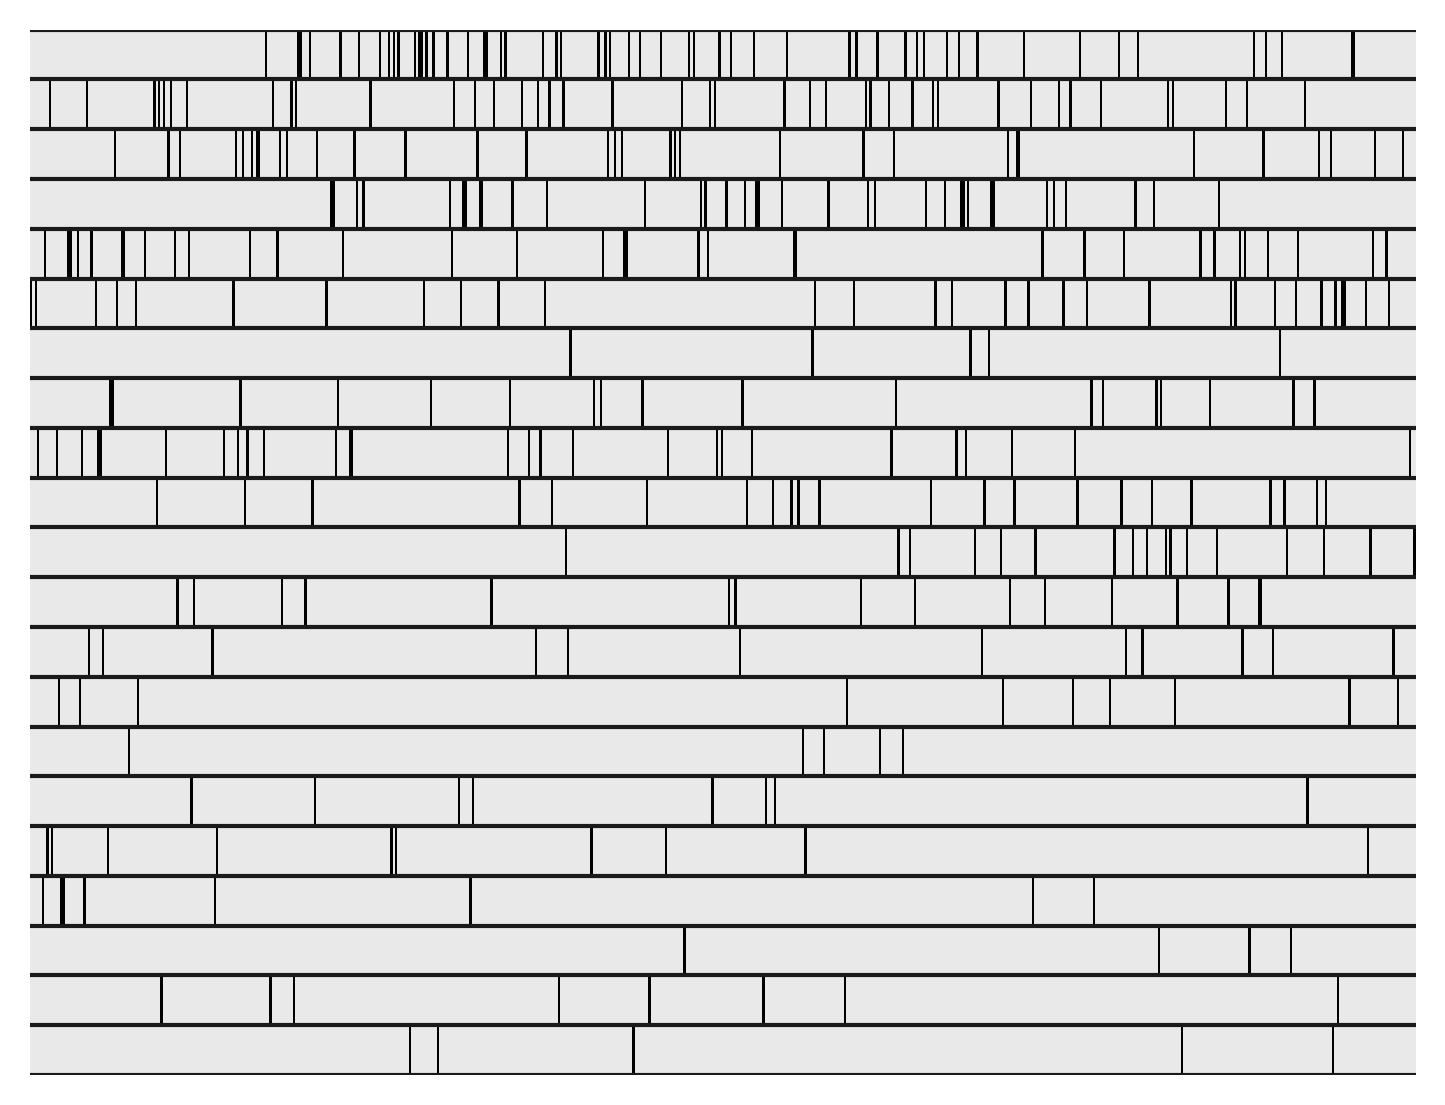

In [103]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [104]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

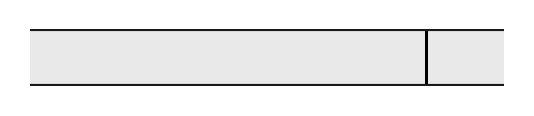

In [105]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

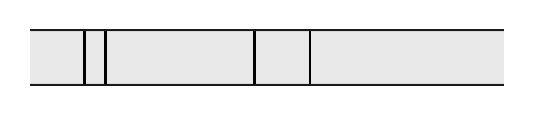

In [106]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

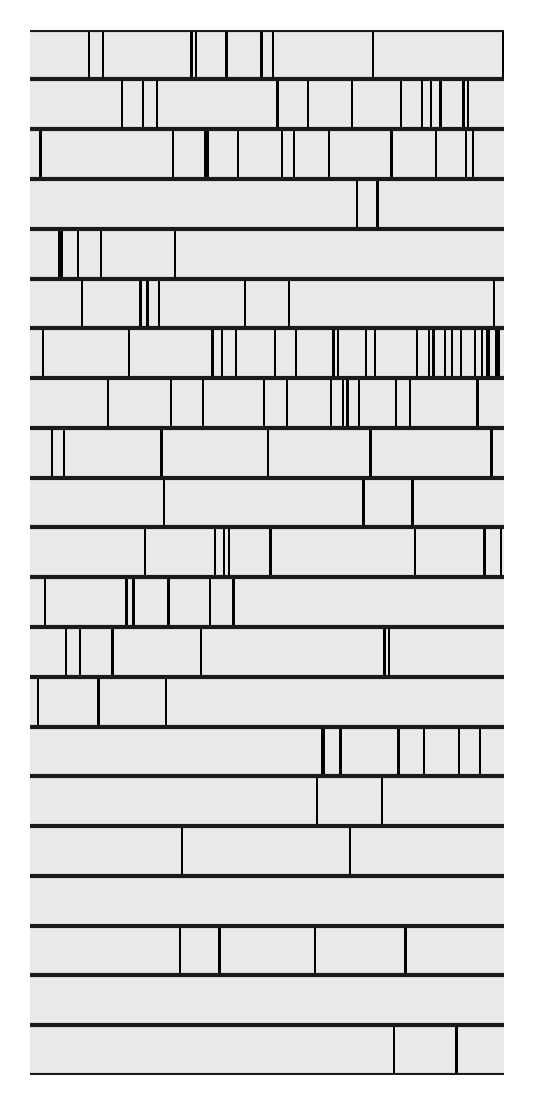

In [107]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [108]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1089,36,3.934597e-17,0.349203,16.405100,1,Platinum,5310940,3.934597e-16
GDSC2_Cisplatin_1005,36,2.019840e-12,0.299180,11.694683,1,Platinum,84691,1.817856e-11
CTRP2_oxaliplatin_375582,36,3.122994e-11,0.242681,10.505429,1,Platinum,24197464,2.498395e-10
GDSC2_Oxaliplatin_1806,36,4.752044e-10,0.275161,9.323120,1,Platinum,5310940,3.326431e-09
CTRP2_carboplatin_26979,36,5.273959e-06,0.166061,5.277863,1,Platinum,38904,3.164333e-05
PRISM_oxaliplatin_BRD-K78960041-001-05-7,36,2.524657e-03,0.145137,2.597798,1,Platinum,24197464,1.255971e-02
GDSC1_Cisplatin_1005,36,4.585888e-02,0.080745,1.338577,1,Platinum,84691,1.313640e-01
gCSI_Cisplatin_CID24191118,36,1.971092e-01,0.079788,0.705293,0,Platinum,24191118,3.553664e-01
PRISM_carboplatin_BRD-K90947825-001-02-7,36,2.524674e-01,0.055566,0.597795,0,Platinum,426756,3.553664e-01
PRISM_cisplatin_BRD-K69172251-001-08-9,36,1.643623e-02,-0.115777,1.784198,1,Platinum,24191118,6.414169e-02


In [109]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Talazoparib_1259,36,2.138063e-10,0.274855,9.669980,1,PARP inhibitor,44819241,2.993288e-09
GDSC2_Niraparib_1177,36,1.607727e-09,0.266131,8.793788,1,PARP inhibitor,24958200,2.090045e-08
GDSC1_Olaparib_1017,36,2.994965e-06,0.187678,5.523608,1,PARP inhibitor,23725625,3.593899e-05
CTRP2_olaparib_411867,36,9.918360e-05,0.142508,4.003560,1,PARP inhibitor,23725625,1.090479e-03
GDSC1_Talazoparib_1259,36,9.937452e-03,0.106240,2.002725,1,PARP inhibitor,44819241,9.504638e-02
GDSC2_Olaparib_1017,36,1.561959e-02,0.105174,1.806330,1,PARP inhibitor,23725625,1.321061e-01
GDSC1_Veliparib_1018,36,6.365140e-02,0.075016,1.196192,0,PARP inhibitor,11960529,4.091183e-01
CTRP2_veliparib_606034,36,3.245377e-01,0.035831,0.488735,0,PARP inhibitor,11960529,8.739109e-01
GDSC1_Rucaparib_1175,36,6.784816e-01,0.016873,0.168462,0,PARP inhibitor,9931953,9.893138e-01
GDSC1_Olaparib_1495,36,9.714994e-01,0.001484,0.012557,0,PARP inhibitor,23725625,9.916375e-01


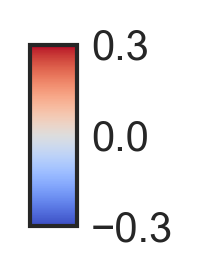

In [110]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("coolwarm")
vmin=-0.3
vmax=0.3
bounds=[-0.3,0,0.3]
fontsize=10
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label,)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

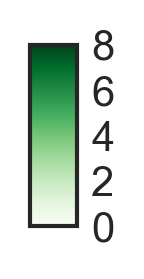

In [111]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("Greens")
vmin=0
vmax=8
bounds=[0,2,4,6,8]
fontsize=10
label=''
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

### Signature 3

In [112]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['SigMA_broad',drug]].dropna()
    a=plt_df['SigMA_broad'].values
    b=plt_df[drug].values
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [113]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [114]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [115]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(800, 7)

In [116]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
GDSC1_VX-11e_262,36,3.749505e-10,0.209589,9.426026,1,ERK MAPK signaling,11634725
GDSC1_(5Z)-7-Oxozeaenol_1242,36,3.496054e-09,0.198648,8.456422,1,Others,9863776
GDSC1_Refametinib_1014,36,9.725182e-09,0.191602,8.012102,1,ERK MAPK signaling,44182295
GDSC1_NVP-BHG712_295,36,1.240118e-08,0.190887,7.906537,1,Others,16747388
GDSC1_CI-1040_1015,36,3.077220e-08,0.184780,7.511841,1,ERK MAPK signaling,6918454
...,...,...,...,...,...,...,...
gCSI_Vincaleukoblastine_CID241902,36,7.811361e-05,-0.287772,4.107273,1,Antimicrotubule,241902
gCSI_Vincristine_CID5978,36,1.024263e-05,-0.206541,4.989589,1,Others,5978
gCSI_Crizotinib_CID54613769,36,4.645823e-06,-0.213535,5.332937,1,RTK signaling,54613769
gCSI_Gemcitabine_CID356653,36,4.299256e-09,-0.338979,8.366607,1,Antimetabolite,356653


In [117]:
NP=len(df_cor_p)
NN=len(df_cor_n)

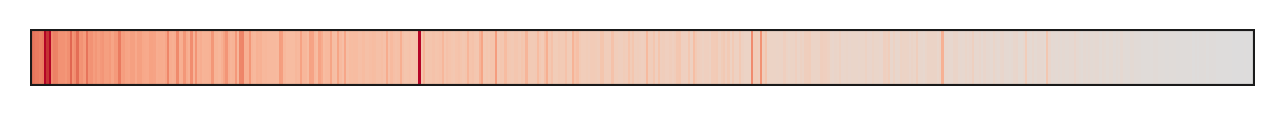

In [118]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

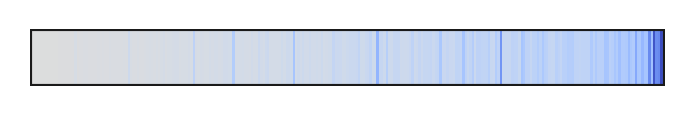

In [119]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

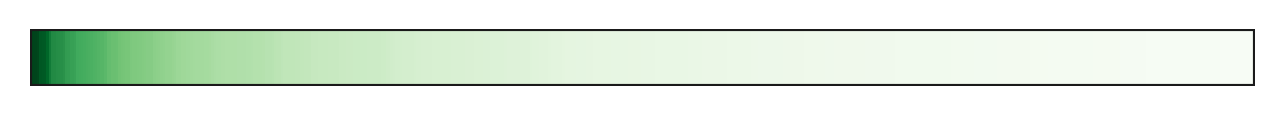

In [120]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

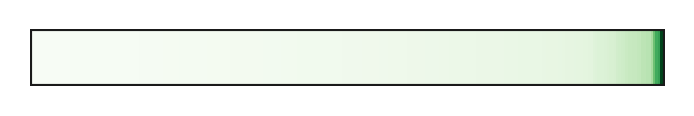

In [121]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

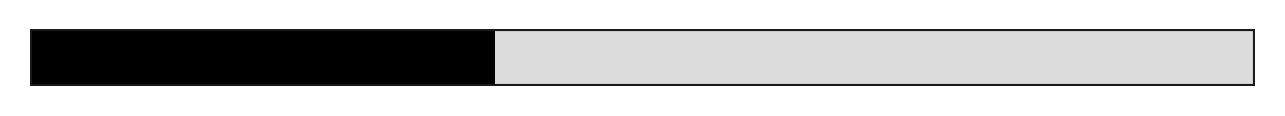

In [122]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

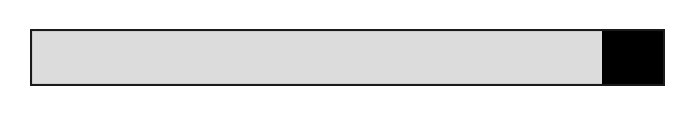

In [123]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [124]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

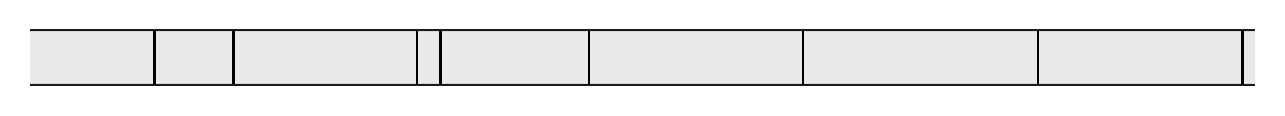

In [125]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

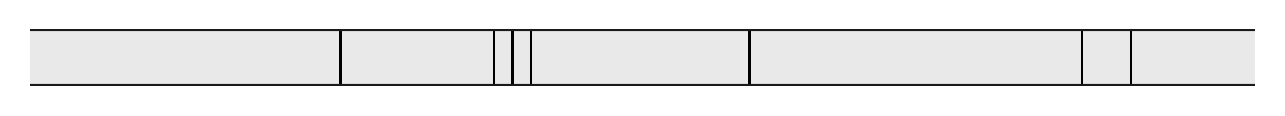

In [126]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

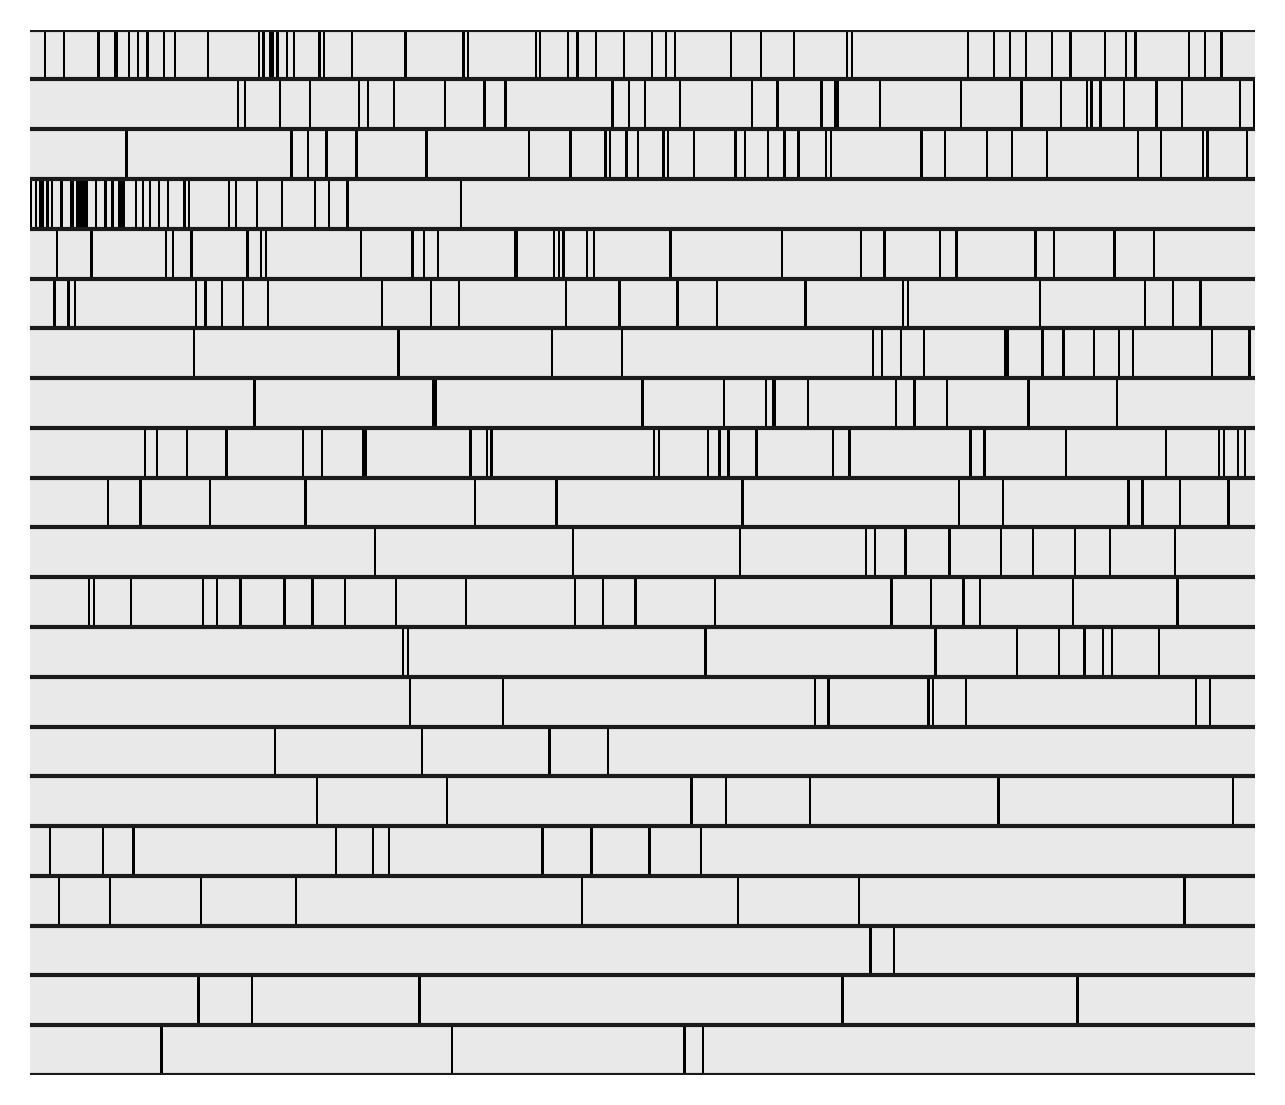

In [127]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [128]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

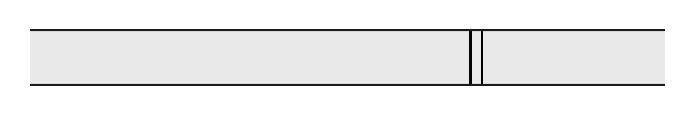

In [129]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

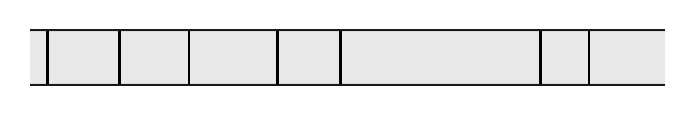

In [130]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

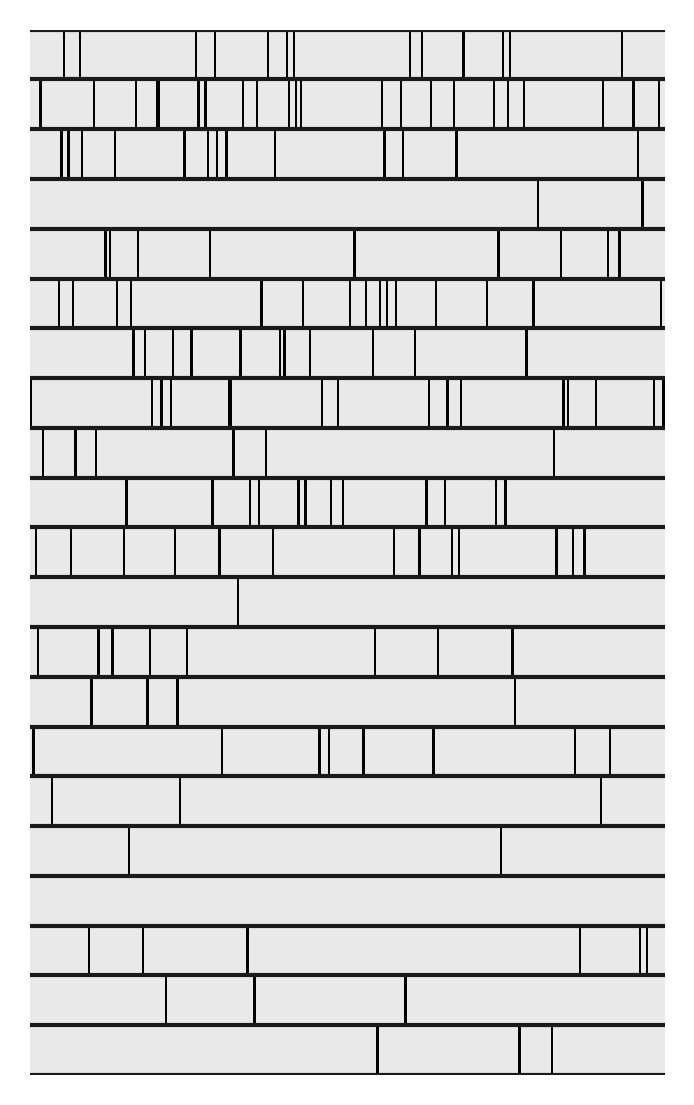

In [131]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [132]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1806,36,0.000319,0.135572,3.496760,1,Platinum,5310940,0.003181
GDSC2_Oxaliplatin_1089,36,0.002280,0.109798,2.641999,1,Platinum,5310940,0.020337
CTRP2_carboplatin_26979,36,0.029960,0.078435,1.523457,1,Platinum,38904,0.215999
GDSC2_Cisplatin_1005,36,0.034544,0.077872,1.461621,1,Platinum,84691,0.218146
GDSC1_Cisplatin_1005,36,0.114076,0.052679,0.942807,0,Platinum,84691,0.516519
CTRP2_oxaliplatin_375582,36,0.314028,0.036690,0.503031,0,Platinum,24197464,0.704164
PRISM_oxaliplatin_BRD-K78960041-001-05-7,36,0.633329,0.022778,0.198371,0,Platinum,24197464,0.865552
gCSI_Cisplatin_CID24191118,36,0.975764,0.001814,0.010655,0,Platinum,24191118,0.975764
PRISM_cisplatin_BRD-K69172251-001-08-9,36,0.226744,-0.057875,0.644465,0,Platinum,24191118,0.704164
PRISM_carboplatin_BRD-K90947825-001-02-7,36,0.216191,-0.059346,0.665162,0,Platinum,426756,0.704164


In [133]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Talazoparib_1259,36,0.011784,0.093882,1.928723,1,PARP inhibitor,44819241,0.152911
GDSC2_Niraparib_1177,36,0.049834,0.074111,1.302474,1,PARP inhibitor,24958200,0.485491
GDSC1_Talazoparib_1259,36,0.057129,0.064632,1.243146,0,PARP inhibitor,44819241,0.506338
GDSC1_Olaparib_1017,36,0.062683,0.062109,1.202850,0,PARP inhibitor,23725625,0.509373
GDSC1_Veliparib_1018,36,0.253318,0.038117,0.596333,0,PARP inhibitor,11960529,0.903376
GDSC1_Olaparib_1495,36,0.692911,0.013454,0.159322,0,PARP inhibitor,23725625,0.996842
PRISM_olaparib_BRD-K02113016-001-19-6,36,0.772159,0.014086,0.112293,0,PARP inhibitor,23725625,0.996842
CTRP2_veliparib_606034,36,0.984998,-0.000673,0.006565,0,PARP inhibitor,11960529,0.996842
GDSC2_Olaparib_1017,36,0.841268,-0.007415,0.075066,0,PARP inhibitor,23725625,0.996842
PRISM_niraparib_BRD-K54955827-001-02-2,36,0.683858,-0.019015,0.165034,0,PARP inhibitor,24958200,0.996842


# Exclusively in Breast and Ovarysel_cancer

In [137]:
df_sel=df0[df0['primary_disease'].isin(['Ovarian Cancer','Breast Cancer'])]
df_sel

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,primary_or_metastasis,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues,PLOIDY,PURITY,MUTATION_RATE,DOUBLING_TIME_FROM_VENDOR,DOUBLING_TIME,GENOME_DOUBLINGS,SigMA_broad,BRCA1,BRCA2,ATM,ATR,BARD1,BLM,BRIP1,CDK12,CHEK1,CHEK2,FANCA,FANCC,FANCD2,FANCE,FANCF,...,CTRP2_vandetanib_349002,CTRP2_veliparib_606034,CTRP2_vincristine_62602,CTRP2_vorapaxar_660136,CTRP2_vorinostat_56554,gCSI_Tanespimycin_CID6505803,gCSI_5-Fluorouracil_CID3385,gCSI_AZ-628_CID11676786,gCSI_AZD7762_CID11152667,gCSI_AZD8055_CID25262965,gCSI_Azacitidine_CID9444,gCSI_Bortezomib_CID387447,gCSI_Bosutinib_CID5328940,gCSI_Chir-99021_CID9956119,gCSI_Cisplatin_CID24191118,gCSI_Crizotinib_CID54613769,gCSI_Dabrafenib_CID44462760,gCSI_Dasatinib_CID3062316,gCSI_Docetaxel_CID148124,gCSI_Erastin_CID11214940,gCSI_Erlotinib_CID176871,gCSI_Etoposide_CID36462,gCSI_GSK2636771_CID56949517,gCSI_Gefitinib_CID123631,gCSI_Gemcitabine_CID356653,gCSI_Ibrutinib_CID24821094,gCSI_JQ1 compound_CID71300862,gCSI_Lapatinib_CID208908,gCSI_Lenalidomide_CID216326,gCSI_MI-2_CID54765302,gCSI_MK-2206_CID46930998,gCSI_MLN2480_CID25161177,gCSI_Methotrexate_CID126941,gCSI_NU-7441_CID11327430,gCSI_Narciclasine_CID72376,gCSI_Nilotinib_CID644241,gCSI_Oligomycin A_CID5472285,gCSI_PF-4708671_CID51371303,gCSI_PLX4720_CID24180719,gCSI_Paclitaxel_CID36314,gCSI_Palbociclib_CID5330286,gCSI_TGX221_CID9907093,gCSI_Tivantinib_CID11494412,gCSI_Vincaleukoblastine_CID241902,gCSI_Vincristine_CID5978,gCSI_Vorinostat_CID5311,HRD_score_broad,BRCA1_methylation,BRCA_status,BRCA_alteration
DepMap_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACH-000288,BT-549,BT549,BT549_BREAST,NaN,905951,Female,ATCC,CVCL_1092,1835.0,breast,Primary,Breast Cancer,Breast Ductal Carcinoma,72,SIDM00122,NaN,breast,breast_ductal_carcinoma,ERneg_HER2neg,basal_B,2D: adherent,NaN,NaN,PT-hgWgpg,NaN,Invasive breast carcinoma of no special type,C4194,NaN,1.34,1.00,100.467969,NaN,98.4,0.0,0.585270,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,13.512,14.589,9.5835,13.323,13.623,NaN,NaN,-0.065000,NaN,NaN,0.506444,NaN,NaN,NaN,0.353556,0.001889,0.111111,0.139,0.641000,0.199222,0.079778,NaN,0.228111,NaN,0.620889,0.032000,0.041000,0.152778,0.011444,0.207667,NaN,0.037333,0.860333,0.199222,0.908222,NaN,0.530444,0.051333,NaN,0.796556,0.014333,0.211778,0.516778,0.343222,0.384444,0.212000,19.0,0.0,wt,0
ACH-000333,JHOM-2B,JHOM2B,JHOM2B_OVARY,NaN,-1,Female,RIKEN,CVCL_4645,NaN,ovary,Primary,Ovarian Cancer,"Adenocarcinoma, mucinous",56,NaN,NaN,ovary,ovary_adenocarcinoma,mucinous,NaN,NaN,NaN,NaN,PT-60XjJv,NaN,Ovarian mucinous adenocarcinoma,C5243,NaN,2.05,1.00,142.741222,NaN,NaN,0.0,0.476021,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,0.0,wt,0
ACH-000635,SNU-119,SNU119,SNU119_OVARY,NaN,-1,Female,KCLB,CVCL_5014,NaN,ascites,Metastasis,Ovarian Cancer,"Cystadenocarcinoma, high grade serous",50,NaN,NaN,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,NaN,NaN,NaN,PT-vHYCC2,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN,3.12,0.99,171.736406,53 hrs,NaN,1.0,0.678921,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,10.976,14.526,7.6589,14.809,13.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,1.0,BRCA1_methylation,1
ACH-001719,OCI-C4P,OCIC4P,OCIC4P_OVARY,NaN,-1,Female,Academic lab,CVCL_DH05,NaN,ovary,Primary,Ovarian Cancer,"Adenocarc

In [138]:
Counter(df_sel['BRCA_alteration'])

Counter({0: 99, 1: 17})

In [139]:
df_drug=df_sel[~df_sel[drug_all].isna().all(axis=1)]

In [140]:
df_drug.shape

(108, 1035)

## BRCA status vs Drug sensitivity

### BRCA12 altaration

In [141]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum()

16

In [142]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])].shape

(92, 1035)

In [143]:
df_drug[df_drug['BRCA_status'].isin(['wt'])].shape

(68, 1035)

In [144]:
df=df_drug.copy()

In [145]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [146]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps
df_cor=df_cor.dropna()

In [147]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [148]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
CTRP2_oxaliplatin_375582,28,0.002000,0.365505,0.457829,0.339296,0,Platinum,DNA alkylator; organoplatinum reagent,24197464
CTRP2_etoposide_48589,28,-0.126500,0.240341,0.866321,0.062321,0,DNA inhibitor,inhibitor of topoisomerase II,36462
CTRP1_navitoclax_362342,28,-0.977350,-0.103742,0.443928,0.352687,0,Apoptosis regulation,"inhibitor of BCL2, BCL-xL and BCL-W",24978538
GDSC2_Alisertib_1051,28,0.015879,0.028308,0.251934,0.598713,0,Others,Mitosis,24771867
GDSC1_Afatinib_1032,28,0.005548,0.029673,0.664386,0.177580,0,EGFR signaling,EGFR signaling,10184653
...,...,...,...,...,...,...,...,...,...
CTRP1_vorinostat_56554,28,2.067150,0.973113,0.256622,0.590706,0,Chromatin-related,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, HDAC8",5311
GDSC1_Bleomycin (50 uM)_1378,28,-0.022340,0.015772,0.890209,0.050508,0,DNA inhibitor,DNA replication,5460769
GDSC2_LCL161_1557,28,-0.001769,0.019304,0.866047,0.062458,0,Apoptosis regulation,Apoptosis regulation,24737642
PRISM_regorafenib_BRD-K16730910-001-07-3,28,0.174466,0.075189,0.363784,0.439157,0,Others,"FGFR inhibitor, KIT inhibitor, PDGFR tyrosine ...",11167602


In [149]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
GDSC1_Vorinostat_1012,28,0.111457,0.121888,0.002021,2.694373,1,Chromatin-related,Chromatin histone acetylation,5311
GDSC1_AZD8055_1059,28,0.081386,0.071590,0.006866,2.163313,1,PI3K/MTOR signaling,PI3K/MTOR signaling,25262965
GDSC2_Navitoclax_1011,28,0.077244,0.090903,0.017603,1.754406,1,Apoptosis regulation,Apoptosis regulation,24978538
GDSC1_Dactolisib_1057,28,0.112065,0.092064,0.017810,1.749340,1,PI3K/MTOR signaling,PI3K/MTOR signaling,11977753
PRISM_abemaciclib_BRD-K33622447-066-01-9,28,0.060837,0.096869,0.019117,1.718581,1,Cell cycle,CDK inhibitor,46220502
...,...,...,...,...,...,...,...,...,...
CTRP2_cyanoquinoline 11_417415,28,-0.654000,-0.661560,0.026553,1.575882,1,Others,inhibitor of MAP3K8; inhibitor of phosphorylat...,-1
GDSC1_Vinorelbine_140,28,-0.171084,-0.137701,0.013642,1.865112,1,Antimicrotubule,Mitosis,5311497
GDSC2_AZD5582_1617,28,-0.262659,-0.173516,0.011261,1.948442,1,Apoptosis regulation,Apoptosis regulation,49847690
CTRP2_birinapant_660778,28,-1.352000,-1.458120,0.010527,1.977710,1,Others,SMAC mimetic; inhibitor of inhibitor of apopto...,49836020


In [99]:
NP=len(df_cor_p)
NN=len(df_cor_n)

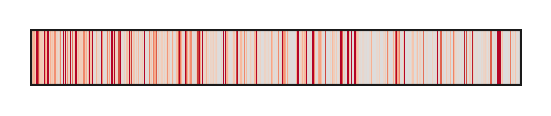

In [100]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

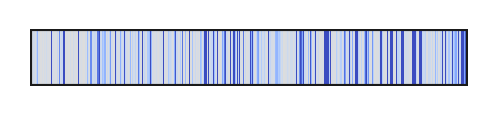

In [101]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

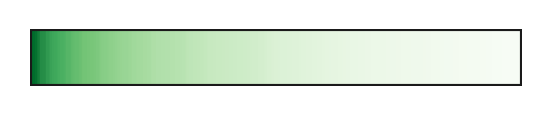

In [102]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=2,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

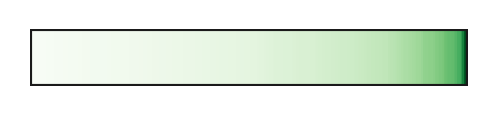

In [103]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=2,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

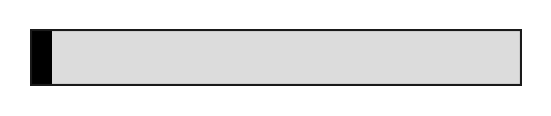

In [104]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

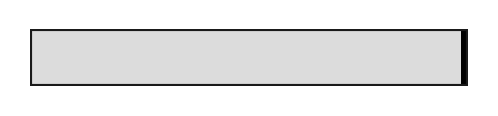

In [105]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [106]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

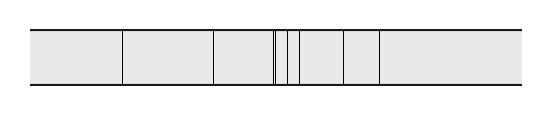

In [107]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

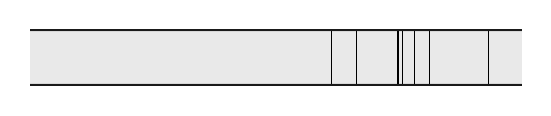

In [108]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [109]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

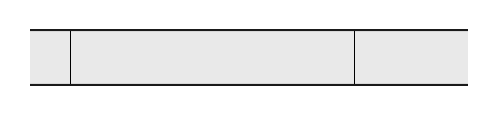

In [110]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

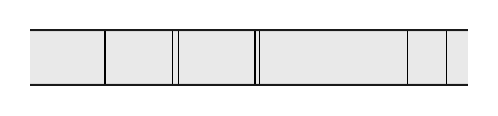

In [111]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [112]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_35867/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1089,15,0.010165,0.023036,0.158084,0.801111,0,Platinum,5310940,0.821069
PRISM_oxaliplatin_BRD-K78960041-001-05-7,15,0.052101,0.070142,0.318137,0.497386,0,Platinum,24197464,0.968138
GDSC1_Cisplatin_1005,15,0.007052,0.016001,0.452705,0.344185,0,Platinum,84691,0.985292
CTRP2_oxaliplatin_375582,15,0.002000,0.365505,0.457829,0.339296,0,Platinum,24197464,0.985292
PRISM_carboplatin_BRD-K90947825-001-02-7,15,0.125770,0.166115,0.478318,0.320284,0,Platinum,426756,0.985292
GDSC2_Oxaliplatin_1806,15,0.003053,0.015113,0.499709,0.301282,0,Platinum,5310940,0.985292
GDSC2_Cisplatin_1005,15,0.009957,0.011970,0.606429,0.217220,0,Platinum,84691,0.985292
CTRP2_carboplatin_26979,15,0.047000,-0.192754,0.695130,0.157934,0,Platinum,38904,0.985292
gCSI_Cisplatin_CID24191118,15,-0.025444,0.002227,0.911468,0.040259,0,Platinum,24191118,0.985292
PRISM_cisplatin_BRD-K69172251-001-08-9,15,-0.021881,-0.108718,0.347861,0.458594,0,Platinum,24191118,0.968138


In [113]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_35867/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
PRISM_niraparib_BRD-K54955827-001-02-2,15,0.000882,-0.006946,0.574478,0.240727,0,PARP inhibitor,24958200,0.999888
CTRP2_veliparib_606034,15,0.100500,0.004351,0.649024,0.187739,0,PARP inhibitor,11960529,0.999919
CTRP2_olaparib_411867,15,0.116000,-0.143277,0.740745,0.130331,0,PARP inhibitor,23725625,0.999919
GDSC1_Veliparib_1018,15,0.000513,0.002802,0.751204,0.124242,0,PARP inhibitor,11960529,0.999919
GDSC2_Niraparib_1177,15,0.001367,0.007262,0.765283,0.116178,0,PARP inhibitor,24958200,0.999919
GDSC1_Rucaparib_1175,15,0.005778,0.003404,0.795340,0.099447,0,PARP inhibitor,9931953,0.999919
PRISM_olaparib_BRD-K02113016-001-19-6,15,0.033195,-0.016343,0.938846,0.027406,0,PARP inhibitor,23725625,0.999919
PRISM_talazoparib_BRD-K95142244-001-01-5,15,-0.142761,-0.019207,0.852933,0.069085,0,PARP inhibitor,135565082,0.999919
GDSC2_Talazoparib_1259,15,-0.006032,0.014635,0.710365,0.148518,0,PARP inhibitor,44819241,0.999919
GDSC1_Olaparib_1017,15,-0.004335,0.004226,0.688798,0.161908,0,PARP inhibitor,23725625,0.999919


### HRR alteration

In [162]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

25

In [163]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])].shape

(83, 1035)

In [164]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [165]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps
df_cor=df_cor.dropna()

In [166]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [167]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Dinaciclib_1180,36,0.095126,0.047613,0.331884,0.479013,0,Cell cycle,46926350
GDSC1_Dactolisib_1057,36,0.100806,0.054001,0.033310,1.477427,1,PI3K/MTOR signaling,11977753
GDSC1_Navitoclax_1011,36,-0.003509,0.006614,0.783448,0.105990,0,Apoptosis regulation,24978538
GDSC2_KRAS (G12C) Inhibitor-12_1855,36,-0.028484,-0.002778,0.697915,0.156198,0,ERK MAPK signaling,73555129
PRISM_carmustine_BRD-K36234266-001-09-8,36,0.003238,0.067991,0.622048,0.206176,0,DNA alkylator,2578
...,...,...,...,...,...,...,...,...
PRISM_vinflunine_BRD-K64120610-001-01-4,36,-0.029752,-0.003245,0.628566,0.201649,0,Antimicrotubule,6918295
CTRP2_AZD1480_660306,36,-0.172500,0.457795,0.908591,0.041631,0,Others,16659841
GDSC1_Axitinib_1021,36,0.010408,0.003523,0.339305,0.469410,0,RTK signaling,6450551
GDSC2_RO-3306_1052,36,0.007607,0.020431,0.414144,0.382848,0,Cell cycle,44450571


In [168]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Buparlisib_1873,36,0.050812,0.056758,0.002875,2.541320,1,PI3K/MTOR signaling,16654980
GDSC1_TW 37_1149,36,0.153210,0.108045,0.003116,2.506339,1,Apoptosis regulation,11455910
GDSC1_Vorinostat_1012,36,0.088250,0.096527,0.004635,2.333971,1,Chromatin-related,5311
GDSC1_CCT-018159_1170,36,0.043502,0.034026,0.006062,2.217366,1,Protein stability and degradation,5327091
PRISM_abemaciclib_BRD-K33622447-066-01-9,36,0.060837,0.091808,0.007618,2.118175,1,Cell cycle,46220502
...,...,...,...,...,...,...,...,...
PRISM_anagrelide_BRD-K62200014-003-10-5,36,-0.044036,-0.065025,0.019693,1.705686,1,Others,135409400
gCSI_Dabrafenib_CID44462760,36,-0.033778,-0.107826,0.012348,1.908413,1,ERK MAPK signaling,44462760
CTRP2_cyanoquinoline 11_417415,36,-0.573000,-0.653835,0.005778,2.238204,1,Others,-1
CTRP2_birinapant_660778,36,-1.464500,-1.702507,0.001571,2.803799,1,Others,49836020


In [169]:
NP=len(df_cor_p)
NN=len(df_cor_n)

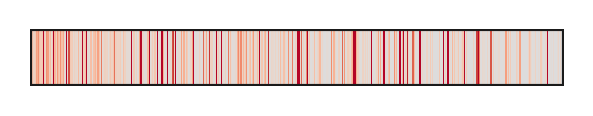

In [170]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

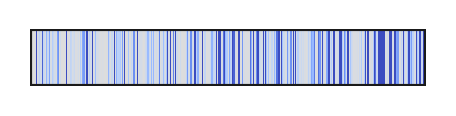

In [171]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

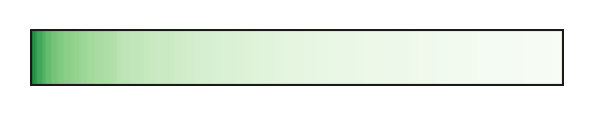

In [172]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

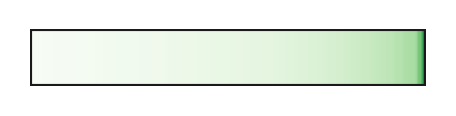

In [173]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

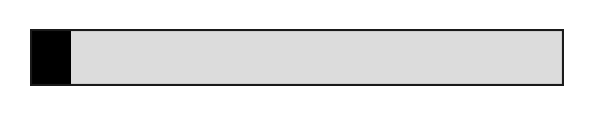

In [174]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

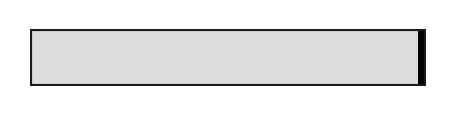

In [175]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [176]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

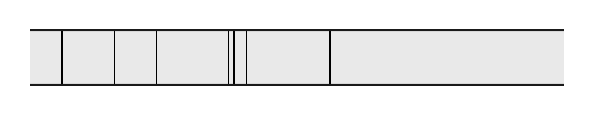

In [177]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

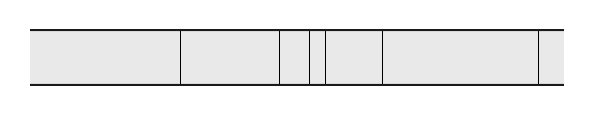

In [178]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [179]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

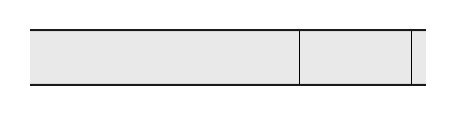

In [180]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

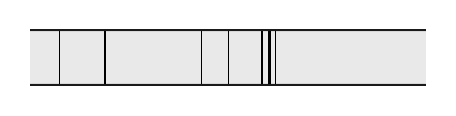

In [181]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [182]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
PRISM_oxaliplatin_BRD-K78960041-001-05-7,36,0.082144,0.132910,0.041479,1.382167,1,Platinum,24197464,0.345342
PRISM_carboplatin_BRD-K90947825-001-02-7,36,0.203643,0.180027,0.107249,0.969607,0,Platinum,426756,0.596500
GDSC2_Oxaliplatin_1089,36,0.010165,0.019404,0.186487,0.729351,0,Platinum,5310940,0.764196
CTRP2_oxaliplatin_375582,36,0.191000,0.374090,0.313295,0.504047,0,Platinum,24197464,0.895137
GDSC1_Cisplatin_1005,36,0.013929,0.015475,0.321850,0.492346,0,Platinum,84691,0.895137
gCSI_Cisplatin_CID24191118,36,0.158889,0.074390,0.333299,0.477167,0,Platinum,24191118,0.895137
GDSC2_Oxaliplatin_1806,36,0.004583,0.008705,0.496994,0.303649,0,Platinum,5310940,0.895137
GDSC2_Cisplatin_1005,36,0.007706,0.010610,0.497160,0.303504,0,Platinum,84691,0.895137
PRISM_cisplatin_BRD-K69172251-001-08-9,36,-0.021881,-0.064648,0.346971,0.459706,0,Platinum,24191118,0.895137
CTRP2_carboplatin_26979,36,-0.179000,-0.427786,0.091295,1.039552,0,Platinum,38904,0.577520


In [183]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Talazoparib_1259,36,0.021160,0.023576,0.224362,0.649051,0,PARP inhibitor,44819241,0.971475
GDSC1_Rucaparib_1175,36,0.006450,0.006751,0.393617,0.404927,0,PARP inhibitor,9931953,0.998501
CTRP2_olaparib_411867,36,0.061500,-0.194652,0.456745,0.340326,0,PARP inhibitor,23725625,0.998501
GDSC2_Niraparib_1177,36,0.004267,0.009930,0.494310,0.306001,0,PARP inhibitor,24958200,0.998501
PRISM_olaparib_BRD-K02113016-001-19-6,36,0.026362,-0.031064,0.601834,0.220523,0,PARP inhibitor,23725625,0.998501
PRISM_talazoparib_BRD-K95142244-001-01-5,36,0.015037,0.010431,0.950374,0.022106,0,PARP inhibitor,135565082,0.998501
GDSC1_Veliparib_1018,36,-0.000031,0.004012,0.903346,0.044146,0,PARP inhibitor,11960529,0.998501
GDSC1_Olaparib_1017,36,-0.002336,0.005082,0.803157,0.095200,0,PARP inhibitor,23725625,0.998501
GDSC1_Olaparib_1495,36,-0.010069,-0.007203,0.554169,0.256358,0,PARP inhibitor,23725625,0.998501
GDSC2_Olaparib_1017,36,-0.004052,-0.002076,0.503178,0.298278,0,PARP inhibitor,23725625,0.998501


## Correlations with HRD score and Signature 3

In [150]:
df=df_sel.copy()

(99, 2)
r = 0.634, p = 1.90e-12


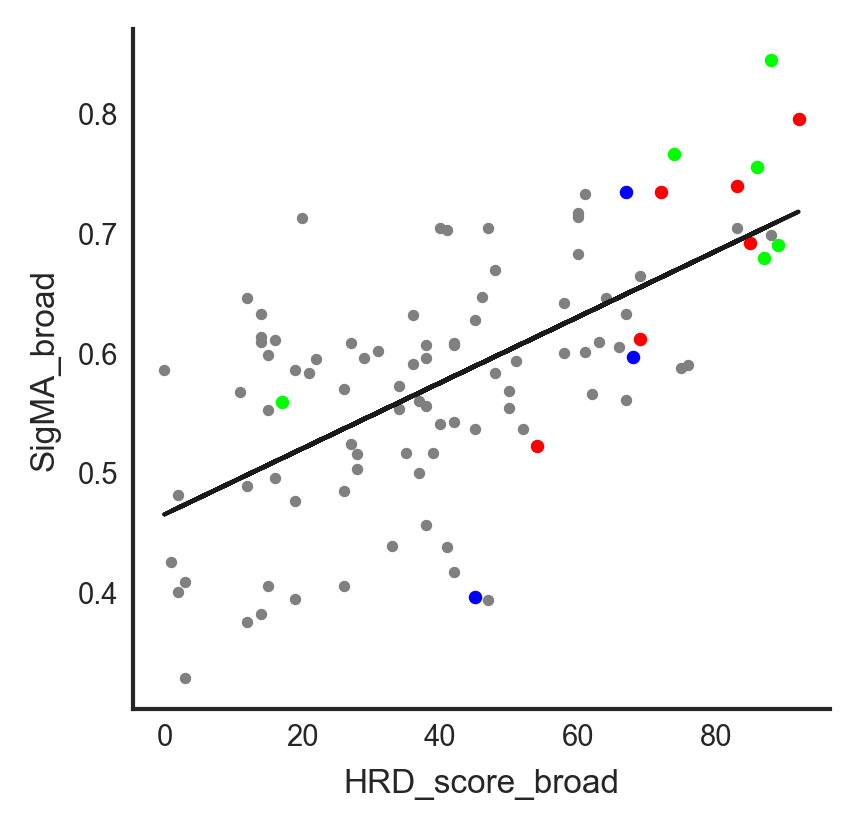

In [151]:
in_df=df.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','SigMA_broad','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

HRR vs Othres 5.096749526637539e-07 31.5
HRR vs wt 2.255130988107182e-06 31.0
BRCA vs wt 3.0114173442951655e-06 37.5


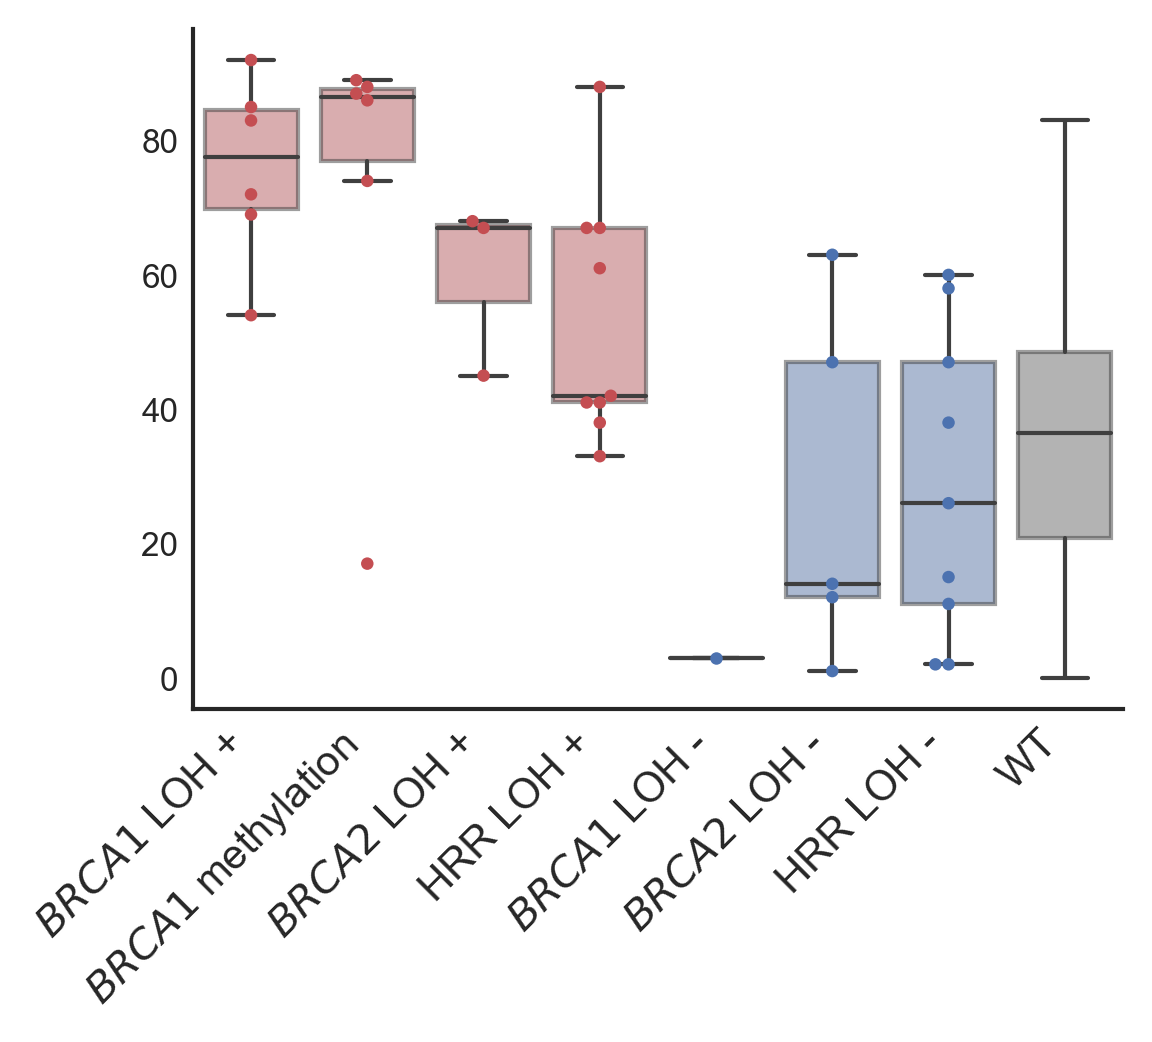

In [153]:
plt_df=df
cat='BRCA_status'
val='HRD_score_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [154]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=31.26904176084953, pvalue=5.545657348159652e-05)

HRR vs Othres 0.0010494558401414943 0.0522348042720715
HRR vs wt 0.0037558247124579794 0.049039637722632534
BRCA vs wt 0.0007909757453843045 0.10359156904573408


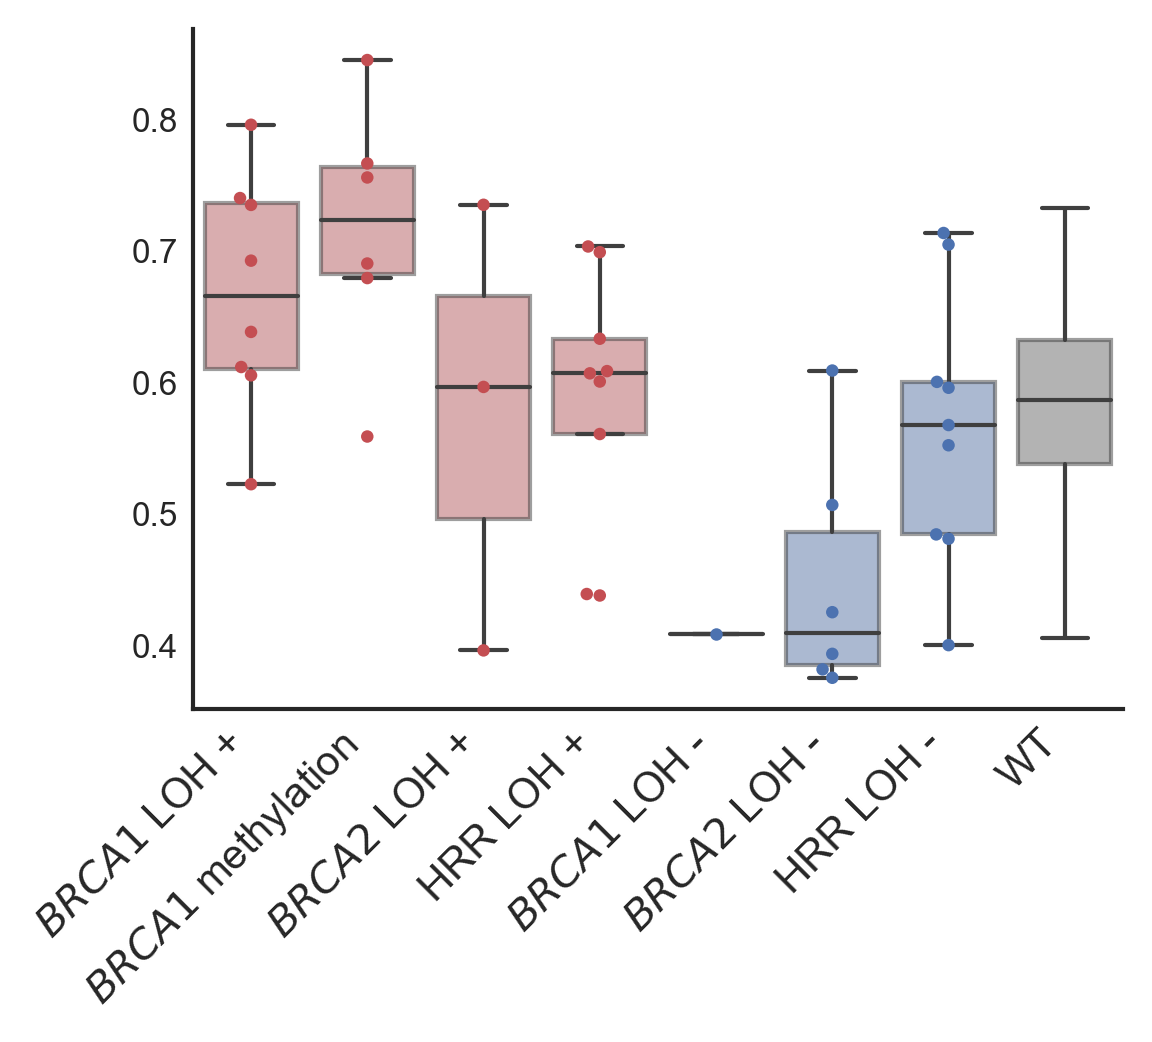

In [155]:
plt_df=df
cat='BRCA_status'
val='SigMA_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [156]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=23.744083363433845, pvalue=0.001263537339758994)

## Genomic scar and Drug sensitivity

In [188]:
df=df_sel.copy()

In [189]:
len(drug_all)

800

### HRD score

In [190]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['HRD_score_broad',drug]].dropna()
    a=plt_df['HRD_score_broad'].values
    b=plt_df[drug].values
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [191]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [192]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [193]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(800, 7)

In [194]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
PRISM_temsirolimus_BRD-K42898655-001-01-8,36,3.588127e-08,0.681959,7.445132,1,PI3K/MTOR signaling,6918289
PRISM_abemaciclib_BRD-K33622447-066-01-9,36,2.597013e-06,0.604783,5.585526,1,Cell cycle,46220502
PRISM_palbociclib_BRD-K51313569-001-07-8,36,3.090147e-06,0.627248,5.510021,1,Cell cycle,5330286
GDSC1_Temsirolimus_1016,36,1.321755e-05,0.491887,4.878849,1,PI3K/MTOR signaling,6918289
GDSC2_Palbociclib_1054,36,3.896096e-05,0.473946,4.409370,1,Cell cycle,5330286
...,...,...,...,...,...,...,...
GDSC1_TGX221_94,36,4.220666e-02,-0.569464,1.374619,1,PI3K/MTOR signaling,9907093
CTRP2_cimetidine_26870,36,3.988074e-02,-0.441112,1.399237,1,Others,2756
GDSC1_Navitoclax_1011,36,2.238452e-02,-0.270757,1.650052,1,Apoptosis regulation,24978538
GDSC1_Cyclopamine_17,36,1.845272e-02,-0.664336,1.733940,1,Others,442972


In [195]:
NP=len(df_cor_p)
NN=len(df_cor_n)

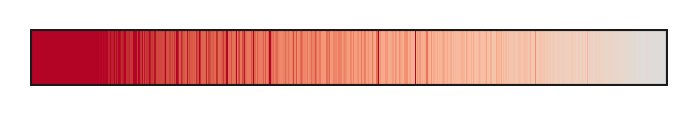

In [196]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

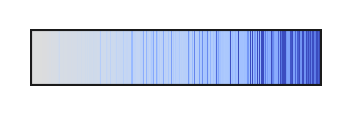

In [197]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

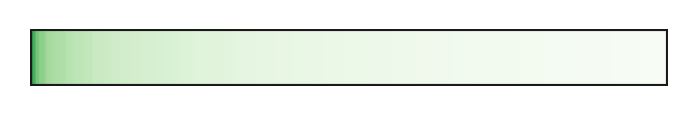

In [198]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

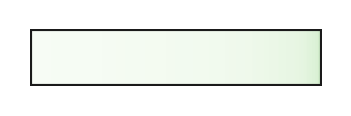

In [199]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

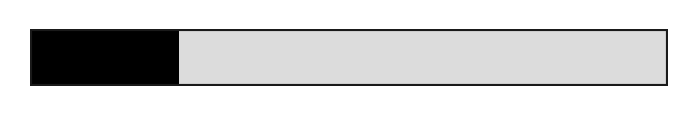

In [200]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

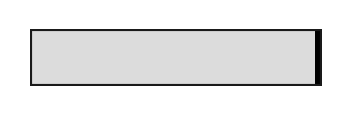

In [201]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [202]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

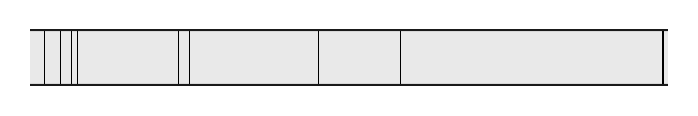

In [203]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

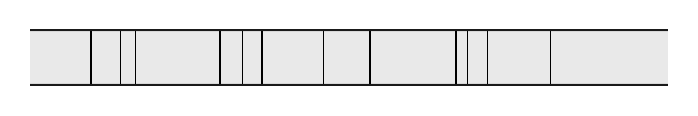

In [204]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [205]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

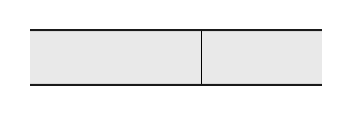

In [206]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

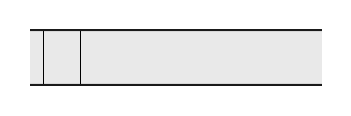

In [207]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [208]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1089,36,0.000419,0.418854,3.377486,1,Platinum,5310940,0.004185
GDSC2_Cisplatin_1005,36,0.002283,0.363919,2.641421,1,Platinum,84691,0.020364
CTRP2_oxaliplatin_375582,36,0.004257,0.335310,2.370910,1,Platinum,24197464,0.033552
GDSC1_Cisplatin_1005,36,0.005416,0.326756,2.266346,1,Platinum,84691,0.037299
PRISM_oxaliplatin_BRD-K78960041-001-05-7,36,0.049683,0.281945,1.303792,1,Platinum,24197464,0.263435
GDSC2_Oxaliplatin_1806,36,0.058763,0.251860,1.230900,0,Platinum,5310940,0.263435
gCSI_Cisplatin_CID24191118,36,0.188469,0.175158,0.724760,0,Platinum,24191118,0.566269
PRISM_carboplatin_BRD-K90947825-001-02-7,36,0.326072,0.144816,0.486686,0,Platinum,426756,0.693917
CTRP2_carboplatin_26979,36,0.996255,0.000563,0.001629,0,Platinum,38904,0.996255
PRISM_cisplatin_BRD-K69172251-001-08-9,36,0.498919,-0.101102,0.301970,0,Platinum,24191118,0.748918


In [209]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Niraparib_1177,36,0.007916,0.348370,2.101478,1,PARP inhibitor,24958200,0.105302
GDSC2_Talazoparib_1259,36,0.019768,0.293034,1.704040,1,PARP inhibitor,44819241,0.228606
PRISM_talazoparib_BRD-K95142244-001-01-5,36,0.024192,0.315348,1.616320,1,PARP inhibitor,135565082,0.254633
GDSC1_Olaparib_1017,36,0.073520,0.213717,1.133594,0,PARP inhibitor,23725625,0.568286
PRISM_olaparib_BRD-K02113016-001-19-6,36,0.095593,0.248694,1.019575,0,PARP inhibitor,23725625,0.633866
GDSC2_Olaparib_1017,36,0.120454,0.191557,0.919180,0,PARP inhibitor,23725625,0.684987
CTRP2_olaparib_411867,36,0.195534,0.152181,0.708777,0,PARP inhibitor,23725625,0.824588
GDSC1_Veliparib_1018,36,0.263300,0.134540,0.579549,0,PARP inhibitor,11960529,0.882230
GDSC1_Talazoparib_1259,36,0.433229,0.095878,0.363282,0,PARP inhibitor,44819241,0.966853
PRISM_niraparib_BRD-K54955827-001-02-2,36,0.461107,0.107764,0.336198,0,PARP inhibitor,24958200,0.966853


### Signature 3

In [210]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['SigMA_broad',drug]].dropna()
    a=plt_df['SigMA_broad'].values
    b=plt_df[drug].values
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [211]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [212]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [213]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(800, 7)

In [214]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
PRISM_temsirolimus_BRD-K42898655-001-01-8,36,6.775541e-07,0.631386,6.169056,1,PI3K/MTOR signaling,6918289
PRISM_everolimus_BRD-K13514097-001-05-3,36,1.606182e-04,0.528338,3.794205,1,PI3K/MTOR signaling,6442177
CTRP2_vorinostat_56554,36,6.975187e-04,0.387872,3.156444,1,Chromatin-related,5311
CTRP2_LBH-589_54210,36,8.993108e-04,0.375562,3.046090,1,Chromatin-related,6918837
GDSC2_Uprosertib_1553,36,1.450035e-03,0.368448,2.838621,1,PI3K/MTOR signaling,51042438
...,...,...,...,...,...,...,...
CTRP2_AZD7762_660777,36,3.181448e-02,-0.251543,1.497375,1,Cell cycle,11152667
CTRP1_BMS-641988_411807,36,3.048136e-02,-0.416972,1.515966,1,Hormone-related,24768935
GDSC2_WIKI4_1940,36,2.355341e-02,-0.264840,1.627946,1,WNT signaling,2984337
GDSC2_SB216763_1025,36,1.804950e-02,-0.347271,1.743535,1,WNT signaling,176158


In [215]:
# NP=len(df_cor_p)
NN=len(df_cor_n)

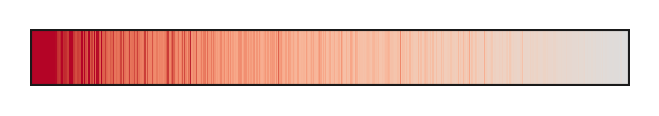

In [216]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

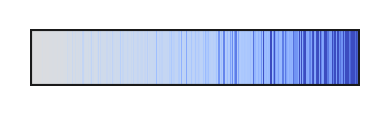

In [217]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

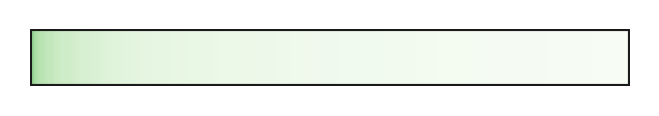

In [218]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

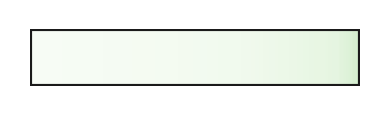

In [219]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

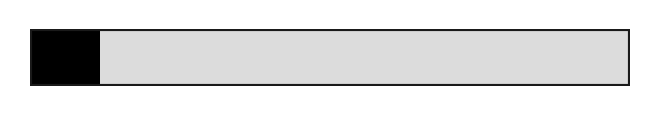

In [220]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

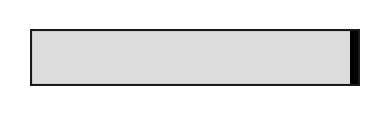

In [221]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [222]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

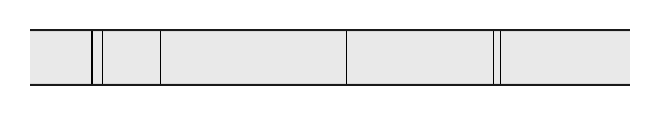

In [223]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

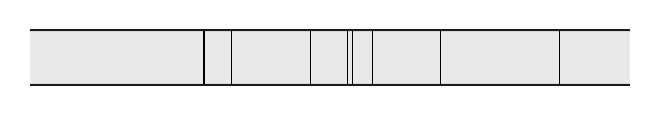

In [224]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [225]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

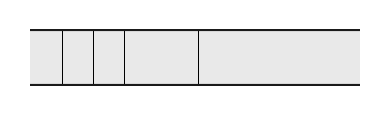

In [226]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

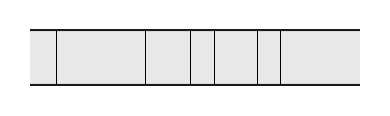

In [227]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(4*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [228]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
gCSI_Cisplatin_CID24191118,36,0.040138,0.261414,1.396439,1,Platinum,24191118,0.336126
CTRP2_oxaliplatin_375582,36,0.053889,0.228171,1.268498,0,Platinum,24197464,0.392596
GDSC2_Oxaliplatin_1089,36,0.124181,0.176718,0.905944,0,Platinum,5310940,0.653810
PRISM_oxaliplatin_BRD-K78960041-001-05-7,36,0.450118,0.110408,0.346674,0,Platinum,24197464,0.984798
GDSC1_Cisplatin_1005,36,0.703646,0.042118,0.152646,0,Platinum,84691,0.997714
GDSC2_Oxaliplatin_1806,36,0.723594,0.044359,0.140505,0,Platinum,5310940,0.997714
GDSC2_Cisplatin_1005,36,0.927942,-0.010407,0.032479,0,Platinum,84691,0.997714
PRISM_cisplatin_BRD-K69172251-001-08-9,36,0.825943,-0.032956,0.083050,0,Platinum,24191118,0.997714
CTRP2_carboplatin_26979,36,0.760439,-0.036301,0.118935,0,Platinum,38904,0.997714
PRISM_carboplatin_BRD-K90947825-001-02-7,36,0.547408,-0.089014,0.261689,0,Platinum,426756,0.991405


In [229]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
PRISM_talazoparib_BRD-K95142244-001-01-5,36,0.179022,0.191164,0.747093,0,PARP inhibitor,135565082,0.936811
GDSC1_Veliparib_1018,36,0.241886,0.129088,0.616389,0,PARP inhibitor,11960529,0.972676
GDSC2_Niraparib_1177,36,0.378274,0.111101,0.422193,0,PARP inhibitor,24958200,0.991370
CTRP2_olaparib_411867,36,0.450553,0.088436,0.346254,0,PARP inhibitor,23725625,0.995436
PRISM_olaparib_BRD-K02113016-001-19-6,36,0.457656,0.112249,0.339461,0,PARP inhibitor,23725625,0.995436
PRISM_niraparib_BRD-K54955827-001-02-2,36,0.483596,0.102457,0.315518,0,PARP inhibitor,24958200,0.995436
GDSC2_Talazoparib_1259,36,0.613376,0.060551,0.212273,0,PARP inhibitor,44819241,0.995436
GDSC1_Olaparib_1017,36,0.822780,0.024805,0.084716,0,PARP inhibitor,23725625,0.995436
GDSC1_Rucaparib_1175,36,0.939894,-0.008457,0.026921,0,PARP inhibitor,9931953,0.995436
PRISM_olaparib_BRD-K02113016-001-15-4,36,0.727821,-0.052729,0.137975,0,PARP inhibitor,23725625,0.995436


# COSMIC

In [157]:
df2=pd.read_csv('../processed_data/CCLE_cosmic.txt',sep='\t',index_col=0)
df2.shape

(1020, 94)

In [158]:
df2=df2.merge(prism,left_on='ACH_ID',right_index=True,how='left')
df2=df2.merge(gdsc1,left_index=True,right_index=True,how='left')
df2=df2.merge(gdsc2,left_index=True,right_index=True,how='left')
df2=df2.merge(ctrp1,left_on='stripped_cell_line_name',right_index=True,how='left')
df2=df2.merge(ctrp2,left_on='stripped_cell_line_name',right_index=True,how='left')
df2=df2.merge(gcsi,left_on='stripped_cell_line_name',right_index=True,how='left')

In [159]:
brca1_met=[]
for idx in df2.index:
    if df2.loc[idx,'BRCA1_methylation_cosmic_likely']==1:
        brca1_met.append(1)
    elif df2.loc[idx,'BRCA1_methylation_broad']==1:
        brca1_met.append(1)
    elif df2.loc[idx,'BRCA1_methylation_cosmic_likely']==0:
        brca1_met.append(0)
    elif df2.loc[idx,'BRCA1_methylation_broad']==0:
        brca1_met.append(0)
    else:
        brca1_met.append(np.nan)
df2['BRCA1_methylation']=brca1_met

In [160]:
df2=df2.rename(columns={'HRD_score':'HRD_score_cosmic'})

In [161]:
brca_status=[]
for idx in df2.index:
    if df2.loc[idx,'BRCA1']=='LOH':
        brca_status.append('BRCA1_LOH')
    elif df2.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df2.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df2.loc[idx,'BRCA1_methylation']==1:
        brca_status.append('BRCA1_methylation')
    elif df2.loc[idx,'otherHRR_LOH']==1:
        brca_status.append('HRR_LOH')
    elif df2.loc[idx,'BRCA1']=='unknown':
        brca_status.append('BRCA1_unknown')
    elif df2.loc[idx,'otherHRR_unknown']==1:
        brca_status.append('HRR_unknown')
    elif df2.loc[idx,'BRCA1']=='nonLOH':
        brca_status.append('BRCA1_nonLOH')
    elif df2.loc[idx,'BRCA2']=='nonLOH':
        brca_status.append('BRCA2_nonLOH')
    elif df2.loc[idx,'otherHRR_nonLOH']==1:
        brca_status.append('HRR_nonLOH')
    elif (df2.loc[idx,'BRCA1']=='wt')&(df2.loc[idx,'BRCA2']=='wt')&(df2.loc[idx,'BRCA1_methylation']==0):
        brca_status.append('wt')
    else:
        brca_status.append(np.nan)

In [162]:
df2['BRCA_status']=brca_status
Counter(df2['BRCA_status']).most_common()

[('wt', 777),
 ('HRR_nonLOH', 119),
 (nan, 38),
 ('HRR_LOH', 32),
 ('BRCA2_nonLOH', 27),
 ('BRCA2_LOH', 10),
 ('BRCA1_nonLOH', 8),
 ('BRCA1_methylation', 5),
 ('BRCA1_LOH', 4)]

In [163]:
df2=df2[(df2['BRCA_status'].isna()==False)]
df2.shape

(982, 978)

In [164]:
df2['BRCA_alteration']=((df2['BRCA1_LOH']==1)|(df2['BRCA1_methylation']==1)|(df2['BRCA2_LOH']==1)).astype(int)

In [165]:
(df2['BRCA_alteration']==1).sum()

19

In [166]:
(~df2['HRD_score_cosmic'].isna()).sum()

978

In [167]:
(~df2['SigMA_cosmic'].isna()).sum()

977

## BRCA status vs Drug sensitivity

In [168]:
drug_gdsc1=set(df2.columns[df2.columns.str.startswith('GDSC1')])
drug_gdsc2=set(df2.columns[df2.columns.str.contains('GDSC2')])
drug_ctrp1=set(df2.columns[df2.columns.str.contains('CTRP1')])
drug_ctrp2=set(df2.columns[df2.columns.str.contains('CTRP2')])
drug_prism=set(df2.columns[df2.columns.str.startswith("PRISM")])
drug_gcsi=set(df2.columns[df2.columns.str.contains('gCSI')])

In [169]:
drug_total=drug_gdsc1|drug_gdsc2|drug_ctrp1|drug_ctrp2|drug_prism|drug_gcsi
len(drug_total)

882

In [170]:
## assays with fewer than 10 samples with HR-related gene alterations were excluded fo analysis
drug_all=[]
drug_exc=[]
for drug in drug_total:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    n=len(a)
    if n >=10:
        drug_all.append(drug)
    else:
        drug_exc.append(drug)

In [171]:
len(drug_all)

669

In [172]:
len(drug_exc)

213

In [173]:
df_drug=df2[~df2[drug_all].isna().all(axis=1)]
df_drug=df_drug.loc[:,~df_drug.columns.isin(drug_exc)]
df_drug.shape

(975, 766)

In [174]:
platinums=set(df_drug.columns[(df_drug.columns.str.contains('platin'))])
platinums

{'CTRP2_carboplatin_26979',
 'CTRP2_oxaliplatin_375582',
 'GDSC1_Cisplatin_1005',
 'GDSC2_Cisplatin_1005',
 'GDSC2_Oxaliplatin_1089',
 'GDSC2_Oxaliplatin_1806',
 'PRISM_cisplatin_BRD-K69172251-001-08-9',
 'PRISM_oxaliplatin_BRD-K78960041-001-05-7',
 'gCSI_Cisplatin_CID24191118'}

In [175]:
parpis=set(df_drug.columns[(df_drug.columns.str.contains('parib'))])
parpis

{'CTRP2_olaparib_411867',
 'CTRP2_veliparib_606034',
 'GDSC1_Olaparib_1017',
 'GDSC1_Olaparib_1495',
 'GDSC1_Rucaparib_1175',
 'GDSC1_Talazoparib_1259',
 'GDSC1_Veliparib_1018',
 'GDSC2_Niraparib_1177',
 'GDSC2_Olaparib_1017',
 'GDSC2_Talazoparib_1259',
 'PRISM_niraparib_BRD-K54955827-001-02-2',
 'PRISM_olaparib_BRD-K02113016-001-15-4',
 'PRISM_olaparib_BRD-K02113016-001-19-6',
 'PRISM_talazoparib_BRD-K95142244-001-01-5'}

### BRCA12 altaration

In [176]:
Counter(df_drug['BRCA_status']).most_common()

[('wt', 771),
 ('HRR_nonLOH', 119),
 ('HRR_LOH', 32),
 ('BRCA2_nonLOH', 27),
 ('BRCA2_LOH', 9),
 ('BRCA1_nonLOH', 8),
 ('BRCA1_methylation', 5),
 ('BRCA1_LOH', 4)]

In [177]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum() 

18

In [178]:
df_drug['BRCA_status'].isin(['wt']).sum() 

771

In [179]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=5 # set to five
for drug in drug_all:
    a=df_drug[df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
    b=df_drug[df_drug['BRCA_status'].isin(['wt']
                                )][drug].dropna().values
    n=len(a)
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [180]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [181]:
df_cor=df_cor.dropna()

In [182]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [183]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
CTRP2_oxaliplatin_375582,11,0.113000,0.165289,0.905944,0.042898,0,Platinum,DNA alkylator; organoplatinum reagent,24197464
CTRP2_etoposide_48589,11,0.333000,0.911878,0.210409,0.676935,0,DNA inhibitor,inhibitor of topoisomerase II,36462
GDSC2_Alisertib_1051,16,0.031597,0.071809,0.006996,2.155166,1,Others,Mitosis,24771867
GDSC1_Afatinib_1032,17,-0.020159,-0.011174,0.043036,1.366173,1,EGFR signaling,EGFR signaling,10184653
GDSC2_OSI-027_1594,8,-0.064367,-0.040667,0.004146,2.382419,1,PI3K/MTOR signaling,PI3K/MTOR signaling,44224160
...,...,...,...,...,...,...,...,...,...
GDSC1_Pazopanib_199,15,0.009375,0.021449,0.629914,0.200719,0,RTK signaling,RTK signaling,10113978
GDSC1_Bleomycin (50 uM)_1378,18,0.062859,0.048377,0.431666,0.364852,0,DNA inhibitor,DNA replication,5460769
GDSC2_LCL161_1557,15,-0.002657,0.003428,0.605091,0.218179,0,Apoptosis regulation,Apoptosis regulation,24737642
PRISM_regorafenib_BRD-K16730910-001-07-3,7,0.016907,0.047435,0.330136,0.481307,0,Others,"FGFR inhibitor, KIT inhibitor, PDGFR tyrosine ...",11167602


In [184]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,drug_anno_primary,cid
GDSC2_Foretinib_2040,16,0.102123,0.110268,0.000050,4.297930,1,RTK signaling,RTK signaling,42642645
GDSC1_Vorinostat_1012,17,0.086639,0.099654,0.001536,2.813618,1,Chromatin-related,Chromatin histone acetylation,5311
GDSC2_AZ960_1250,15,0.074491,0.089214,0.001553,2.808936,1,Others,"Other, kinases",25099184
GDSC2_Vorinostat_1012,16,0.092132,0.062154,0.001658,2.780322,1,Chromatin-related,Chromatin histone acetylation,5311
GDSC2_Dabrafenib_1373,16,0.013306,0.039756,0.001814,2.741287,1,ERK MAPK signaling,ERK MAPK signaling,44462760
...,...,...,...,...,...,...,...,...,...
gCSI_JQ1 compound_CID71300862,10,-0.042389,-0.059813,0.012865,1.890595,1,Others,None,71300862
GDSC1_Afatinib_1377,17,-0.040271,-0.030164,0.012539,1.901752,1,EGFR signaling,EGFR signaling,10184653
gCSI_Vorinostat_CID5311,9,-0.107667,-0.119774,0.010033,1.998575,1,Chromatin-related,None,5311
GDSC2_OSI-027_1594,8,-0.064367,-0.040667,0.004146,2.382419,1,PI3K/MTOR signaling,PI3K/MTOR signaling,44224160


In [185]:
NP=len(df_cor_p)
NN=len(df_cor_n)

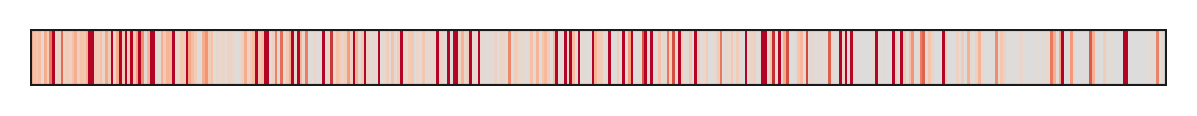

In [186]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

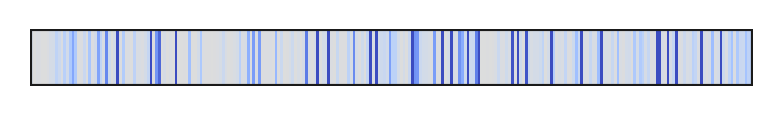

In [187]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

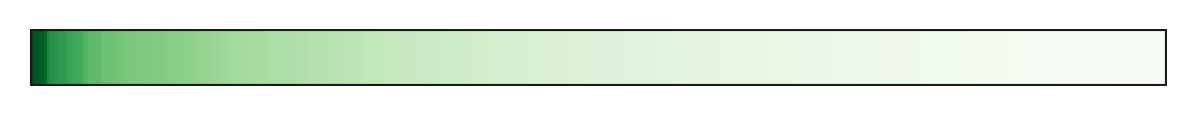

In [188]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

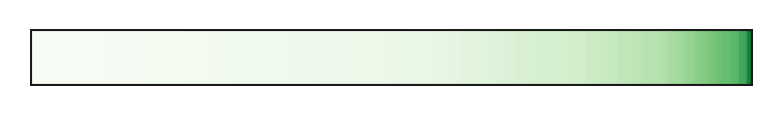

In [330]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

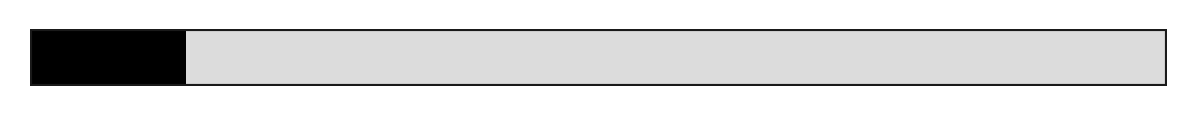

In [331]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

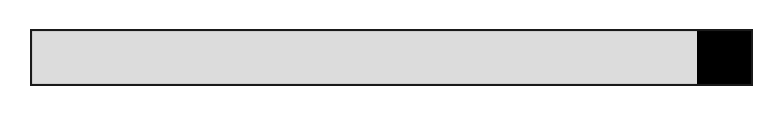

In [332]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [333]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

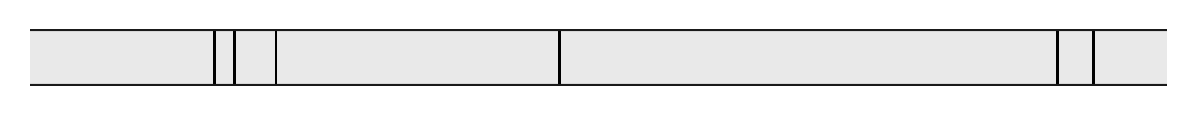

In [334]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [335]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

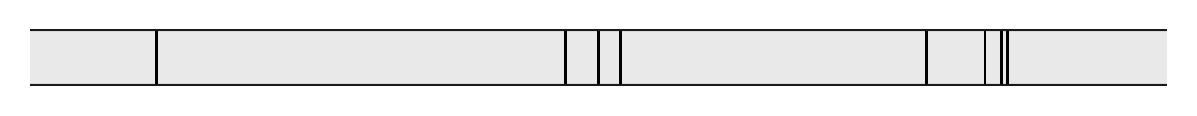

In [336]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


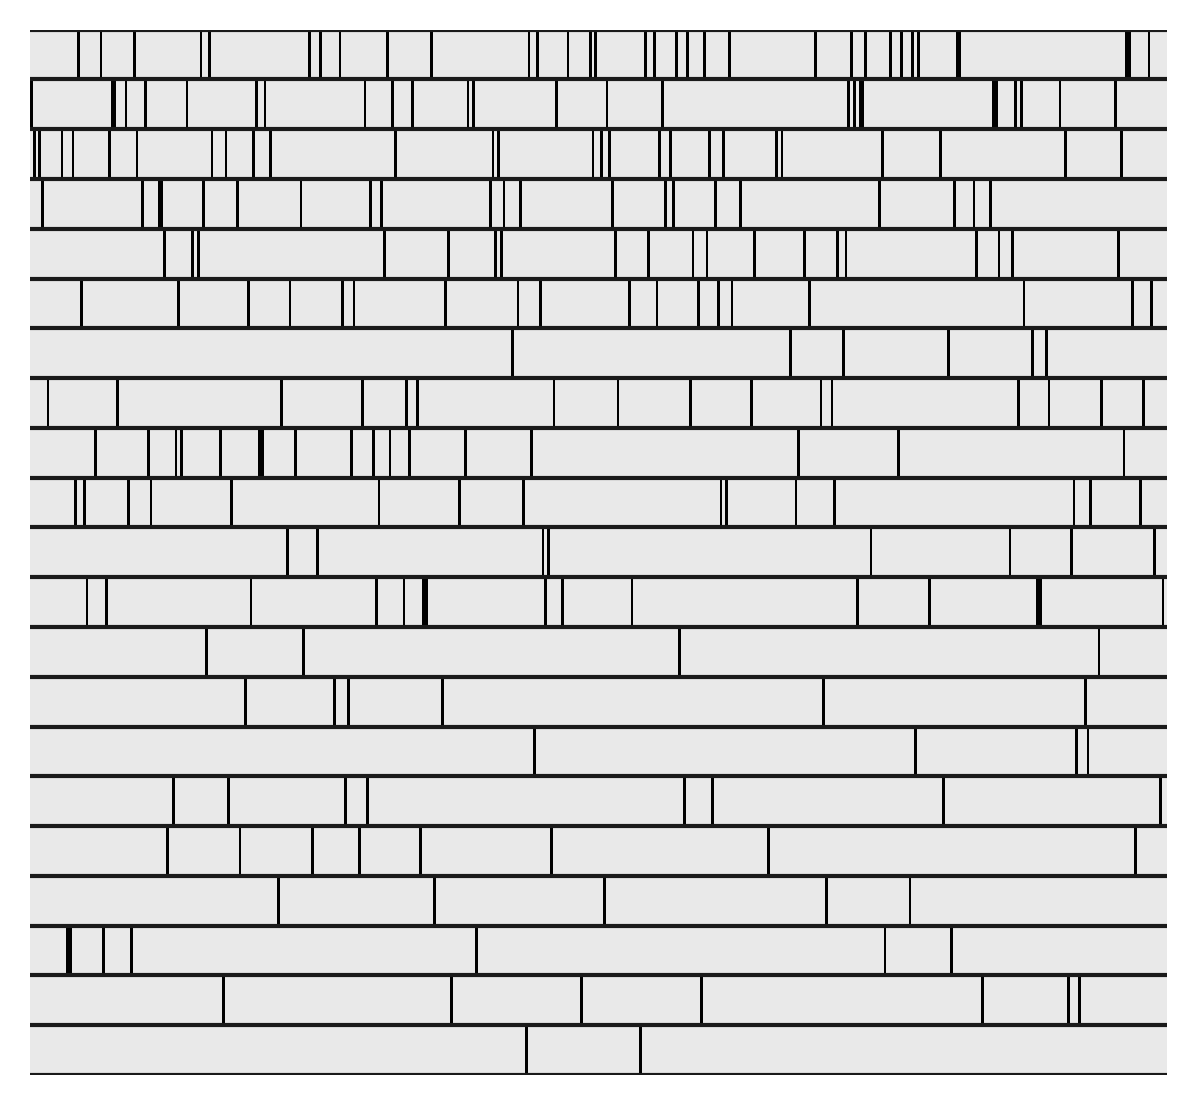

In [337]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [338]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

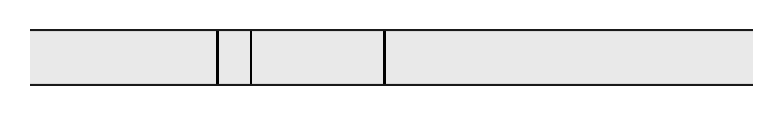

In [339]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

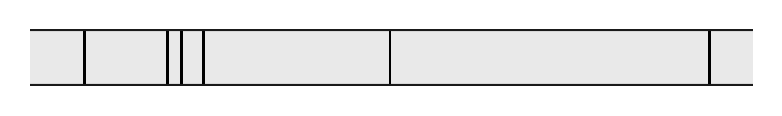

In [340]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

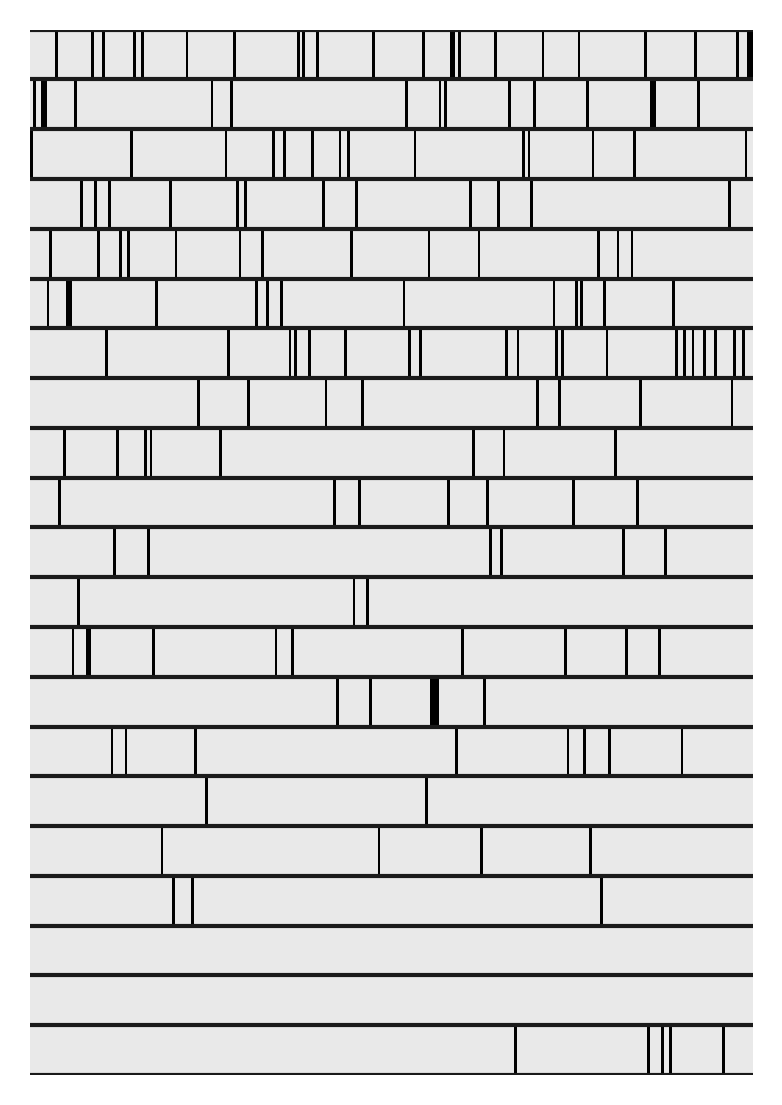

In [341]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')/
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [342]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1089,15,0.013566,0.029292,0.066229,1.178950,0,Platinum,5310940,0.460287
GDSC2_Cisplatin_1005,16,0.016060,0.036034,0.077843,1.108779,0,Platinum,84691,0.477077
gCSI_Cisplatin_CID24191118,9,0.184000,0.065652,0.098129,1.008202,0,Platinum,24191118,0.514700
GDSC1_Cisplatin_1005,17,0.006537,0.023233,0.306221,0.513964,0,Platinum,84691,0.888487
CTRP2_carboplatin_26979,11,0.011000,0.034989,0.879898,0.055568,0,Platinum,38904,0.993606
CTRP2_oxaliplatin_375582,11,0.113000,0.165289,0.905944,0.042898,0,Platinum,24197464,0.993606
PRISM_cisplatin_BRD-K69172251-001-08-9,8,-0.006259,0.080396,0.794028,0.100164,0,Platinum,24191118,0.993606
GDSC2_Oxaliplatin_1806,15,-0.002216,0.014826,0.717220,0.144348,0,Platinum,5310940,0.993606
PRISM_oxaliplatin_BRD-K78960041-001-05-7,8,-0.042299,-0.050250,0.569325,0.244639,0,Platinum,24197464,0.985183


In [343]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Niraparib_1177,15,0.014121,0.027691,0.040916,1.388109,1,PARP inhibitor,24958200,0.419052
CTRP2_olaparib_411867,11,0.341000,0.361484,0.309765,0.508968,0,PARP inhibitor,23725625,0.988306
PRISM_olaparib_BRD-K02113016-001-19-6,7,0.061260,0.026973,0.336310,0.473260,0,PARP inhibitor,23725625,0.988994
GDSC2_Talazoparib_1259,14,0.004896,0.059593,0.347126,0.459512,0,PARP inhibitor,44819241,0.988994
PRISM_niraparib_BRD-K54955827-001-02-2,8,0.014443,-0.010144,0.727413,0.138219,0,PARP inhibitor,24958200,0.999970
GDSC2_Olaparib_1017,16,0.005442,-0.003520,0.794255,0.100040,0,PARP inhibitor,23725625,0.999984
PRISM_olaparib_BRD-K02113016-001-15-4,8,0.071166,-0.019886,0.807119,0.093062,0,PARP inhibitor,23725625,0.999984
GDSC1_Rucaparib_1175,17,0.003012,-0.002023,0.813879,0.089440,0,PARP inhibitor,9931953,0.999984
PRISM_talazoparib_BRD-K95142244-001-01-5,8,-0.043721,0.003134,0.948472,0.022976,0,PARP inhibitor,135565082,0.999984
GDSC1_Olaparib_1017,17,-0.001055,0.003797,0.836275,0.077651,0,PARP inhibitor,23725625,0.999984


### HRR alteration

In [393]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

50

In [396]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
for drug in drug_all:
    a=df_drug[df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df_drug[df_drug['BRCA_status'].isin(['wt'])][drug].dropna().values
    n=len(a)
    r,p=stats.mannwhitneyu(a,b)
    m=np.median(a)-np.median(b)
    m2=np.mean(a)-np.mean(b)
    ns.append(n)
    rs.append(r)
    ps.append(p)
    ms.append(m)
    ms2.append(m2)

In [398]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps
df_cor=df_cor.dropna()

In [400]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [401]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Dinaciclib_1180,40,0.053580,0.026596,0.168819,0.772580,0,Cell cycle,46926350
GDSC1_Dactolisib_1057,46,0.031977,0.019693,0.345868,0.461090,0,PI3K/MTOR signaling,11977753
GDSC1_Navitoclax_1011,46,0.005404,0.024687,0.560818,0.251178,0,Apoptosis regulation,24978538
GDSC2_KRAS (G12C) Inhibitor-12_1855,40,-0.007450,0.000021,0.437756,0.358767,0,ERK MAPK signaling,73555129
PRISM_carmustine_BRD-K36234266-001-09-8,22,0.019237,0.079987,0.493676,0.306558,0,DNA alkylator,2578
...,...,...,...,...,...,...,...,...
PRISM_lenalidomide_BRD-A17883755-001-06-1,23,-0.005674,-0.042522,0.448590,0.348151,0,Protein stability and degradation,216326
PRISM_vinflunine_BRD-K64120610-001-01-4,21,-0.002052,0.015057,0.681187,0.166734,0,Antimicrotubule,6918295
GDSC1_Axitinib_1021,46,0.013052,0.016604,0.272474,0.564675,0,RTK signaling,6450551
GDSC2_RO-3306_1052,8,0.022258,0.043698,0.123305,0.909019,0,Cell cycle,44450571


In [402]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Foretinib_2040,40,0.071592,0.067456,0.000085,4.068974,1,RTK signaling,42642645
GDSC2_BMS-536924_1091,40,0.043135,0.055848,0.000382,3.418310,1,IGF1R signaling,10390396
CTRP2_KW-2449_660413,28,1.002500,0.884322,0.000527,3.277894,1,Others,11427553
CTRP2_AZD4547_660325,25,0.837000,0.940510,0.000562,3.250472,1,RTK signaling,51039095
CTRP2_foretinib_628607,27,0.871000,1.034829,0.001612,2.792530,1,RTK signaling,42642645
...,...,...,...,...,...,...,...,...
GDSC1_Afatinib_1032,46,-0.019109,-0.000684,0.011441,1.941538,1,EGFR signaling,10184653
GDSC1_Cetuximab_1114,42,-0.009229,-0.003865,0.009521,2.021334,1,EGFR signaling,85668777
GDSC1_Olaparib_1495,44,-0.023207,-0.020568,0.007754,2.110501,1,PARP inhibitor,23725625
gCSI_Vorinostat_CID5311,22,-0.096056,-0.088366,0.004910,2.308962,1,Chromatin-related,5311


In [403]:
NP=len(df_cor_p)
NN=len(df_cor_n)

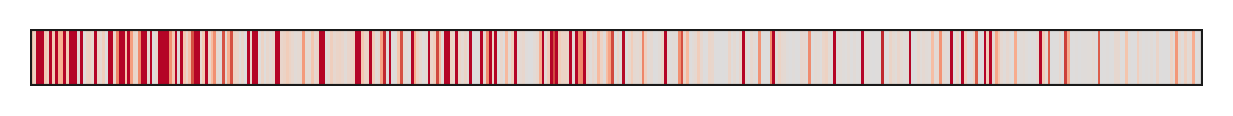

In [404]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

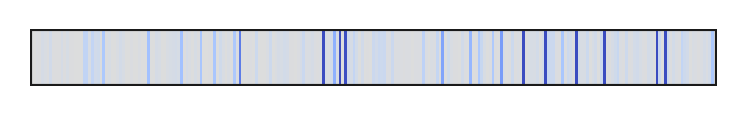

In [405]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

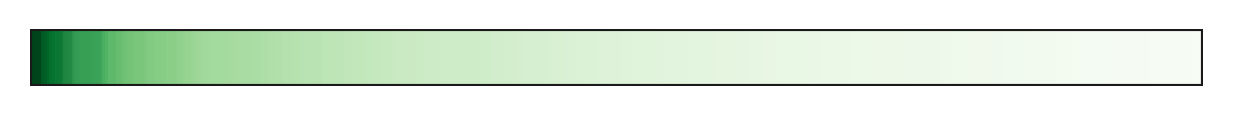

In [406]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

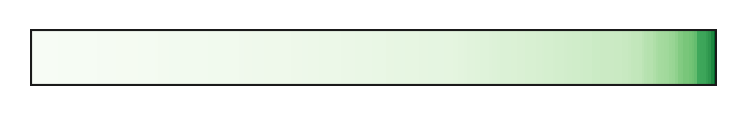

In [407]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

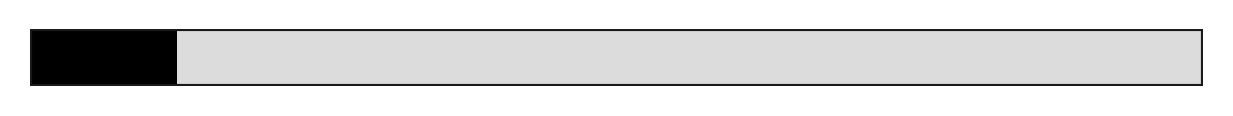

In [408]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

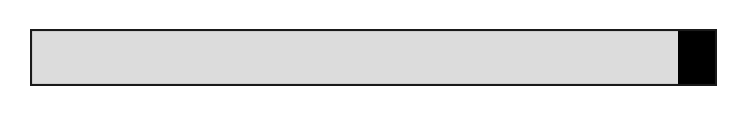

In [409]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [410]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

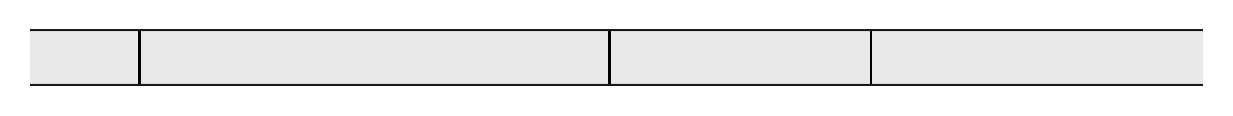

In [411]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

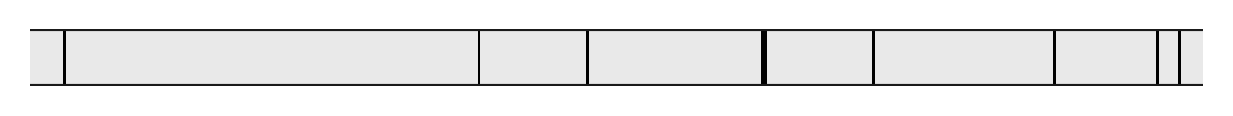

In [412]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


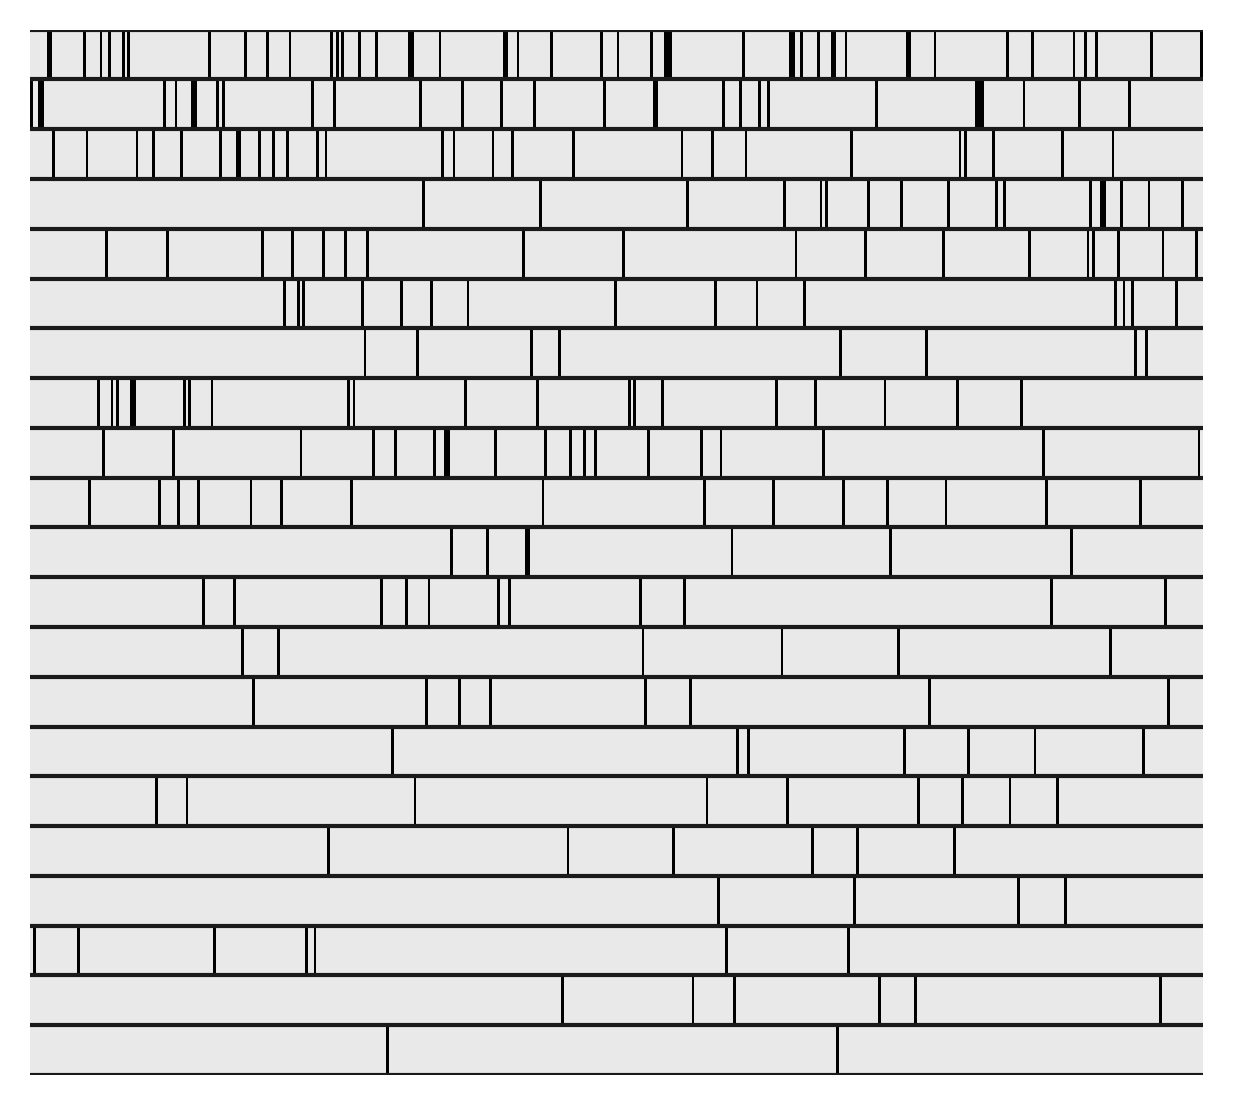

In [413]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [414]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

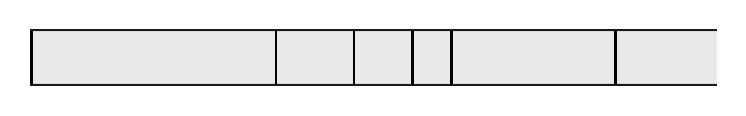

In [415]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

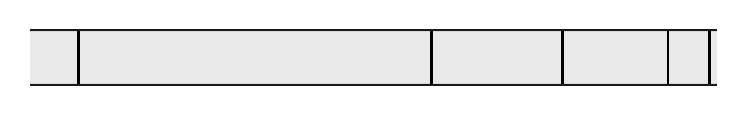

In [416]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

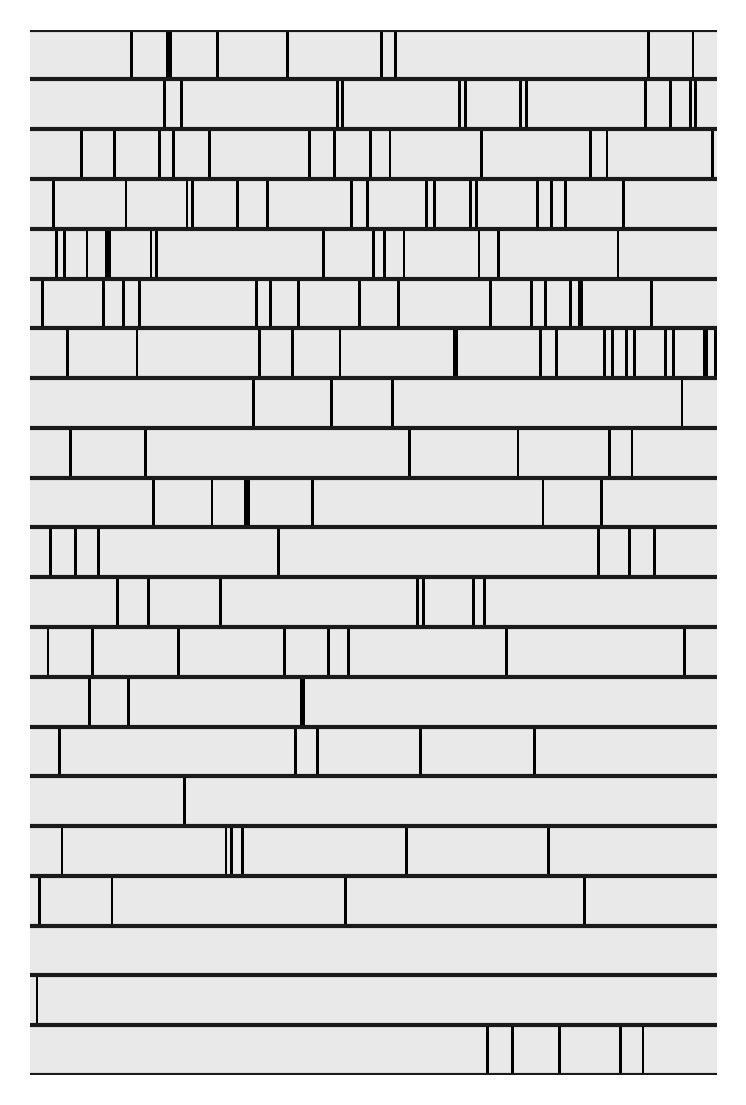

In [420]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')/
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [418]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
gCSI_Cisplatin_CID24191118,16,0.171222,0.052806,0.035846,1.445560,1,Platinum,24191118,0.280024
CTRP2_oxaliplatin_375582,27,0.134000,0.267010,0.340293,0.468147,0,Platinum,24197464,0.945618
GDSC1_Cisplatin_1005,46,0.003748,0.008687,0.581807,0.235221,0,Platinum,84691,0.958956
GDSC2_Oxaliplatin_1089,41,-0.002895,0.007149,0.998986,0.000441,0,Platinum,5310940,0.998986
GDSC2_Oxaliplatin_1806,40,-0.009265,0.005315,0.660995,0.179802,0,Platinum,5310940,0.958956
CTRP2_carboplatin_26979,28,-0.052500,-0.080187,0.542173,0.265862,0,Platinum,38904,0.958956
GDSC2_Cisplatin_1005,41,-0.000736,0.014469,0.450878,0.345941,0,Platinum,84691,0.958956
PRISM_cisplatin_BRD-K69172251-001-08-9,23,-0.009564,0.031854,0.412680,0.384387,0,Platinum,24191118,0.958956
PRISM_oxaliplatin_BRD-K78960041-001-05-7,23,-0.028927,-0.061817,0.192520,0.715525,0,Platinum,24197464,0.819259


In [419]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,adjusted_P
CTRP2_olaparib_411867,27,0.493000,0.539656,0.004714,2.326654,1,PARP inhibitor,23725625,0.064005
GDSC2_Niraparib_1177,40,0.003406,0.014887,0.226186,0.645535,0,PARP inhibitor,24958200,0.940433
PRISM_olaparib_BRD-K02113016-001-19-6,20,0.029954,0.020016,0.324622,0.488622,0,PARP inhibitor,23725625,0.970764
GDSC1_Rucaparib_1175,46,0.002502,-0.006129,0.468957,0.328867,0,PARP inhibitor,9931953,0.989062
GDSC2_Olaparib_1017,41,0.004278,0.005306,0.473572,0.324614,0,PARP inhibitor,23725625,0.989062
GDSC1_Veliparib_1018,46,0.001044,0.003714,0.588290,0.230409,0,PARP inhibitor,11960529,0.989062
GDSC2_Talazoparib_1259,39,0.002555,0.029400,0.802560,0.095522,0,PARP inhibitor,44819241,0.998480
CTRP2_veliparib_606034,27,0.034000,0.061764,0.933061,0.030090,0,PARP inhibitor,11960529,0.999700
PRISM_niraparib_BRD-K54955827-001-02-2,23,0.024314,-0.004311,0.956411,0.019355,0,PARP inhibitor,24958200,0.999700
GDSC1_Olaparib_1017,46,-0.001048,0.005341,0.950986,0.021826,0,PARP inhibitor,23725625,0.999700


## Correlations with HRD score and Signature 3

(973, 2)
r = 0.403, p = 3.42e-39


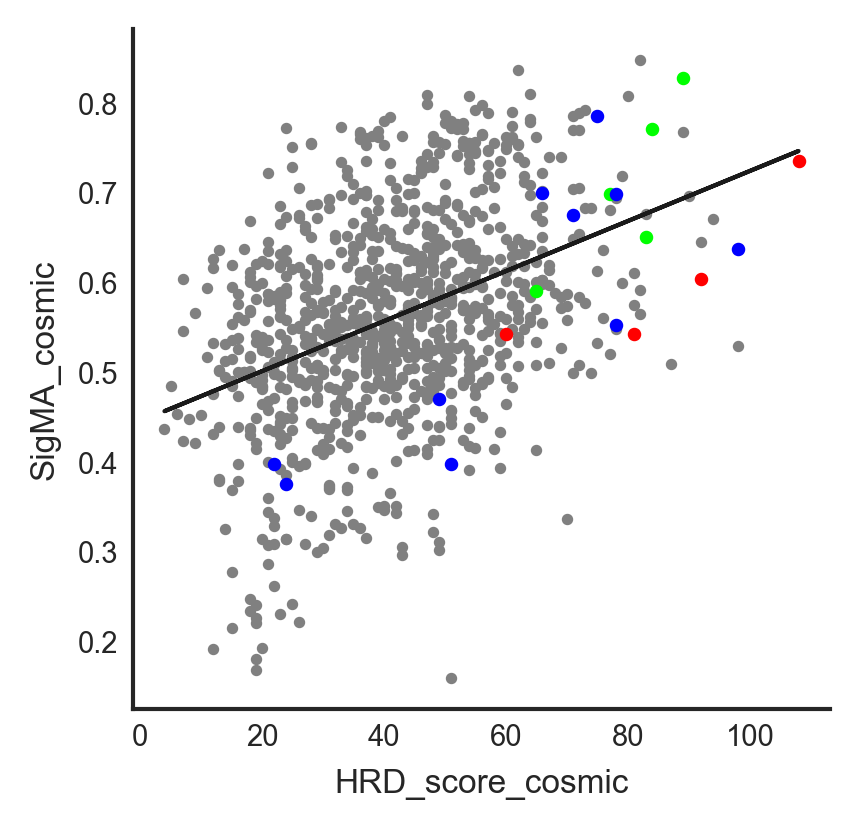

In [189]:
in_df=df2.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_cosmic','SigMA_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

In [190]:
df2['BRCA2_LOH'].sum()

10

In [191]:
df2['BRCA1_LOH'].sum()

4

HRR vs Othres 0.0015690802254608534 9.0
HRR vs wt 0.004192262502043102 8.0
BRCA vs wt 1.2648514309027457e-07 35.0


/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


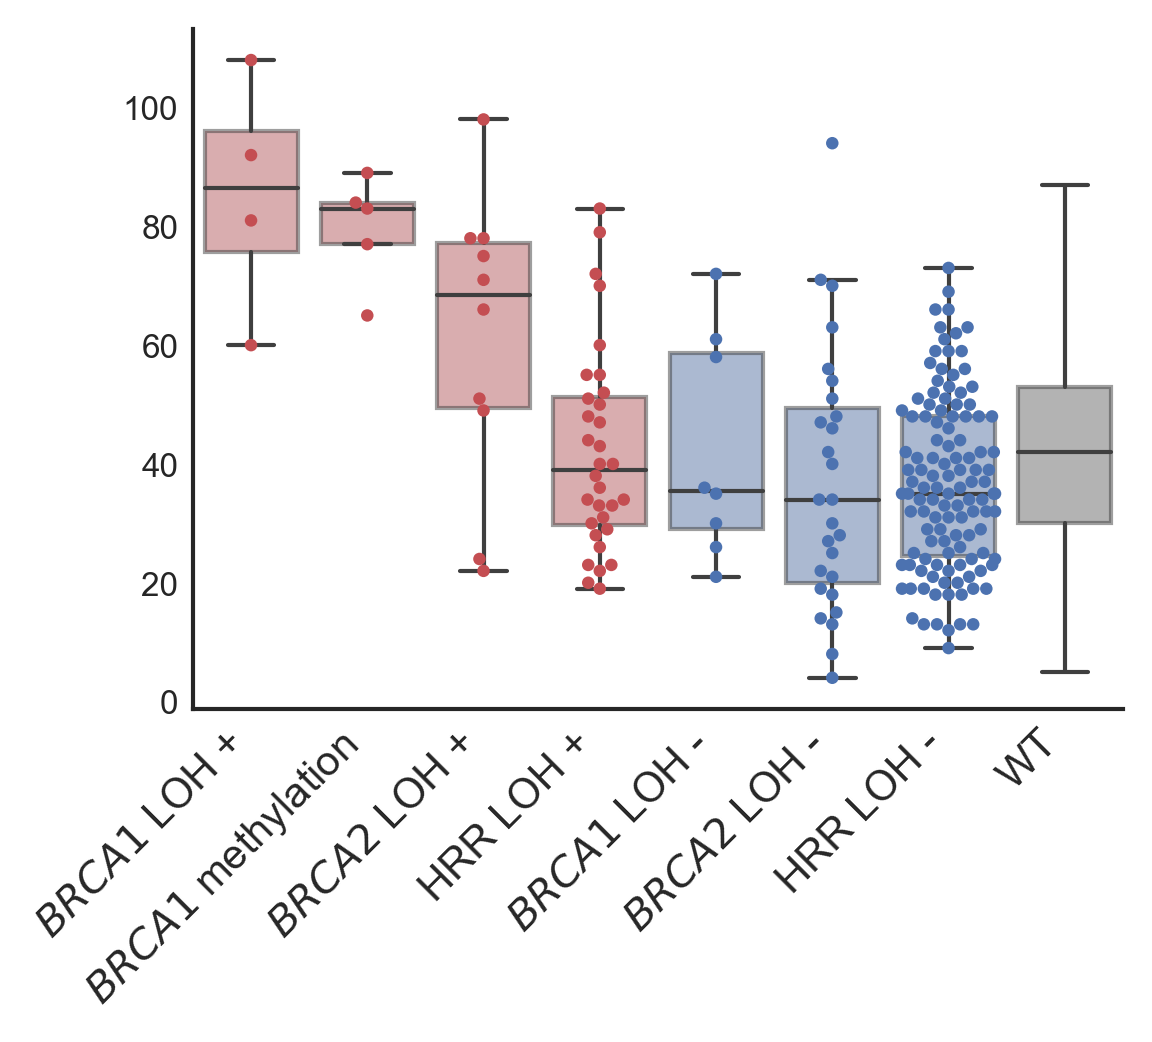

In [192]:
plt_df=df2
cat='BRCA_status'
val='HRD_score_cosmic'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [193]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=45.37093254060692, pvalue=1.1585767680578302e-07)

HRR vs Othres 0.7157131090709701 -0.007594144266517389
HRR vs wt 0.473135207402289 -0.011724567379434947
BRCA vs wt 0.08540052491341453 0.07267122251818803


/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


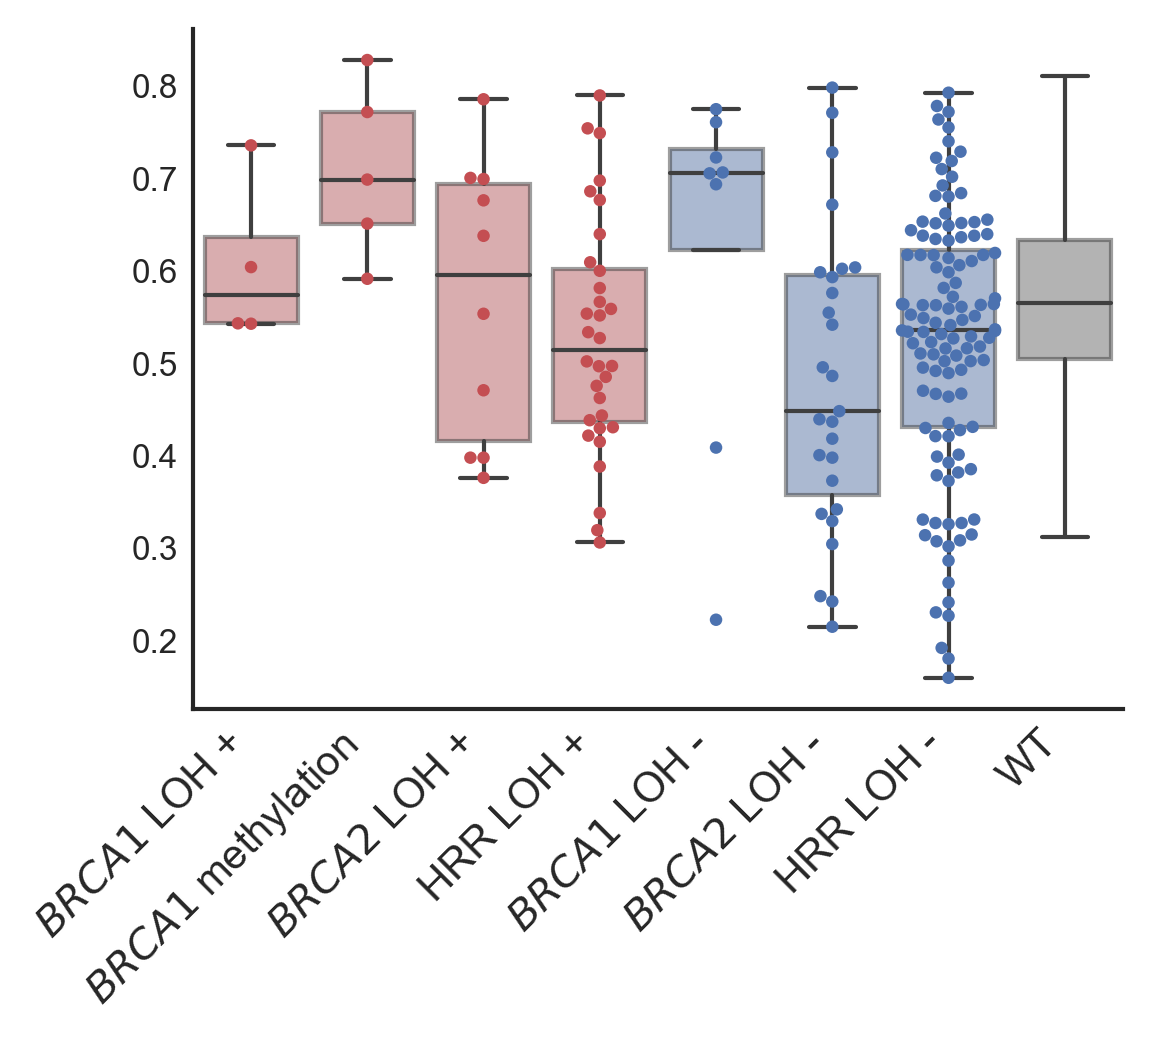

In [194]:
plt_df=df2
cat='BRCA_status'
val='SigMA_cosmic'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

a=plt_df[plt_df[cat]==order[0]][val].dropna().values
b=plt_df[plt_df[cat]==order[1]][val].dropna().values
c=plt_df[plt_df[cat]==order[2]][val].dropna().values
d=plt_df[plt_df[cat]==order[3]][val].dropna().values
e=plt_df[plt_df[cat]==order[7]][val].dropna().values
f=plt_df[plt_df[cat]==order[4]][val].dropna().values
g=plt_df[plt_df[cat]==order[5]][val].dropna().values
h=plt_df[plt_df[cat]==order[6]][val].dropna().values

abcd=list(a)+list(b)+list(c)+list(d)
efgh=list(e)+list(f)+list(g)+list(h)
_,p1=stats.mannwhitneyu(abcd,efgh)
m1,m2=np.median(abcd),np.median(efgh)
print('HRR vs Othres',p1,m1-m2)
_,p2=stats.mannwhitneyu(abcd,e)
m1,m2=np.median(abcd),np.median(e)
print('HRR vs wt',p2,m1-m2)
abc=list(a)+list(b)+list(c)
_,p3=stats.mannwhitneyu(abc,e)
m1,m2=np.median(abc),np.median(e)
print('BRCA vs wt',p3,m1-m2)

In [130]:
values=[]
for cat2 in ['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH',
            'BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']:
    val2=list(plt_df[plt_df[cat]==cat2][val].dropna().values)
    values.append(val2)
    
stats.kruskal(values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],)

KruskalResult(statistic=32.009909749071994, pvalue=4.044445637223879e-05)

## Genomic scar score and Drug sensitivity

### HRD score

In [421]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df2[['HRD_score_cosmic',drug]].dropna()
    a=plt_df['HRD_score_cosmic'].values
    b=plt_df[drug].values
    n=len(a)
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [422]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [423]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [424]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(669, 7)

In [425]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
GDSC2_Cytarabine_1006,743,3.496451e-26,0.374720,25.456373,1,Antimetabolite,6253
GDSC2_Oxaliplatin_1089,792,7.015871e-25,0.354609,24.153918,1,Platinum,5310940
GDSC2_Epirubicin_1511,743,1.593496e-22,0.347593,21.797649,1,DNA inhibitor,41867
GDSC2_Nutlin-3a (-)_1047,763,4.063605e-22,0.340127,21.391089,1,p53 pathway,11433190
GDSC2_Palbociclib_1054,760,1.343404e-19,0.320355,18.871793,1,Cell cycle,5330286
...,...,...,...,...,...,...,...
GDSC2_Picolinici-acid_1635,720,3.639639e-06,-0.171602,5.438942,1,Others,1018
GDSC1_Cetuximab_1114,853,1.192727e-07,-0.180064,6.923459,1,EGFR signaling,85668777
GDSC2_GDC0810_1925,743,7.100110e-08,-0.196097,7.148735,1,Hormone-related,56941241
GDSC2_AZD3759_1915,751,9.796967e-09,-0.207312,8.008908,1,EGFR signaling,78209992


In [426]:
NP=len(df_cor_p)
NN=len(df_cor_n)

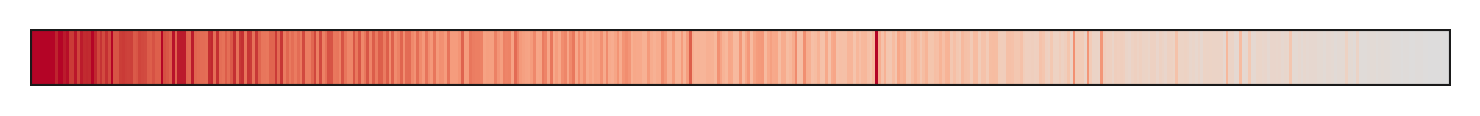

In [427]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

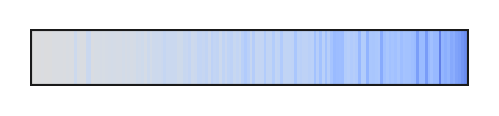

In [428]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

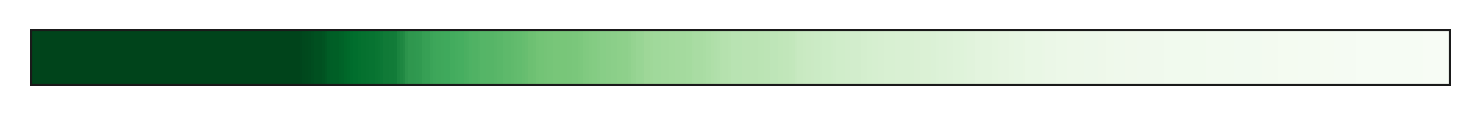

In [429]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

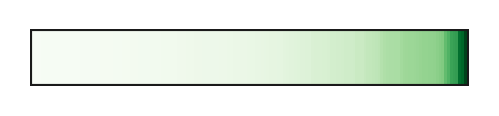

In [430]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

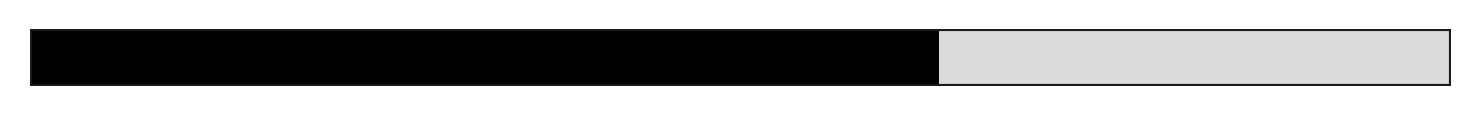

In [354]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

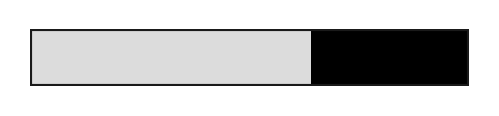

In [355]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [356]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

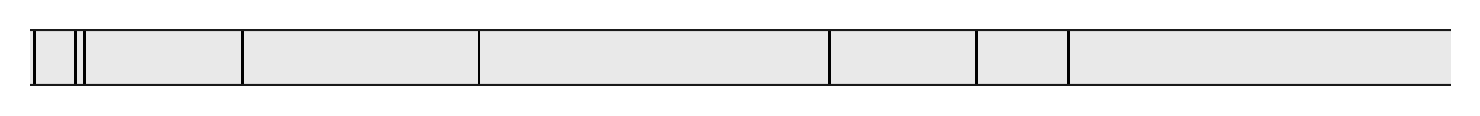

In [357]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

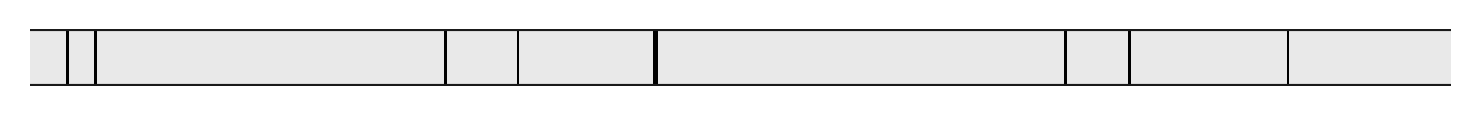

In [358]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
DNA inhibitor
Antimetabolite
EGFR signaling
Antimicrotubule
Cell cycle
Apoptosis regulation
Hormone-related
Protein stability and degradation
DNA alkylator
Topoisomerase inhibitor
WNT signaling
Metabolism
Genome integrity
p53 pathway
IGF1R signaling
Cytoskeleton
JNK and p38 signaling


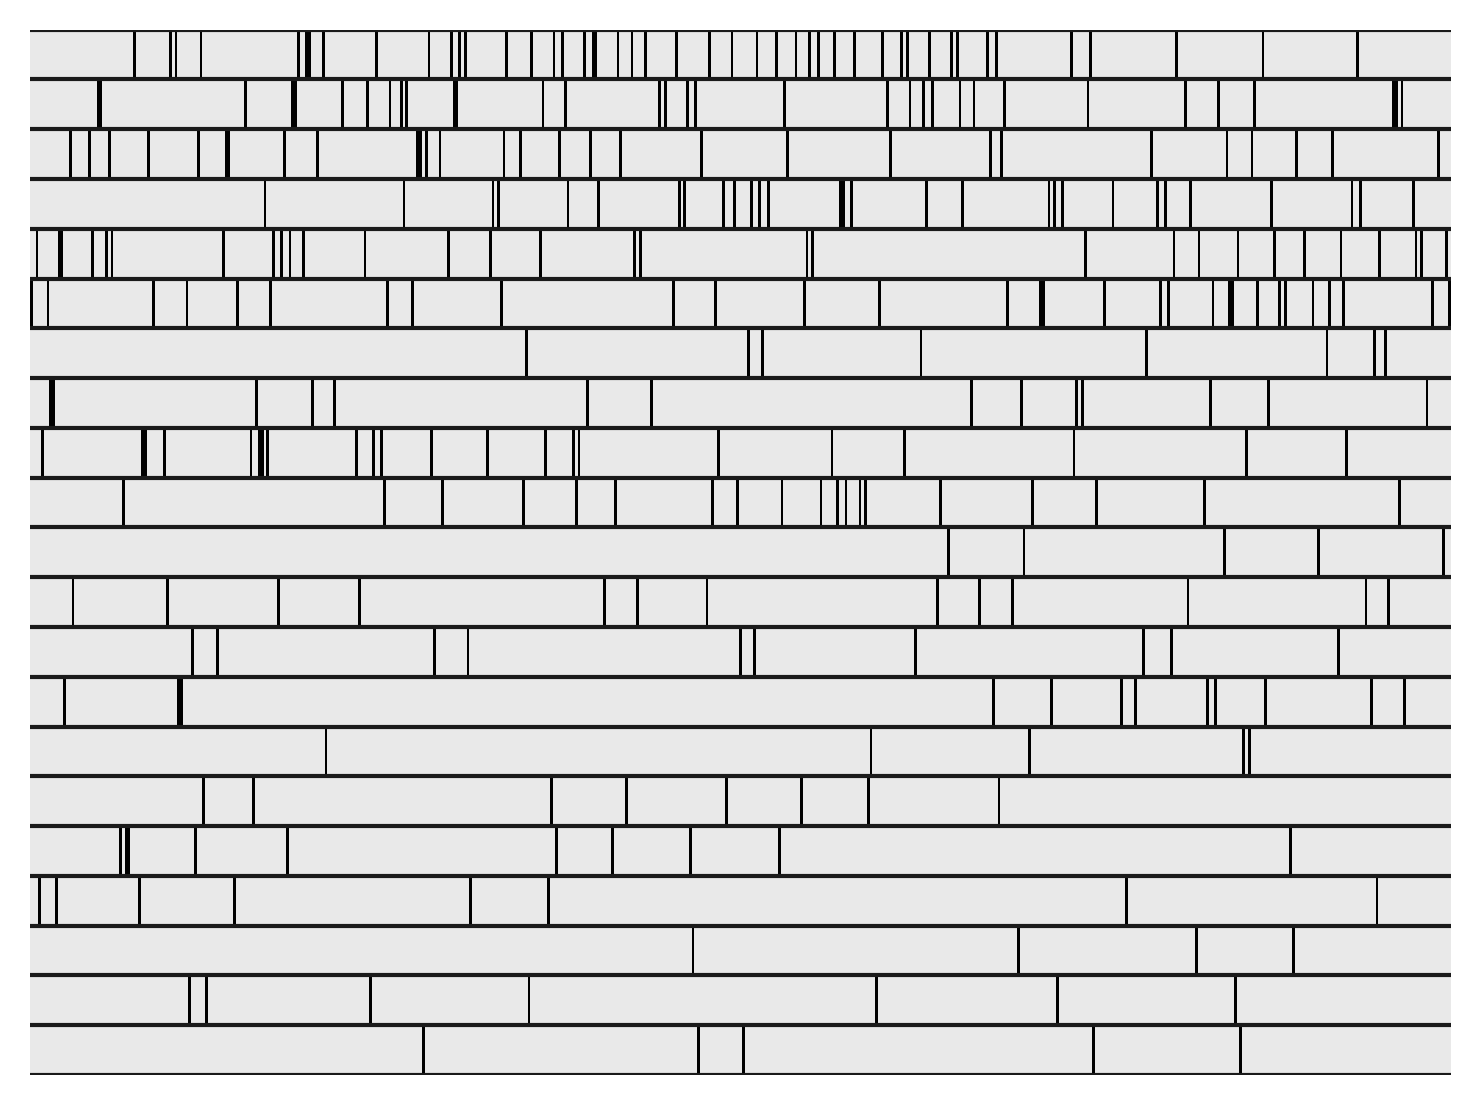

In [359]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [360]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

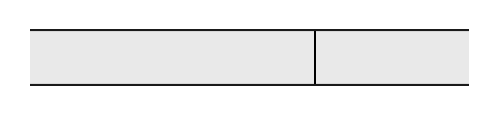

In [361]:
sns_df=in_df.reindex(columns=['Platinum']).fillna(0)#in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

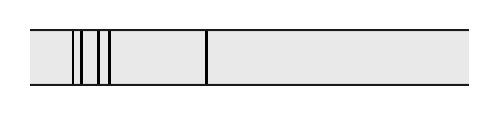

In [362]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

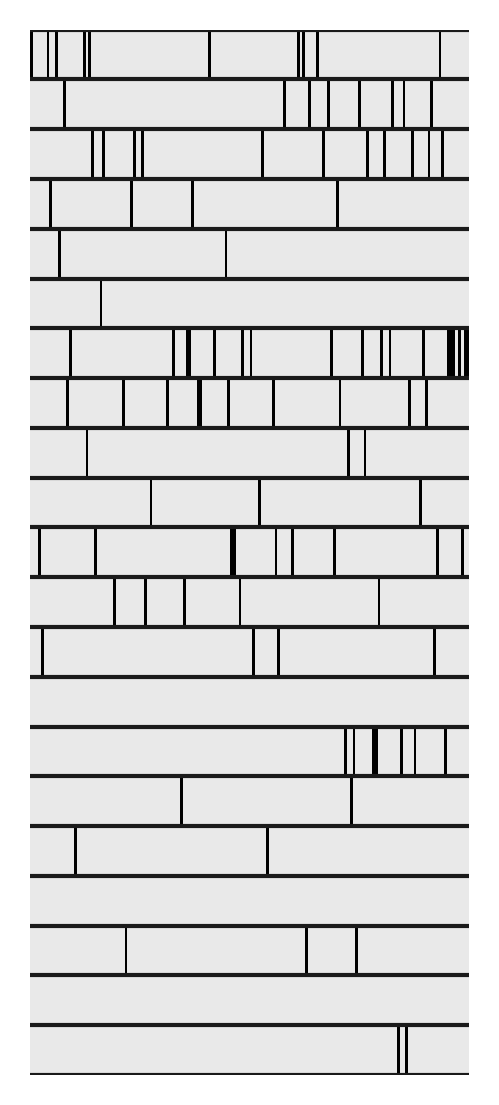

In [363]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [364]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1089,792,7.015871e-25,0.354609,24.153918,1,Platinum,5310940,6.314284e-24
GDSC2_Oxaliplatin_1806,720,2.140423e-15,0.289780,14.669500,1,Platinum,5310940,1.712338e-14
GDSC2_Cisplatin_1005,758,6.159011e-15,0.278180,14.210489,1,Platinum,84691,4.311307e-14
CTRP2_oxaliplatin_375582,501,5.732359e-10,0.272320,9.241667,1,Platinum,24197464,3.439415e-09
CTRP2_carboplatin_26979,514,2.085719e-05,0.186507,4.680744,1,Platinum,38904,1.042816e-04
GDSC1_Cisplatin_1005,923,1.599050e-02,0.079280,1.796138,1,Platinum,84691,6.244411e-02
PRISM_oxaliplatin_BRD-K78960041-001-05-7,351,8.264786e-02,0.092767,1.082768,0,Platinum,24197464,1.584650e-01
gCSI_Cisplatin_CID24191118,231,2.623387e-01,0.074049,0.581138,0,Platinum,24191118,2.623387e-01
PRISM_cisplatin_BRD-K69172251-001-08-9,349,3.810318e-02,-0.111060,1.419039,1,Platinum,24191118,1.100093e-01


In [366]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Talazoparib_1259,739,3.592479e-16,0.293719,15.444606,1,PARP inhibitor,44819241,5.029471e-15
GDSC2_Niraparib_1177,720,1.777250e-14,0.280423,13.750251,1,PARP inhibitor,24958200,2.310425e-13
GDSC1_Olaparib_1017,921,8.957121e-06,0.145749,5.047832,1,PARP inhibitor,23725625,1.074802e-04
CTRP2_olaparib_411867,510,4.695854e-05,0.179213,4.328285,1,PARP inhibitor,23725625,5.164227e-04
GDSC1_Talazoparib_1259,888,9.662019e-04,0.110563,3.014932,1,PARP inhibitor,44819241,9.620117e-03
GDSC2_Olaparib_1017,752,9.788880e-04,0.119977,3.009267,1,PARP inhibitor,23725625,9.620117e-03
CTRP2_veliparib_606034,525,2.475046e-01,0.050559,0.606417,0,PARP inhibitor,11960529,8.971911e-01
GDSC1_Veliparib_1018,922,3.779559e-01,0.029070,0.422559,0,PARP inhibitor,11960529,9.420668e-01
PRISM_talazoparib_BRD-K95142244-001-01-5,373,6.235314e-01,0.025497,0.205142,0,PARP inhibitor,135565082,9.924379e-01
GDSC1_Olaparib_1495,884,8.092805e-01,-0.008129,0.091901,0,PARP inhibitor,23725625,9.924379e-01


### Signature 3

In [431]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df2[['SigMA_cosmic',drug]].dropna()
    a=plt_df['SigMA_cosmic'].values
    b=plt_df[drug].values
    n=len(a)
    r,p=stats.spearmanr(a,b)
    ns.append(n)
    rs.append(r)
    ps.append(p)

In [432]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs
df_cor=df_cor.dropna()

In [433]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [434]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(669, 7)

In [435]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,significant,drug_anno,cid
GDSC1_(5Z)-7-Oxozeaenol_1242,889,1.715645e-11,0.223126,10.765572,1,Others,9863776
GDSC1_VX-11e_262,897,5.680254e-11,0.216465,10.245632,1,ERK MAPK signaling,11634725
GDSC1_Dabrafenib_1373,847,5.113706e-10,0.211462,9.291264,1,ERK MAPK signaling,44462760
GDSC1_NVP-BHG712_295,897,1.073185e-09,0.201794,8.969326,1,Others,16747388
GDSC1_CI-1040_1015,906,1.343794e-09,0.199644,8.871667,1,ERK MAPK signaling,6918454
...,...,...,...,...,...,...,...
CTRP2_ciclosporin_55512,484,3.123172e-03,-0.134074,2.505404,1,Others,6435893
gCSI_Vincristine_CID5978,352,1.739360e-04,-0.198803,3.759610,1,Others,5978
gCSI_Dabrafenib_CID44462760,348,2.325133e-05,-0.224714,4.633552,1,ERK MAPK signaling,44462760
gCSI_Crizotinib_CID54613769,355,1.454781e-06,-0.252417,5.837202,1,RTK signaling,54613769


In [436]:
NP=len(df_cor_p)
NN=len(df_cor_n)

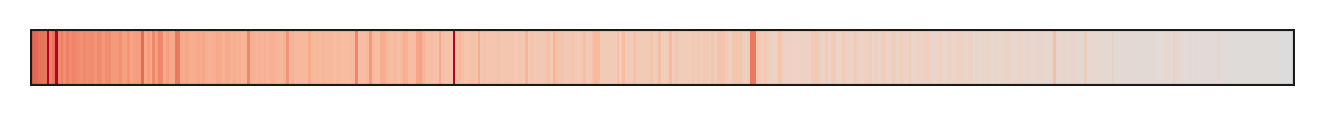

In [437]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

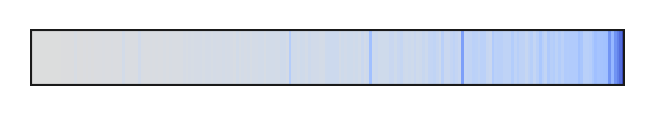

In [438]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

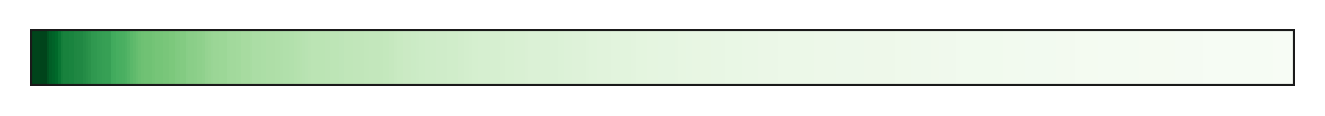

In [439]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

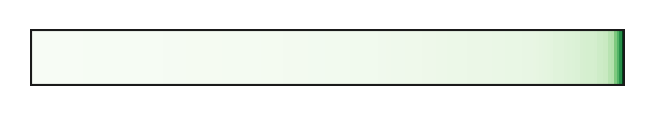

In [440]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

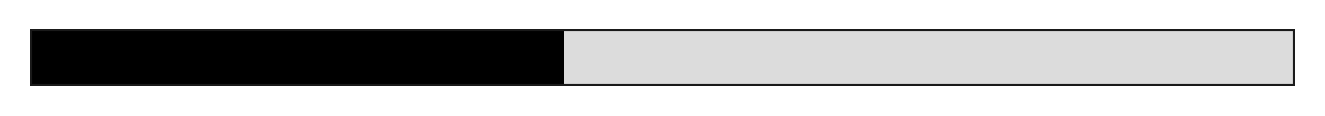

In [441]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

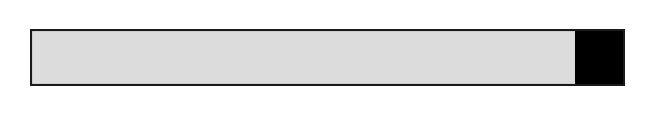

In [442]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [443]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

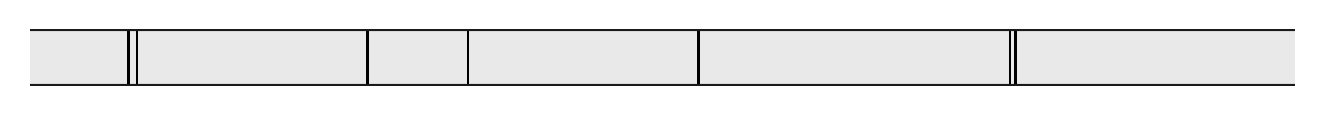

In [444]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

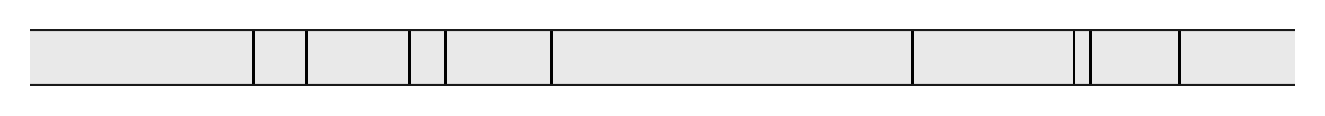

In [445]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

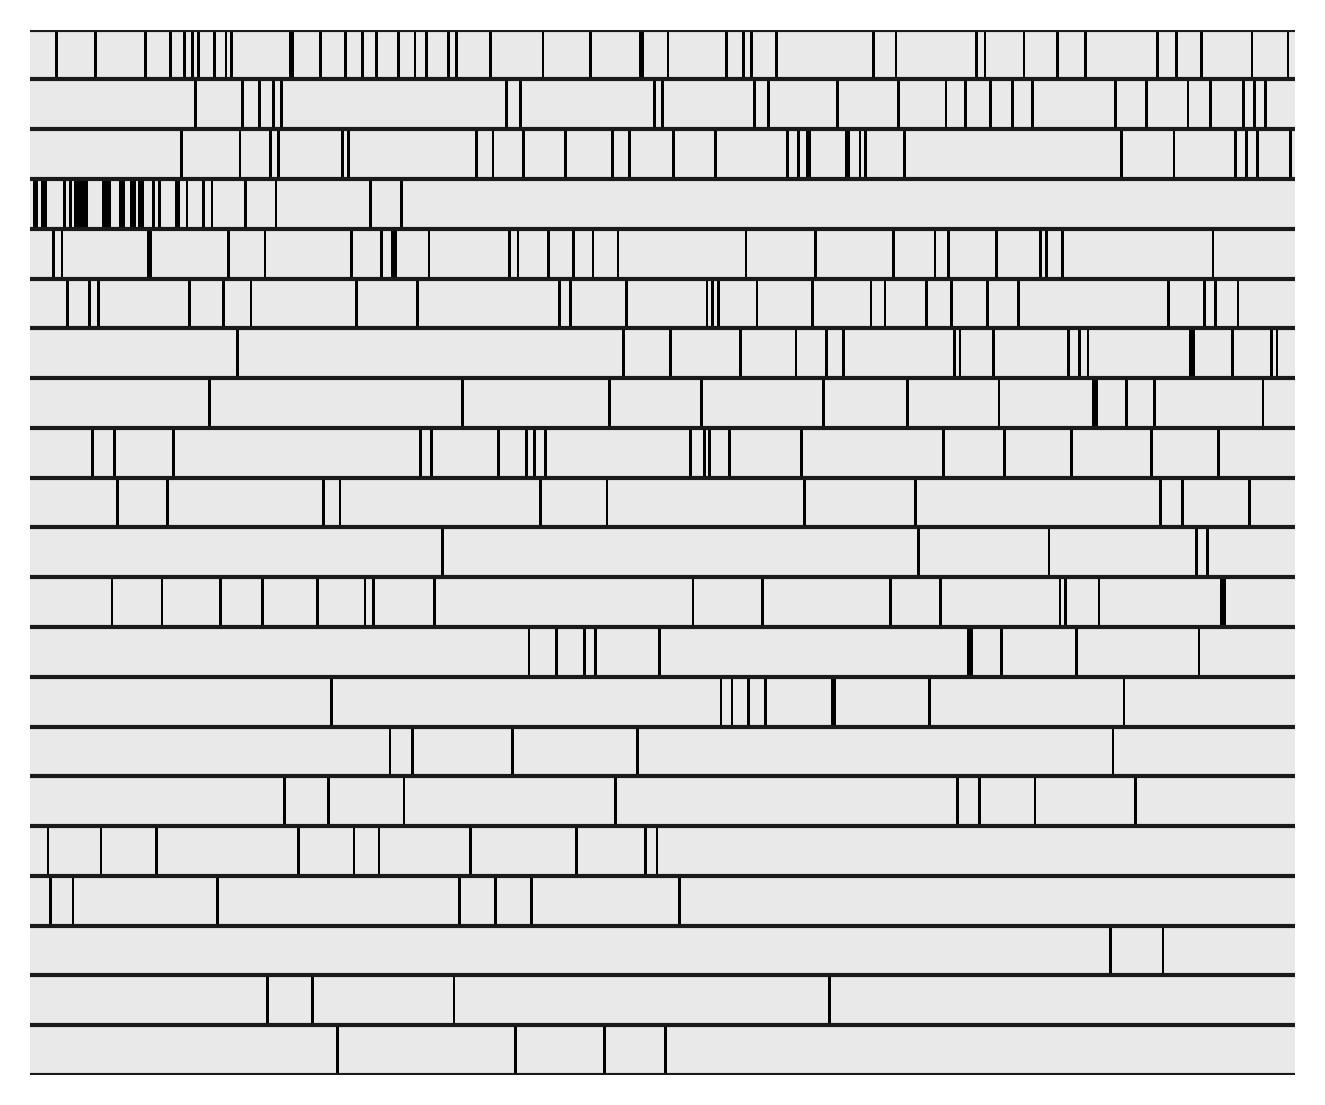

In [446]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [447]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

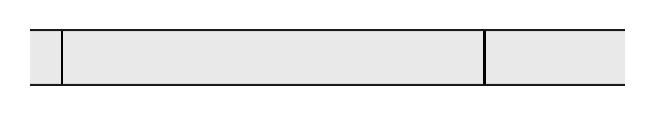

In [448]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

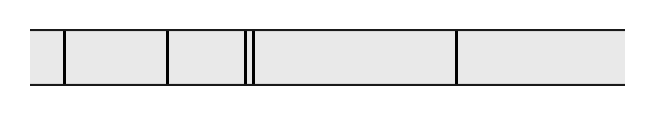

In [449]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

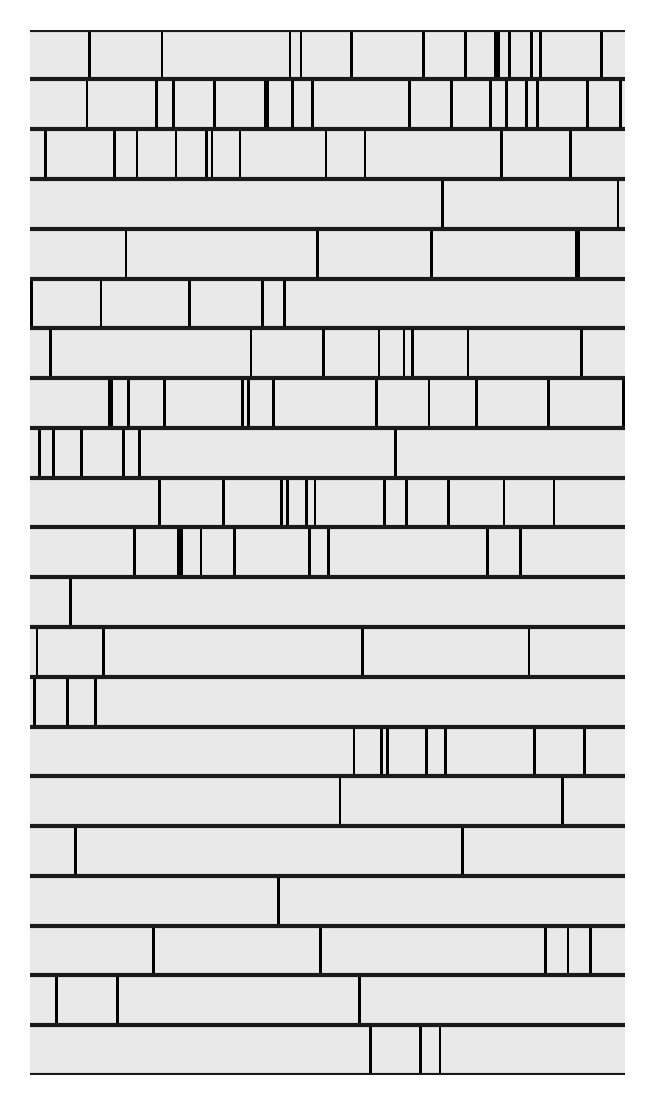

In [450]:
sns_df=in_df.reindex(columns=drug_order[2:]).fillna(0)
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.55))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    #print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

In [451]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/263279985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Oxaliplatin_1806,720,0.000022,0.157393,4.655382,1,Platinum,5310940,0.000199
GDSC2_Oxaliplatin_1089,791,0.000050,0.143759,4.305224,1,Platinum,5310940,0.000396
GDSC2_Cisplatin_1005,757,0.007348,0.097359,2.133817,1,Platinum,84691,0.050317
GDSC1_Cisplatin_1005,922,0.025371,0.073629,1.595667,1,Platinum,84691,0.142890
CTRP2_carboplatin_26979,514,0.136679,0.065734,0.864298,0,Platinum,38904,0.520420
PRISM_oxaliplatin_BRD-K78960041-001-05-7,350,0.491034,0.036930,0.308888,0,Platinum,24197464,0.868155
CTRP2_oxaliplatin_375582,501,0.508819,0.029584,0.293437,0,Platinum,24197464,0.868155
gCSI_Cisplatin_CID24191118,231,0.964023,-0.002984,0.015912,0,Platinum,24191118,0.964023
PRISM_cisplatin_BRD-K69172251-001-08-9,348,0.194960,-0.069641,0.710054,0,Platinum,24191118,0.579981


In [452]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_7876/3329360899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['adjusted_P']=multipletests(tmp_df['pvalues'])[1]


,Number,pvalues,rS,mlog10p,significant,drug_anno,cid,adjusted_P
GDSC2_Talazoparib_1259,738,0.001799,0.114721,2.744986,1,PARP inhibitor,44819241,0.024893
GDSC1_Olaparib_1017,920,0.004032,0.094722,2.394464,1,PARP inhibitor,23725625,0.051168
GDSC2_Niraparib_1177,720,0.012993,0.092534,1.886296,1,PARP inhibitor,24958200,0.145241
GDSC1_Talazoparib_1259,887,0.018907,0.078805,1.723370,1,PARP inhibitor,44819241,0.189393
GDSC1_Veliparib_1018,921,0.046852,0.065513,1.329269,1,PARP inhibitor,11960529,0.381126
GDSC1_Olaparib_1495,883,0.340985,0.032082,0.467265,0,PARP inhibitor,23725625,0.964423
PRISM_niraparib_BRD-K54955827-001-02-2,366,0.601951,0.027353,0.220439,0,PARP inhibitor,24958200,0.998417
GDSC2_Olaparib_1017,751,0.633154,0.017444,0.198490,0,PARP inhibitor,23725625,0.998417
PRISM_olaparib_BRD-K02113016-001-19-6,338,0.751050,0.017319,0.124331,0,PARP inhibitor,23725625,0.998417
PRISM_talazoparib_BRD-K95142244-001-01-5,372,0.952333,-0.003110,0.021211,0,PARP inhibitor,135565082,0.998417


# Broad vs COSMIC

In [195]:
df12=df0.merge(df2[['SigMA_cosmic','HRD_score_cosmic']],left_on='COSMICID',right_index=True,how='outer')

(636, 2)
r = 0.870, p = 9.80e-197


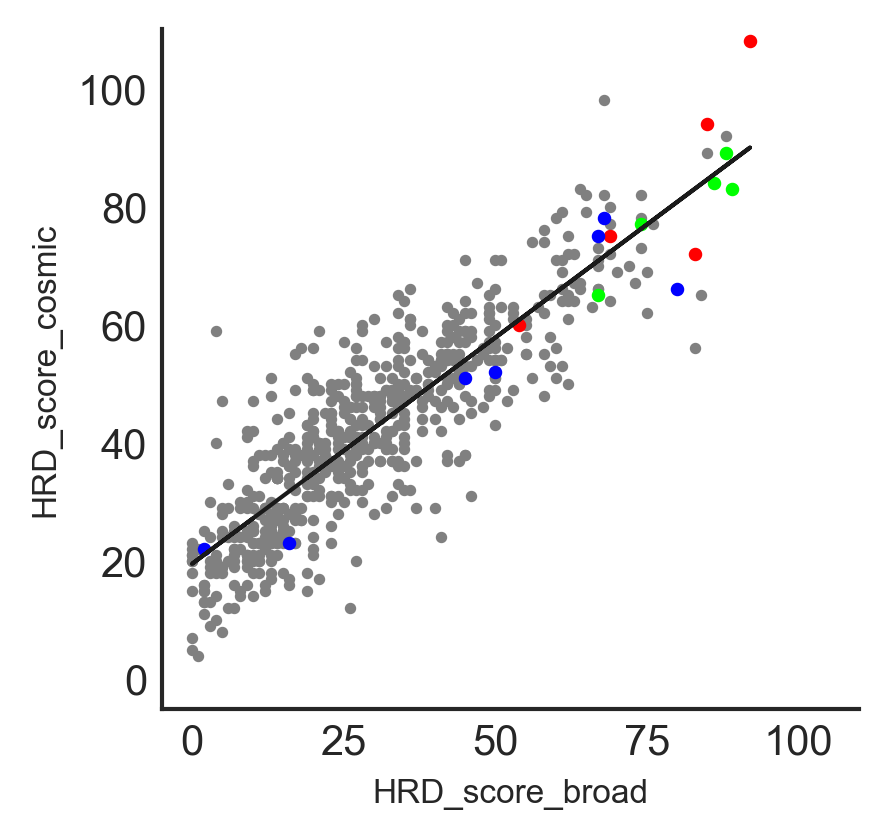

In [196]:
in_df=df12.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','HRD_score_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

ax.set_xlim(-5,110)
ax.set_ylim(-5,110)
ax.tick_params(labelsize=10)

(941, 2)
r = 0.959, p = 0.00e+00


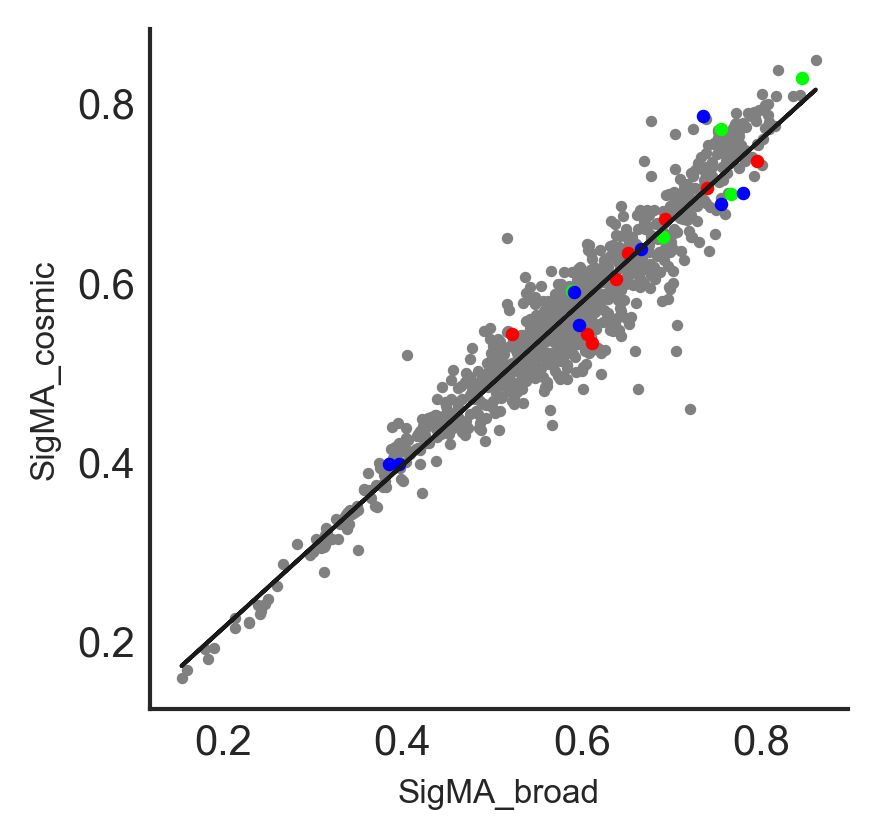

In [197]:
in_df=df12.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='SigMA_broad','SigMA_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

ax.set_xticks([0.2,0.4,0.6,0.8])
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.tick_params(labelsize=10)